In [127]:
import numpy as np

import matplotlib
#print(matplotlib.__version__)
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from matplotlib import ticker

from scipy import linalg
from scipy.optimize import curve_fit
from scipy.optimize import brentq
from scipy.special import erf
from scipy.special import erfi
from scipy.special import factorial
from scipy import signal
from scipy.integrate import odeint
from scipy.integrate import complex_ode
from scipy.integrate import solve_ivp
from scipy.linalg import expm
from scipy.linalg import eig

from IPython.display import HTML

import re

%matplotlib notebook


In [128]:
#Colors for color-blindness

reddishpurple = [204/255.0,121/255.0,167/255.0]
green = [0,158/255.0,115/255.0]
orange = [230/255.0,159/255.0,0/255.0]
blue = [0/255.0,114/255.0,178/255.0]

#Linestyles
linestyles_dict = {
     'loosely dotted' :        (0, (1, 10)),
     'dotted' :                (0, (1, 1)),
     'densely dotted' :        (0, (1, 1)),

     'loosely dashed' :        (0, (5, 10)),
     'dashed' :                (0, (5, 5)),
     'densely dashed' :        (0, (5, 1)),

     'loosely dashdotted' :    (0, (3, 10, 1, 10)),
     'dashdotted' :            (0, (3, 5, 1, 5)),
     'densely dashdotted' :    (0, (3, 1, 1, 1)),

     'dashdotdotted' :         (0, (3, 5, 1, 5, 1, 5)),
     'loosely dashdotdotted' : (0, (3, 10, 1, 10, 1, 10)),
     'densely dashdotdotted' : (0, (3, 1, 1, 1, 1, 1))
}

In [129]:
# definitions for square pulse

# function for integration with odeint
def bloch(M,t,om,w1,R2,R1):
    
    dxdt = -R2*M[0] - om*M[1]
    dydt = -R2*M[1] + om*M[0] - w1*M[2]
    dzdt = w1*M[1] - R1*M[2] + R1
    blocheq = [dxdt,dydt,dzdt]
    return blocheq

def BMCeq(om,w1,R2,R1):
    
    temp = np.array([
        [-R2, -om, 0],
        [om, -R2, -w1],
        [0, w1, -R1]])
    
    return temp

# square pulse, no relaxation
def M0sq(t,om,w1):
    we = np.sqrt(om**2 + w1**2)
    sint = w1/we
    cost = om/we
    
    x0 = (1-np.cos(we*t))*cost*sint
    y0 = -np.sin(we*t)*sint
    z0 = np.cos(we*t)*sint**2 + cost**2
    
    return np.array([x0,y0,z0])

# first order HAM for square pulse
def HAM1sq(t,om,w1,R2,R1,c0):
    we = np.sqrt(om**2 + w1**2)
    sint = w1/we
    cost = om/we
    
    
    x0 = (1-np.cos(we*t))*cost*sint
    y0 = -np.sin(we*t)*sint
    z0 = np.cos(we*t)*sint**2 + cost**2
    
    x1 = 0
    y1 = 0
    temp = -(R2-R1)*(np.sin(we*t)*sint**2/we + cost**2*t)
    temp1 = -(R1/R2)*(np.exp(R2*t)-1)
    z1 = c0*(temp+temp1)
    
    mx1 = x0 + x1
    my1 = y0 + y1
    mz1 = z0 + z1
    
    ham1 = np.array([mx1,my1,mz1])*np.exp(-R2*t)
    
    return ham1

# Exact HAM solution for square pulse
def HAMsq(tim,om,w1,R2,R1):
    
    npts = len(tim)
    temp = np.zeros([3,npts])
    
    dt = np.mean(tim[1:]-tim[0:-1])

    we = np.sqrt(om**2 + w1**2)
    sint = w1/we
    cost = om/we
    
    G = np.array([[0,om,0],[-om,0,w1],[0,-w1,-(R2-R1)]])
    
    # M_0
    mx0 = (1-np.cos(we*tim))*cost*sint
    my0 = -np.sin(we*tim)*sint
    mz0 = np.cos(we*tim)*sint**2 + cost**2
    m0array = np.array([mx0, my0, mz0])
    
    # M_1
    dz1 = (R2-R1)*mz0 + R1*np.exp(R2*tim)
    dm1array = np.array([np.zeros(npts),np.zeros(npts),dz1])
        
    for i, val in enumerate(tim):
        temp[:,i] = np.dot(expm(G*val),dm1array[:,i])
        
    mxn = (2*np.cumsum(temp[0,:])-temp[0,:]-temp[0,0])*dt/2
    myn = (2*np.cumsum(temp[1,:])-temp[1,:]-temp[1,0])*dt/2
    mzn = (2*np.cumsum(temp[2,:])-temp[2,:]-temp[2,0])*dt/2
    
    mnarray = np.array([mxn,myn,mzn])
    
    for i, val in enumerate(tim):
        mnarray[:,i] = np.dot(expm(-G*val),mnarray[:,i])
        
    ham = (m0array +  mnarray)*np.exp(-R2*tim)
    
    return ham


In [130]:
# Transformation matrices

def Strans(pa):
    pb = 1- pa
    temp = np.array([[np.sqrt(pa),0],[0,np.sqrt(pb)]])
    return temp

def Ry(theta):
    ct = np.cos(theta)
    st = np.sin(theta)
    temp = np.array([[ct,0,st],[0,1,0],[-st,0,ct]])
    return temp

def Utrans():
    temp = np.array([[1.0,1.0,0.0],[1.0j,-1.0j,0.0],[0.0,0.0,np.sqrt(2.0)]])
    return temp/np.sqrt(2.0)

def Ptrans(pA):
    temp = np.array([[1,1],[(1-pA),-pA]])


In [131]:
# Bloch-McConnell equations

# function for integration using odeint
def bloch2state(M,t,omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1,R1Meq):
    
    LA = np.array([
        [-R2A - k1,-omegaA,0],
        [omegaA, -R2A-k1,-omega1],
        [0,omega1,-R1A-k1]
    ])
    
    LB = np.array([
        [-R2B - km1,-omegaB,0],
        [omegaB, -R2B-km1,-omega1],
        [0,omega1,-R1B-km1]
    ])
    
    k1I = np.eye(3)*k1
    km1I = np.eye(3)*km1
    
    L = np.block([[LA,km1I],[k1I,LB]])
    
    blocheq = L @ M + R1Meq
    
    return blocheq

# Laboratory frame 2-state BMC
def BMCcartesian(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1):
    
    LA = np.array([
        [-R2A - k1,-omegaA,0],
        [omegaA, -R2A-k1,-omega1],
        [0,omega1,-R1A-k1]
    ])
    
    LB = np.array([
        [-R2B - km1,-omegaB,0],
        [omegaB, -R2B-km1,-omega1],
        [0,omega1,-R1B-km1]
    ])
    
    k1I = np.eye(3)*k1
    km1I = np.eye(3)*km1
    
    L = np.block([[LA,km1I],[k1I,LB]])
    
    return L

# Rotating-frame 2-state
def BMCrotating(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1):
    
    LA = np.array([
        [-R2A - k1,-omegaA,0],
        [omegaA, -R2A-k1,-omega1],
        [0,omega1,-R1A-k1]
    ])
    
    LB = np.array([
        [-R2B - km1,-omegaB,0],
        [omegaB, -R2B-km1,-omega1],
        [0,omega1,-R1B-km1]
    ])
    
    k1I = np.eye(3)*k1
    km1I = np.eye(3)*km1
    
    Lcart = np.block([[LA,km1I],[k1I,LB]])
    
    zero33 = np.zeros([3,3])
    
    pA = 1
    kex = k1 + km1
    if kex > 0:
        pA = km1/kex
        
    pB = 1 - pA
    
    s0 = np.sqrt(np.array([pA,pA,pA,pB,pB,pB]))
    S = np.diag(s0)
    if pB > 0:
        Sinv = np.diag(1/s0)
    else:
        Sinv = np.diag(np.sqrt(np.array([1/pA,1/pA,1/pA,0,0,0])))
    
    u = Utrans()
    U = np.block([
        [u,zero33],
        [zero33,u]
    ])
    Uinv = np.linalg.inv(U)
    
    wA = np.sqrt(omegaA**2 + omega1**2)
    sinthet = omega1/wA
    costhet = omegaA/wA
    RyA = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])
    
    wB = np.sqrt(omegaB**2 + omega1**2)
    sinthet = omega1/wB
    costhet = omegaB/wB
    RyB = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])
    
    RyAll = np.block([
        [RyA,zero33],
        [zero33,RyB]
    ])
    RyAllinv = np.linalg.inv(RyAll)
    
    L = Uinv @ RyAllinv @ Sinv @ Lcart @ S @ RyAll @ U
    
    return L



In [132]:
# Two-state approximations

# Trott R1rho rate constant expression
def Trott(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1):
    
    kex = k1 + km1
    pA = 1
    kex = k1+km1
    if kex > 0: pA = km1/kex
    pB = 1 - pA
    
    R1 = pA*R1A + pB*R1B
    R2 = pA*R2A + pB*R2B
    
    wA = np.sqrt(omegaA**2 + omega1**2)
    wB = np.sqrt(omegaB**2 + omega1**2)
    
    ombar = pA*omegaA + pB*omegaB
    we = np.sqrt(ombar**2 + omega1**2)
    sinthet = omega1/we
    costhet = ombar/we
    
    R1r = sinthet**2*R2 + costhet**2*R1
    
    Rex = pA*pB*sinthet**2*(omegaB-omegaA)**2*kex/(wA**2*wB**2/we**2 + kex**2)
    
    return Rex + R1r

# Miloushev R1rho rate constant expression
def Laguerre(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1):
    
    kex = k1 + km1
    pA = 1.0
    pB = 0.0
    if kex > 1e-6: 
        pA = km1/kex
        pB = 1.0 - pA
    
    R1 = pA*R1A + pB*R1B
    R2 = pA*R2A + pB*R2B
    
    wA = np.sqrt(omegaA**2 + omega1**2)
    wB = np.sqrt(omegaB**2 + omega1**2)
    
    ombar = pA*omegaA + pB*omegaB
    we = np.sqrt(ombar**2 + omega1**2)
    sinthet = omega1/we
    costhet = ombar/we
    
    R1r = sinthet**2*R2 + costhet**2*R1
    
    Rexnum = pA*pB*sinthet**2*(omegaB-omegaA)**2
    
    temp1 = 1+2*kex**2*(pA*wA**2 + pB*wB**2)/(wA**2*wB**2 + we**2*kex**2)
    
    Rex = Rexnum*kex/(wA**2*wB**2/we**2 + kex**2 - Rexnum*temp1)
    
    return Rex + R1r

def TrottMod(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1):
    
    kex = k1 + km1
    pA = 1.0
    pB = 0.0
    if kex > 1e-6: 
        pA = km1/kex
        pB = 1.0 - pA
    
    wA = np.sqrt(omegaA**2 + omega1**2)
    sinA = omega1/wA
    cosA = omegaA/wA
    wB = np.sqrt(omegaB**2 + omega1**2)
    sinB = omega1/wB
    cosB = omegaB/wB
    
    R1rA = sinA**2*R2A + cosA**2*R1A
    R1rB = sinB**2*R2B + cosB**2*R1B
    
    R1r = pA*R1rA + pB*R1rB
    
    ombar = pA*omegaA + pB*omegaB
    we = np.sqrt(ombar**2 + omega1**2)
    sinthet = omega1/we
    costhet = ombar/we
    
    Rex = pA*pB*sinthet**2*(omegaB-omegaA)**2*kex/(wA**2*wB**2/we**2 + kex**2)
    
    return Rex + R1r

def LaguerreMod(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1):
    
    kex = k1 + km1
    pA = 1.0
    pB = 0.0
    if kex > 1e-6: 
        pA = km1/kex
        pB = 1.0 - pA
    
    
    wA = np.sqrt(omegaA**2 + omega1**2)
    sinA = omega1/wA
    cosA = omegaA/wA
    wB = np.sqrt(omegaB**2 + omega1**2)
    sinB = omega1/wB
    cosB = omegaB/wB
    
    R1rA = sinA**2*R2A + cosA**2*R1A
    R1rB = sinB**2*R2B + cosB**2*R1B
    
    R1r = pA*R1rA + pB*R1rB
    
    ombar = pA*omegaA + pB*omegaB
    we = np.sqrt(ombar**2 + omega1**2)
    sinthet = omega1/we
    costhet = ombar/we
    
    Rexnum = pA*pB*sinthet**2*(omegaB-omegaA)**2
    
    temp1 = 1+2*kex**2*(pA*wA**2 + pB*wB**2)/(wA**2*wB**2 + we**2*kex**2)
    
    Rex = Rexnum*kex/(wA**2*wB**2/we**2 + kex**2 - Rexnum*temp1)
    
    return Rex + R1r

def R1rhoNoEx(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,pA):
    pB = 1 - pA
    
    R1 = pA*R1A + pB*R1B
    R2 = pA*R2A + pB*R2B
    
    wA = np.sqrt(omegaA**2 + omega1**2)
    wB = np.sqrt(omegaB**2 + omega1**2)
    
    ombar = pA*omegaA + pB*omegaB
    we = np.sqrt(ombar**2 + omega1**2)
    sinthet = omega1/we
    costhet = ombar/we
    
    R1r = sinthet**2*R2 + costhet**2*R1
    
    return R1r

def R1rhoNoExMod(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,pA):
    pB = 1 - pA
    
    R1 = pA*R1A + pB*R1B
    R2 = pA*R2A + pB*R2B
    
    wA = np.sqrt(omegaA**2 + omega1**2)
    sinA = omega1/wA
    cosA = omegaA/wA
    wB = np.sqrt(omegaB**2 + omega1**2)
    sinB = omega1/wB
    cosB = omegaA/wB
    
    R1rA = sinA**2*R2A + cosA**2*R1A
    R1rB = sinB**2*R2B + cosB**2*R1B
    R1r = pA*R1rA + pB*R1rB
    
    return R1r

def invariantR1r(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1):
    
    cartBMC = BMCcartesian(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1)
    cartR1r = -1/np.trace(np.linalg.inv(cartBMC))
    eigs,eigv = eig(cartBMC)
    eigval = -1*np.real(np.amax(eigs[np.imag(eigs) < 1e-10]))
    #print("Eigenvalue",eigval)
    
    Gminus = np.array([[-1j*omegaA-R2A-k1,np.sqrt(k1*km1)],
                     [np.sqrt(k1*km1),-1j*omegaB-R2B-km1]])
    
    Gplus = np.array([[1j*omegaA-R2A-k1,np.sqrt(k1*km1)],
                     [np.sqrt(k1*km1),1j*omegaB-R2B-km1]])
    
    Gz =  np.array([[-R1A-k1,np.sqrt(k1*km1)],
                     [np.sqrt(k1*km1),-R1B-km1]])
    
    wmat = omega1*np.eye(2)/np.sqrt(2)
    
    zmat = np.zeros([2,2])
    
    bigMat = np.block([[Gminus,zmat,1j*wmat],
                     [zmat,Gplus,-1j*wmat],
                     [1j*wmat,-1j*wmat,Gz]])
    
    bigMatinv = np.linalg.inv(bigMat)
    R1r0 = -1/np.trace(bigMatinv)
    
    GminusM = np.linalg.inv(Gminus)
    GplusM = np.linalg.inv(Gplus)
    
    ZM = np.linalg.inv(Gminus@Gz@Gplus + (omega1**2/2)*(Gplus + Gminus))
    
    temp = GminusM + GplusM - (omega1**2/2)*ZM@(GminusM@Gplus + Gminus@GplusM) + ZM@Gminus@Gplus
    
    R1r = -1/(np.trace(temp))
    
    return np.real(R1r)


In [133]:
# R1rho matrix definitions

# definitions for Method 1
def L0(omegaX,R1,R2,omega1):
    wx = np.sqrt(omegaX**2 + omega1**2)
    sinthet = omega1/wx
    costhet = omegaX/wx
    R2r = (R2*(1+costhet**2)+ R1*sinthet**2)/2
    R1r = (R2*sinthet**2 + R1*costhet**2)
    
    temp = np.array([-R2r-1j*wx,-R2r+1j*wx,-R1r],dtype='c16')
    temp = np.diag(temp)
    return temp

def Dx(omegaX,R1,R2,omega1):
    wx = np.sqrt(omegaX**2 + omega1**2)
    sinthet = omega1/wx
    costhet = omegaX/wx
    
    DR = R2-R1
    
    temp = np.array([[0,sinthet**2/2,-sinthet*costhet/np.sqrt(2)],
                    [sinthet**2/2, 0 ,-sinthet*costhet/np.sqrt(2)],
                    [-sinthet*costhet/np.sqrt(2),-sinthet*costhet/np.sqrt(2),0]],dtype='c16')
    
    return temp*DR

def Kt(omegaA,omegaB,omega1,k1,km1):
    wA = np.sqrt(omegaA**2 + omega1**2)
    wB = np.sqrt(omegaB**2 + omega1**2)
    cosD = (omegaA*omegaB + omega1**2)/(wA*wB)
    sinD = (omegaA-omegaB)*omega1/(wA*wB)
    
    temp = np.array([[(1+cosD)/2,(cosD-1)/2,sinD/np.sqrt(2)],
                    [(cosD-1)/2,(1+cosD)/2,sinD/np.sqrt(2)],
                    [-sinD/np.sqrt(2),-sinD/np.sqrt(2),cosD]],dtype='c16')
    temp = np.sqrt(k1*km1)*temp
    
    return temp

def Ct(omegaA,omegaB,omega1,k1,km1):
    wA = np.sqrt(omegaA**2 + omega1**2)
    wB = np.sqrt(omegaB**2 + omega1**2)
    cosD = (omegaA*omegaB + omega1**2)/(wA*wB)
    sinD = (omegaA-omegaB)*omega1/(wA*wB)
    
    temp = np.array([[(1+cosD)/2,0,0],
                    [0,(1+cosD)/2,0],
                    [0,0,cosD]])
    temp = np.sqrt(k1*km1)*temp
    
    return temp

def Gamma(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1):
    a11 = Dx(omegaA,R1A,R2A,omega1)
    a22 = Dx(omegaB,R1B,R2B,omega1)
    a12 = Kt(omegaA,omegaB,omega1,k1,km1)
    a21 = np.transpose(a12)
    
    temp = np.block([
        [a11,a12],
        [a21,a22] 
    ])
    
    return temp

def Lambda(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1):
    a11 = L0(omegaA,R1A,R2A,omega1)
    a22 = L0(omegaB,R1B,R2B,omega1)
    a12 = np.zeros([3,3])
    
    temp = np.block([
        [a11,a12],
        [a12,a22] 
    ])
    
    kdiag = np.diag(np.array([-k1,-k1,-k1,-km1,-km1,-km1]))
    
    temp = temp + kdiag
    
    return temp

# Definitions for Method 2
def KtCt(omegaA,omegaB,omega1,k1,km1):
    wA = np.sqrt(omegaA**2 + omega1**2)
    wB = np.sqrt(omegaB**2 + omega1**2)
    cosD = (omegaA*omegaB + omega1**2)/(wA*wB)
    sinD = (omegaA-omegaB)*omega1/(wA*wB)
    
    temp = np.array([[0,(cosD-1)/2,sinD/np.sqrt(2)],
                    [(cosD-1)/2,0,sinD/np.sqrt(2)],
                    [-sinD/np.sqrt(2),-sinD/np.sqrt(2),0]])
    temp = np.sqrt(k1*km1)*temp
    
    return temp

def GammaCt(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1):
    a11 = Dx(omegaA,R1A,R2A,omega1)
    a22 = Dx(omegaB,R1B,R2B,omega1)
    a12 = KtCt(omegaA,omegaB,omega1,k1,km1)
    a21 = np.transpose(a12)
    
    temp = np.block([
        [a11,a12],
        [a21,a22] 
    ])
    
    return temp
 
def LambdaCt(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1):
    a11 = L0(omegaA,R1A,R2A,omega1)
    a22 = L0(omegaB,R1B,R2B,omega1)
    a12 = Ct(omegaA,omegaB,omega1,k1,km1)
    
    Twominus = np.array([
        [a11[0,0]-k1,a12[0,0] ],
        [a12[0,0],a22[0,0]-km1]
    ])
    
    Twoplus = np.array([
        [a11[1,1]-k1,a12[1,1] ],
        [a12[1,1],a22[1,1]-km1]
    ])
    
    TwoZ = np.array([
        [a11[2,2]-k1,a12[2,2] ],
        [a12[2,2],a22[2,2]-km1]
    ])
    
    return Twominus,Twoplus,TwoZ

In [134]:
# first-order HAM R1r for square pulse and no exchange

def HAMR1r(omegaX,R1,R2,omega1,tp,M0,c0):
    wx = np.sqrt(omegaX**2 + omega1**2)
    sinthet = omega1/wx
    costhet = omegaX/wx
    Ry = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])
    Ryinv = np.array([[costhet,0,-sinthet],[0,1,0],[sinthet,0,costhet]])
    
    U = np.array([[1,1,0],[1j,-1j,0],[0,0,np.sqrt(2.0)]])/np.sqrt(2.0)
    Uinv = np.array([[1,-1j,0],[1,1j,0],[0,0,np.sqrt(2.0)]])/np.sqrt(2.0)
    
    Prop = np.zeros([3,3],complex)
    
    M0bar = Uinv @ Ryinv @ M0
    
    LA = np.array([
        [-R2 ,-omegaX,0],
        [omegaX, -R2,-omega1],
        [0,omega1,-R1]
    ])
    LAinv = np.linalg.inv(LA)
    
    Meq = np.array([0,0,1])
    Mss = -R1*LAinv @ Meq
    Mssbar = Uinv @ Ryinv @ Mss
    
    id3 = np.identity(3,complex)
    
    DxA = Dx(omegaX,R1,R2,omega1)
    L0A = L0(omegaX,R1,R2,omega1)
    
    d = np.diagonal(L0A)
    a = np.exp(d*tp)
    expL0A = np.diag(a)
    
    Mham0 = expL0A @ (M0bar-Mssbar)
    
    for i, Lii in enumerate(d):
        for j, Ljj in enumerate(d):
            if i != j:
                Prop[i,j] = DxA[i,j]*(np.exp(Ljj*tp)-np.exp(Lii*tp))/(Ljj-Lii)
            
    temp = Prop @ (M0bar-Mssbar)
    
    Mham1 = -c0*temp
            
    Mham = Mham0 + Mham1
    Mout = np.real(Ry @ U @ Mham + Mss)
    
    return Mout


In [135]:

# Calculate equilibrium magnetization in tilted rotating frame

def getM0barMeqbar(M0,pA,omegaA,R1A,omegaB,R1B,omega1):
    zero33 = np.zeros([3,3])
    
    pB = 1 - pA
    
    s0 = np.sqrt(np.array([pA,pA,pA,pB,pB,pB]))
    S = np.diag(s0)
    if pB > 0:
        Sinv = np.diag(1/s0)
    else:
        Sinv = np.diag(np.sqrt(np.array([1/pA,1/pA,1/pA,0,0,0])))
    
    u = np.array([[1.0,1.0,0.0],[1.0j,-1.0j,0.0],[0.0,0.0,np.sqrt(2.0)]])/np.sqrt(2.0)
    U = np.block([
        [u,zero33],
        [zero33,u]
    ])
    Uinv = np.linalg.inv(U)
    
    wA = np.sqrt(omegaA**2 + omega1**2)
    sinthet = omega1/wA
    costhet = omegaA/wA
    RyA = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])
    
    wB = np.sqrt(omegaB**2 + omega1**2)
    sinthet = omega1/wB
    costhet = omegaB/wB
    RyB = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])
    
    RyAll = np.block([
        [RyA,zero33],
        [zero33,RyB]
    ])
    RyAllinv = np.linalg.inv(RyAll)
    
    M0bar = Uinv @ RyAllinv @ Sinv @ M0
    
    Meqbar = Uinv @ RyAllinv @ M0
    R1d = np.diag([R1A,R1A,R1A,R1B,R1B,R1B])
    Meqbar = R1d @ Meqbar
    
    return M0bar,Meqbar

# Calculate steady state magnetization in tilted rotating frame
def getMssbar(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1):
    
    LA = np.array([
        [-R2A - k1,-omegaA,0],
        [omegaA, -R2A-k1,-omega1],
        [0,omega1,-R1A-k1]
    ])
    
    LB = np.array([
        [-R2B - km1,-omegaB,0],
        [omegaB, -R2B-km1,-omega1],
        [0,omega1,-R1B-km1]
    ])
    
    k1I = np.eye(3)*k1
    km1I = np.eye(3)*km1
    
    LK = np.block([[LA,km1I],[k1I,LB]])
    LKinv = np.linalg.inv(LK)
    
    zero33 = np.zeros([3,3])
    
    pA = 1
    kex = k1 + km1
    if kex > 0:
        pA = km1/kex
    pB = 1 - pA
    
    R1Meq = np.array([[0],[0],[R1A*pA],[0],[0],[R1B*pB]])
    Mss = -LKinv @ R1Meq
    
    s0 = np.sqrt(np.array([pA,pA,pA,pB,pB,pB]))
    S = np.diag(s0)
    if pB > 0:
        Sinv = np.diag(1/s0)
    else:
        Sinv = np.diag(np.sqrt(np.array([1/pA,1/pA,1/pA,0,0,0])))
    
    u = Utrans()
    U = np.block([
        [u,zero33],
        [zero33,u]
    ])
    Uinv = np.linalg.inv(U)
    
    wA = np.sqrt(omegaA**2 + omega1**2)
    sinthet = omega1/wA
    costhet = omegaA/wA
    RyA = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])
    
    wB = np.sqrt(omegaB**2 + omega1**2)
    sinthet = omega1/wB
    costhet = omegaB/wB
    RyB = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])
    
    RyAll = np.block([
        [RyA,zero33],
        [zero33,RyB]
    ])
    RyAllinv = np.linalg.inv(RyAll)
    
    Mssbar = Uinv @ RyAllinv @ Sinv @ Mss
    
    return Mssbar


In [136]:
# method 1
# magnetization is returned in the 'bar' frame and should be transformed afterwards

def HAMR1r2state1N(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1,t,M0,c0,phase):
    
    tp = np.mean(t[1:]-t[0:-1])
    
    pA = 1.0
    kex = k1 + km1
    if kex > 0:
        pA = km1/kex
    pB = 1.0 - pA
    
    M0bar, R1Meqbar = getM0barMeqbar(M0,pA,omegaA,R1A,omegaB,R1B,omega1)
    deltaM = M0bar.copy()
    
    Mssbar = 0.0
    if not phase:
        Mssbar = getMssbar(omegaA,R1A,R2A,omegaB,R1B,R2B,w1,k1,km1)
        deltaM = M0bar - Mssbar
    
    W = np.zeros([6,6],complex)
    
    id6 = np.identity(6,complex)
    
    Mham0 = np.zeros([6,len(t)],complex)
    Mham1 = np.zeros([6,len(t)],complex)
    Mham2 = np.zeros([6,len(t)],complex)
    
    Gall = Gamma(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1)
    L0All = Lambda(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1)
    
    d = np.diagonal(L0All)
    
    # HAM 0
    for i,tval in enumerate(t):
        a = np.exp(d*tval)
        expL0A = np.diag(a)
        Mham0[:,i] = expL0A @ deltaM[:,0]
    
    # HAM 1
    for i, Lii in enumerate(d):
        for j, Ljj in enumerate(d):
            if i != j:
                W[i,j] = Gall[i,j]*(np.exp(Ljj*tp)-np.exp(Lii*tp))/(Ljj-Lii)
    
    Mham1[:,0] = deltaM[:,0]
    for i in range(1,len(t)):
        Mham1[:,i] = W@Mham1[:,i-1] 
    
    Mham1 = -c0*Mham1
            
    Mham = Mham0 + Mham1
    
    if not phase:
        for i in range(0,len(t)):
            Mham[:,i] = Mham[:,i] + Mssbar[:,0]
    
    return Mham

def HAMR1r2state2N(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1,t,M0,c0,phase):
    
    tp = np.mean(t[1:]-t[0:-1])
    
    pA = 1.0
    kex = k1 + km1
    if kex > 0:
        pA = km1/kex
    pB = 1.0 - pA
    
    M0bar,R1Meqbar = getM0barMeqbar(M0,pA,omegaA,R1A,omegaB,R1B,omega1)
    deltaM = M0bar.copy()
    Mssbar = 0.0
    if not phase:
        Mssbar = getMssbar(omegaA,R1A,R2A,omegaB,R1B,R2B,w1,k1,km1)
        deltaM = M0bar - Mssbar
    
    W = np.zeros([6,6],complex)
    W2 = np.zeros([6,6],complex)
    id6 = np.identity(6,complex)
    
    Mham0 = np.zeros([6,len(t)],complex)
    Mham1 = np.zeros([6,len(t)],complex)
    Mham2 = np.zeros([6,len(t)],complex)
    
    a11 = Dx(omegaA,R1A,R2A,omega1)
    a22 = Dx(omegaB,R1B,R2B,omega1)
    a12 = Kt(omegaA,omegaB,omega1,k1,km1)
    a21 = np.transpose(a12)
    
    Gall = np.block([
        [a11,a12],
        [a21,a22] 
    ])
    
    a11 = L0(omegaA,R1A,R2A,omega1)
    a22 = L0(omegaB,R1B,R2B,omega1)
    a12 = np.zeros([3,3])
    
    L0All = np.block([
        [a11,a12],
        [a12,a22] 
    ]) + np.diag(np.array([-k1,-k1,-k1,-km1,-km1,-km1]))
    
    d = np.diagonal(L0All)
    
    for j, Ljj in enumerate(d):
        for i, Lii in enumerate(d):
            if i != j:
                W[j,i] = Gall[j,i]*(np.exp(Lii*tp)-np.exp(Ljj*tp))/(Lii-Ljj)
            for k, Lkk in enumerate(d):
                temp1 = 0
                temp2 = 0
                if j != k:
                    if i == j:
                        temp1 = tp*np.exp(Lii*tp)/(Ljj-Lkk)
                    else:
                        temp1 = (np.exp(Ljj*tp)-np.exp(Lii*tp))/((Ljj-Lii)*(Ljj-Lkk))
                    if i != k:
                        temp2 = (np.exp(Lkk*tp)-np.exp(Lii*tp))/((Lii-Lkk)*(Ljj-Lkk))
                W2[i,j] = W2[i,j]+ Gall[i,k]*Gall[k,j]*(temp1+temp2)  
    
    Mham0[:,0] = deltaM[:,0]
    Mham1[:,0] = deltaM[:,0]
    Mham2[:,0] = deltaM[:,0]
    
    expfactor = np.diag(np.exp(d*tp))
    for i,tval in enumerate(t[1:]):
        Mham0[:,i+1] = expfactor@Mham0[:,i]
        Mham1[:,i+1] = W@Mham1[:,i]
        Mham2[:,i+1] = W2@Mham2[:,i]
    
    Mham1 = -c0*Mham1
    Mham2 = (1+c0)*Mham1 -c0*Mham2
            
    Mham = Mham0 + Mham1 + Mham2
    
    if not phase:
        for i in range(0,len(t)):
            Mham[:,i] = Mham[:,i] + Mssbar[:,0]
    
    return Mham

def HAMR1r2stateN(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1,t,M0,N,c0,phase):
    
    pA = 1.0
    kex = k1 + km1
    if kex > 0:
        pA = km1/kex
    pB = 1.0 - pA
    
    M0bar,R1Meqbar = getM0barMeqbar(M0,pA,omegaA,R1A,omegaB,R1B,omega1)
    
    deltaM = M0bar.copy()
    Mssbar = 0.0
    if not phase:
        Mssbar = getMssbar(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1)
        deltaM = M0bar - Mssbar
    
    W = np.zeros([6,6,len(t)],complex)
    id6 = np.identity(6,complex)
    
    dt = np.mean(t[1:]-t[0:-1])
    
    Mhamarray = np.zeros([6,len(t)],complex)
    Mham = np.zeros([6,len(t)],complex)
    ham = np.zeros([6,len(t)],complex)
    
    Gall = Gamma(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1)
    L0All = Lambda(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1)
    
    d = np.diagonal(L0All)
    expdArray = np.zeros([6,len(t)],complex)
    
    for i,val in enumerate(d):
        a = np.exp(val*t)
        expdArray[i,:] = a
        Mham[i,:] = a*deltaM[i,0]
    
    invexpdArray = 1/expdArray
    
    # HAM 1
    if N > 0:
        for i, Lii in enumerate(d):
            for j, Ljj in enumerate(d):
                if i != j:
                    W[i,j,:] = Gall[i,j]*(expdArray[j,:]-expdArray[i,:])/(Ljj-Lii)
        
        for i in range(0,len(t)):
            temp1 = W[:,:,i] @ deltaM[:,0]
            Mhamarray[:,i] = -c0*temp1
    
        Mham = Mham + Mhamarray
    
        # HAM > 1
        for n in range(2,N+1):
            for idx,tt in enumerate(t):
                a = invexpdArray[:,idx]
                expmL0A = np.diag(a)
                ham[:,idx] = expmL0A @ Gall @ Mhamarray[:,idx]
        
            temp = ((2*np.cumsum(ham,axis=1)-ham).transpose()-ham[:,0]).transpose()
            temp = temp*dt/2
            for idx,tt in enumerate(t):
                a = expdArray[:,idx]
                expL0A = np.diag(a)
                Mhamarray[:,idx] = (1+c0)*Mhamarray[:,idx] - c0*expL0A @ temp[:,idx]
            Mham = Mham + Mhamarray
        
    if not phase:
        for i in range(0,len(t)):
            Mham[:,i] = Mham[:,i] + Mssbar[:,0]
            
    return Mham
    

In [137]:
# method 2
# magnetization is returned in the 'bar' frame and should be transformed afterwards

def HAMR1r2stateCtransform(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1,t,M0,N,c0,phase):
    
    pA = 1.0
    kex = k1 + km1
    if kex > 0:
        pA = km1/kex
    pB = 1.0 - pA
    
    M0bar,R1Meqbar = getM0barMeqbar(M0,pA,omegaA,R1A,omegaB,R1B,omega1)
    
    deltaM = M0bar.copy()
    if not phase:
        Mssbar = getMssbar(omegaA,R1A,R2A,omegaB,R1B,R2B,w1,k1,km1)
        deltaM = M0bar - Mssbar
    
    dt = np.mean(t[1:]-t[0:-1])
    
    Twominus,Twoplus,TwoZ = LambdaCt(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1)
    wminus, vminus = eig(Twominus)
    wplus, vplus = eig(Twoplus)
    wz, vz = eig(TwoZ)
    
    Twozero = np.zeros([2,2])
    
    d = np.array([wminus[0],wplus[0],wz[0],wminus[1],wplus[1],wz[1]]).flatten()
    
    bigV = np.block([[vminus,Twozero,Twozero],
                    [Twozero,vplus,Twozero],
                    [Twozero,Twozero,vz]
                    ])
    Hmat = np.array([[1,0,0,0,0,0],
                    [0,0,1,0,0,0],
                    [0,0,0,0,1,0],
                    [0,1,0,0,0,0],
                    [0,0,0,1,0,0],
                    [0,0,0,0,0,1]])
    
    bigV = Hmat@bigV@np.linalg.inv(Hmat)
    bigVinv = np.linalg.inv(bigV)
    
    Gall = GammaCt(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1)
    Gtrans = bigVinv@Gall@bigV
    
    deltaMtrans = bigVinv@deltaM
    
    # Now apply method 1 to transformed variables
    
    W = np.zeros([6,6,len(t)],complex)
    W2 = np.zeros([6,6,len(t)],complex)
    id6 = np.identity(6,complex)
    
    dt = np.mean(t[1:]-t[0:-1])
    
    Mham0 = np.zeros([6,len(t)],complex)
    Mham1 = np.zeros([6,len(t)],complex)
    Mham2 = np.zeros([6,len(t)],complex)
    Mham = np.zeros([6,len(t)],complex)
    ham = np.zeros([6,len(t)],complex)
    Mhamarraytemp = np.zeros([6,len(t)],complex)
    expdArray = np.zeros([6,len(t)],complex)
    
    for i,val in enumerate(d):
        a = np.exp(val*t)
        expdArray[i,:] = a
        Mham0[i,:] = a*deltaMtrans[i,0]
    Mham = Mham0
    
    # HAM 1
    if N > 0:
        for j, Ljj in enumerate(d):
            for i, Lii in enumerate(d):
                if i != j:
                    W[j,i,:] = Gtrans[j,i]*(expdArray[i,:]-expdArray[j,:])/(Lii-Ljj)
        
        for i in range(0,len(t)):
            temp1 = W[:,:,i] @ deltaMtrans[:,0]
            Mham1[:,i] = -c0*temp1
    
        Mham = Mham + Mham1
    
    # The following loop probably can be made more efficient by pre-computing the exponentials
    # and making sure summation is in row order for efficiency
    if N > 1:
        for n in range(2,N+1):
            GallMham = Gall @ Mham1
            
            Mhamarraytemp[:,0] = np.zeros(6)
            for i in range(1,len(t)):
                imax = i - 1
                for ii in range(0,i):
                    expLtt = np.diag(expdArray[:,int(imax-ii)])
                    ham[:,ii] = expLtt @ GallMham[:,ii]
        
                temp = ham[:,0:i]
                temp = ((2*np.sum(temp,axis=1)-temp[:,-1]).transpose()-temp[:,0]).transpose()
                Mhamarraytemp[:,i] = temp*dt/2
        
            Mham1 = (1+c0)*Mham1 -c0*Mhamarraytemp
        
            Mham = Mham + Mham1
        
    Mham = bigV @ Mham
    
    if not phase:
        for i in range(0,len(t)):
            Mham[:,i] = Mham[:,i] + Mssbar[:,0]
            
    return Mham
                           

In [138]:


def MzLaplace(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1,tarray):
    pA = 1.0
    kex = k1 + km1
    if kex > 0:
        pA = km1/kex
    pB = 1.0 - pA
    
    wA = np.sqrt(omegaA**2 + omega1**2)
    sinthetA = omega1/wA
    costhetA = omegaA/wA
    R2rA = (R2A*(1+costhetA**2)+ R1A*sinthetA**2)/2
    R1rA = (R2A*sinthetA**2 + R1A*costhetA**2)
    
    wB = np.sqrt(omegaB**2 + omega1**2)
    sinthetB = omega1/wB
    costhetB = omegaB/wB
    R2rB = (R2B*(1+costhetB**2)+ R1B*sinthetB**2)/2
    R1rB = (R2B*sinthetB**2 + R1B*costhetB**2)
    
    Mssbar = getMssbar(omegaA,R1A,R2A,omegaB,R1B,R2B,omega1,k1,km1)
    M0bar =np.array([[np.sqrt(pA)],[np.sqrt(pB)]])
    
    cosD = (omegaA*omegaB + omega1**2)/(wA*wB)
    sinD = (omegaA-omegaB)*omega1/(wA*wB)
    
    kk = np.sqrt(k1*km1)
    DRA = R2A-R1A
    DRB = R2B-R1B
    
    G11 = np.array([[-R2rA-1j*wA-k1,kk*(cosD+1)/2],
                    [kk*(cosD+1)/2,-R2rB-1j*wB-km1]],complex)
    G12 = np.array([[DRA*sinthetA**2/2,kk*(cosD-1)/2],
                    [kk*(cosD-1)/2,DRB*sinthetB**2/2]],complex)
    G13 = np.array([[-DRA*sinthetA*costhetA/np.sqrt(2),kk*sinD/np.sqrt(2)],
                    [-kk*sinD/np.sqrt(2),-DRB*sinthetB*costhetB/np.sqrt(2)]],complex)
    G21 = G12
    G22 = np.array([[-R2rA+1j*wA-k1,kk*(cosD+1)/2],
                    [kk*(cosD+1)/2,-R2rB+1j*wB-km1]],complex)
    G23 = G13
    G31 = np.array([[-DRA*sinthetA*costhetA/np.sqrt(2),-kk*sinD/np.sqrt(2)],
                    [kk*sinD/np.sqrt(2),-DRB*sinthetB*costhetB/np.sqrt(2)]],complex)
    G32 = G31
    G33 = np.array([[-R1rA-k1,kk*cosD],
                    [kk*cosD,-R1rB-km1]],complex)
    
    BigGamma = np.block([[G11,G12,G13],
                         [G21,G22,G23],
                         [G31,G32,G33]])
    
    Alpha = G31@G11 + G32@G21 + G33@G31
    Beta =  G31@G12 + G32@G22 + G33@G32
    Gam =   G31@G13 + G32@G23 + G33@G33
    
    Grow3 = np.block([G31,G32,G33])
    Gderiv = Grow3@BigGamma@BigGamma
    
    G31inv = np.linalg.inv(G31)
    DeltaInv = np.linalg.inv(Beta-Alpha)
    Epsilon = Gam-Alpha@G31inv@G33
    Zeta = Gam-Beta@G31inv@G33
    
    Kappa00 = np.block([[DeltaInv@Zeta],
                     [-DeltaInv@Epsilon],
                       [np.eye(2)]])
    Kappa0 = Gderiv@Kappa00
    
    Kappa10 = np.block([[DeltaInv@Beta@G31inv],
                     [-DeltaInv@Alpha@G31inv],
                     [np.zeros([2,2])]])
    Kappa1 = Gderiv@Kappa10
    
    Kappa20 = np.block([[-DeltaInv],
                     [DeltaInv],
                     [np.zeros([2,2])]])
    Kappa2 = Gderiv@Kappa20
    
    
    eZ0 = np.zeros([2,len(tarray)])
    eZ = np.zeros([2,len(tarray)])
    
    K1inv = np.linalg.inv(Kappa1)
    
    capB = np.eye(2,dtype=complex)+ K1inv@Kappa2@G33 - K1inv@Gam
    
    temp = K1inv@(Kappa2-G33)@np.linalg.inv(Kappa1+Kappa2@G33-Gam)@Kappa0
    corrfactor = np.eye(2,dtype=complex) - temp 
    corrfactor = np.linalg.inv(corrfactor)
    
    rate0 = np.real(K1inv@Kappa0)
    rate = np.real(corrfactor@rate0)
    rateeigs0 = np.real(eig(rate0)[0])
    rateeigs = np.real(eig(rate)[0])
    eZinit0 = np.real(capB@M0bar[:,0])
    eZinit = np.real(corrfactor@eZinit0)
    
    if rateeigs[0] < 0 or rateeigs[1] < 0:
        rate = rate0
        eZinit = eZinit0
    
    eZ0[:,0] = eZinit0
    eZ[:,0] = eZinit
    
    dt = np.mean(tarray[1:]-tarray[0:-1])
    Zfactor0 = expm(-rate0*dt)
    Zfactor = expm(-rate*dt)
    for i in range(0,len(tarray[1:])):
        eZ0[:,i+1] = Zfactor0@eZ0[:,i]
        eZ[:,i+1] = Zfactor@eZ[:,i]
    
    #for i,val in enumerate(tarray):
        #eZ0[:,i] = expm(-rate0*val)@eZinit0
        #eZ[:,i] = expm(-rate*val)@eZinit
        
    return eZ0,eZ,rateeigs0,rateeigs

In [139]:
def ThreeSitePopulations(k12,k21,k13,k31,k23,k32):
    
    denom = ((k21 + k23) * (k13 + k31) + (k13 + k21) * k32 + k12 * (k23 + k31 + k32))
    pA = (k23 * k31 + k21 * (k31 + k32))/denom
    pB = (k13 * k32 + k12 * (k31 + k32))/denom
    pC = (k12 * k23 + k13 * (k21 + k23))/denom

    temp = np.array([pA,pB,pC])

    return temp

In [140]:
## Large w1 limit (Figure 1)
# initial condition
omA = 0
omB = 2*np.pi*200
rf = 2*np.pi*200
dw = np.abs(omB-omA)

w1 = dw

R1A = 1
R2A= 20

R1B = 1
R2B = 20

pA = 0.8
pB = 1-pA
kex = 0.1*dw
km1 = kex*pA
k1 = kex*pB
m0 = np.array([[0],[0],[pA],[0],[0],[pB]])

print(dw,w1,kex)

# time points
tmax = 0.1
npts = 2000
t = np.linspace(0,tmax,npts)

tbloch = np.linspace(0,tmax,npts)
mtr1rho1 = np.zeros([6,npts],complex)
mtr1rho2 = np.zeros([6,npts],complex)

# tilted rotating frame transformations
wA = np.sqrt((omA-rf)**2 + w1**2)
sinthet = w1/wA
costhet = (omA-rf)/wA
RyA = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])
    
wB = np.sqrt((omB-rf)**2 + w1**2)
sinthet = w1/wB
costhet = (omB-rf)/wB
RyB = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])

zero33 = np.zeros([3,3])
RyAll = np.block([
        [RyA,zero33],
        [zero33,RyB]
    ])
RyAllinv = np.linalg.inv(RyAll)
    
u = Utrans()
U = np.block([
        [u,zero33],
        [zero33,u]
    ])

s0 = np.sqrt(np.array([pA,pA,pA,pB,pB,pB]))
S = np.diag(s0)

# Initial value of magnetization in laboratory frame
Experiment = 'R1rho'     # 'CEST' or default to 'R1rho'
PhaseCycle = True

m0LF = RyAll @ m0                                 # initial magnetization in tilted frame for R1rho
if Experiment == 'CEST': 
    m0LF = m0                # initial z-magnetization in lab frame

# Solve ode for Bloch Equation

# Bloch equations constant term in laboratory frame
R1MeqLF = np.array([0,0,pA*R1A,0,0,pB*R1B])

mt =  odeint(bloch2state,m0LF.flatten(),tbloch,rtol = 1.49012e-9, atol=1.49012e-9,
             args=(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,R1MeqLF))                

if PhaseCycle:
    mtm = odeint(bloch2state,-m0LF.flatten(),tbloch,rtol = 1.49012e-9, atol=1.49012e-9,
                 args=(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,R1MeqLF))
    mt = (mt - mtm)/2

if Experiment != 'CEST':
    for i in range(0,len(tbloch)):
        mt[i,:] = RyAllinv @ mt[i,:]
        
# HAM
c0=-1.0
hamorder = 0

mtr1rho1 = HAMR1r2stateN(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,1,-1,PhaseCycle)
mtr1rho2 = HAMR1r2stateN(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,2,-1,PhaseCycle)
mtr1rho0 = HAMR1r2stateN(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,0,-1,PhaseCycle)
mtr1rhoEig0 = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,0,c0,PhaseCycle)
mtr1rhoEig1 = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,1,c0,PhaseCycle)

for i,val in enumerate(t):
    # transform to tilted frame
    mtr1rho1[:,i] = U @ mtr1rho1[:,i]
    mtr1rho2[:,i] = U @ mtr1rho2[:,i]
    mtr1rho0[:,i] = U @ mtr1rho0[:,i]
    mtr1rhoEig0[:,i] = U @ mtr1rhoEig0[:,i]
    mtr1rhoEig1[:,i] = U @ mtr1rhoEig1[:,i]
    
    # transform to lab frame
    if Experiment == 'CEST':
        mtr1rho1[:,i] = RyAll @ mtr1rho1[:,i]
        mtr1rho2[:,i] = RyAll @ mtr1rho2[:,i]
        mtr1rho0[:,i] = RyAll @ mtr1rho0[:,i]
        mtr1rhoEig0[:,i] = RyAll @ mtr1rhoEig0[:,i]
        mtr1rhoEig1[:,i] = RyAll @ mtr1rhoEig1[:,i]
        
    mtr1rho1[:,i] = S @ mtr1rho1[:,i]
    mtr1rho2[:,i] = S @ mtr1rho2[:,i]
    mtr1rho0[:,i] = S @ mtr1rho0[:,i]
    mtr1rhoEig0[:,i] = S @ mtr1rhoEig0[:,i]
    mtr1rhoEig1[:,i] = S @ mtr1rhoEig1[:,i]
    
print("Trott\t",TrottMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1))
print("Laguerre\t",LaguerreMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1))
print("Invar\t",invariantR1r(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1))
mTrott = np.exp(-t*TrottMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1))
mLaguerre = np.exp(-t*LaguerreMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1))
mInvariant = np.exp(-t*invariantR1r(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1))

mtlargew = mt

1256.6370614359173 1256.6370614359173 125.66370614359174
Trott	 22.371331572592084
Laguerre	 23.247435632455396
Invar	 19.298446291239475


<IPython.core.display.Javascript object>


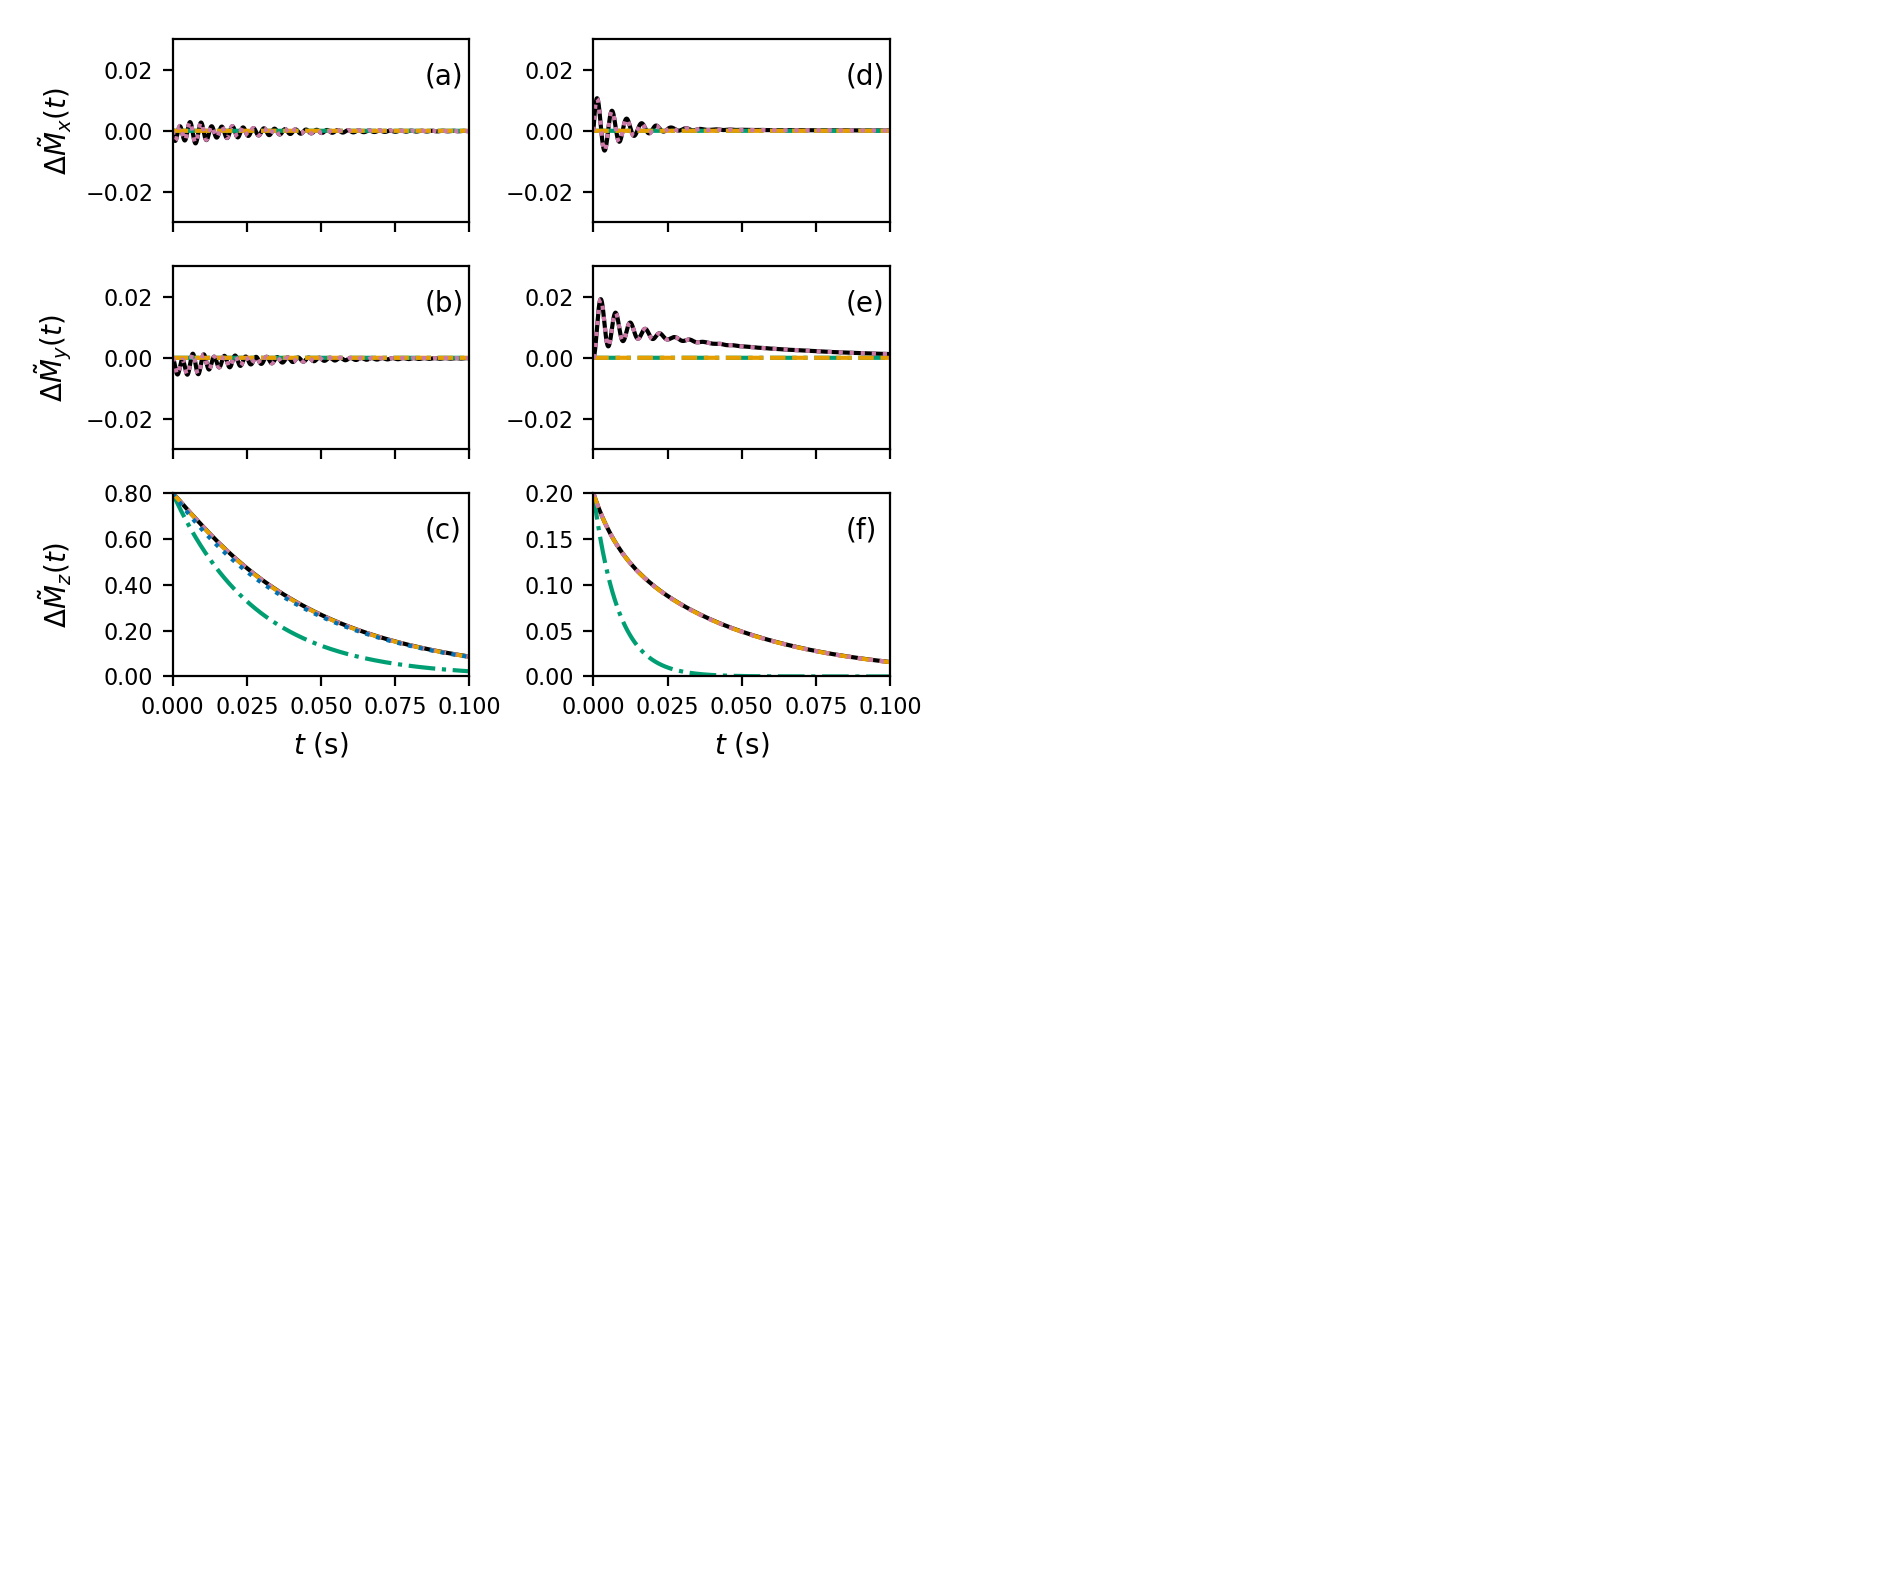

In [141]:
# Coupled evolution (Figure 1)

fig, ((ax1, ax4), (ax2,ax5) ,(ax3,ax6)) = plt.subplots(3, 2, 
                        figsize=(12/2.54,10/2.54))
fig.subplots_adjust(hspace=0.15,wspace=0.1,top=1.0,bottom=0.0)

ymax = 0.03
ymin = -0.03

ax1.plot(tbloch,np.real(mt[:,0]),c='black')
ax1.plot(t,np.real(mtr1rho0[0,:]),c=green,ls='-.')
ax1.plot(t,np.real(mtr1rhoEig0[0,:]),c=orange,ls='dashed')
ax1.plot(t,np.real(mtr1rhoEig1[0,:]),c=reddishpurple,ls='dotted')
ax1.set_xlim(0,tmax)
ax1.set_ylim(ymin,ymax)
tmp=ax1.set_aspect(0.618*tmax/(ymax-ymin))
tmp=ax1.set_xticklabels([])
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_ylabel(r'$\Delta \tilde{M}_x(t)$',fontsize=10)
ax1.text(0.85,0.75,"(a)",transform=ax1.transAxes,fontsize=10)

ax2.plot(tbloch,np.real(mt[:,1]),c='black')
ax2.plot(t,np.real(mtr1rho0[1,:]),c=green,ls='-.')
ax2.plot(t,np.real(mtr1rhoEig0[1,:]),c=orange,ls='dashed')
ax2.plot(t,np.real(mtr1rhoEig1[1,:]),c=reddishpurple,ls='dotted')
ax2.set_xlim(0,tmax)
ax2.set_ylim(ymin,ymax)
tmp=ax2.set_aspect(0.618*tmax/(ymax-ymin))
tmp=ax2.set_xticklabels([])
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.set_ylabel(r'$\Delta \tilde{M}_y(t)$',fontsize=10)
ax2.text(0.85,0.75,"(b)",transform=ax2.transAxes,fontsize=10)

ax3.plot(tbloch,np.real(mt[:,2]),c='black')
ax3.plot(t,np.real(mtr1rho0[2,:]),c=green,ls='-.')
ax3.plot(t,np.real(mtr1rhoEig0[2,:]),c=orange,ls='dashed')
ax3.plot(t,np.real(mtr1rhoEig1[2,:]),c=reddishpurple,ls='dotted')
ax3.plot(t,mTrott*pA,c=blue, ls='dotted')
ax3.set_xlim(0,tmax)
ax3.set_ylim(0,pA)
tmp=ax3.set_aspect(0.618*tmax/pA)
ax3.tick_params(axis='both', which='major', labelsize=8)
ax3.set_xlabel(r'$t$ (s)',fontsize=10)
ax3.set_ylabel(r'$\Delta \tilde{M}_z(t)$',fontsize=10)
ax3.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax3.text(0.85,0.75,"(c)",transform=ax3.transAxes,fontsize=10)

ax4.plot(tbloch,np.real(mt[:,3]),c='black')
ax4.plot(t,np.real(mtr1rho0[3,:]),c=green,ls='-.')
ax4.plot(t,np.real(mtr1rhoEig0[3,:]),c=orange,ls='dashed')
ax4.plot(t,np.real(mtr1rhoEig1[3,:]),c=reddishpurple,ls='dotted')
ax4.set_xlim(0,tmax)
ax4.set_ylim(ymin,ymax)
tmp=ax4.set_aspect(0.618*tmax/(ymax-ymin))
tmp=ax4.set_xticklabels([])
#tmp=ax4.set_yticklabels([])
ax4.tick_params(axis='both', which='major', labelsize=8)
ax4.text(0.85,0.75,"(d)",transform=ax4.transAxes,fontsize=10)

ax5.plot(tbloch,np.real(mt[:,4]),c='black')
ax5.plot(t,np.real(mtr1rho0[4,:]),c=green,ls='-.')
ax5.plot(t,np.real(mtr1rhoEig0[4,:]),c=orange,ls='dashed')
ax5.plot(t,np.real(mtr1rhoEig1[4,:]),c=reddishpurple,ls='dotted')
ax5.set_xlim(0,tmax)
ax5.set_ylim(ymin,ymax)
tmp=ax5.set_aspect(0.618*tmax/(ymax-ymin))
tmp=ax5.set_xticklabels([])
#tmp=ax5.set_yticklabels([])
ax5.tick_params(axis='both', which='major', labelsize=8)
ax5.text(0.85,0.75,"(e)",transform=ax5.transAxes,fontsize=10)

ax6.plot(tbloch,np.real(mt[:,5]),c='black')
ax6.plot(t,np.real(mtr1rho0[5,:]),c=green,ls='-.')
ax6.plot(t,np.real(mtr1rhoEig0[5,:]),c=orange,ls='dashed')
ax6.plot(t,np.real(mtr1rhoEig1[5,:]),c=reddishpurple,ls='dotted')
ax6.set_xlim(0,tmax)
ax6.set_ylim(0.0,pB)
tmp=ax6.set_aspect(0.618*tmax/pB)
#tmp=ax6.set_yticklabels([])
ax6.tick_params(axis='both', which='major', labelsize=8)
ax6.set_xlabel(r'$t$ (s)',fontsize=10)
ax6.text(0.85,0.75,"(f)",transform=ax6.transAxes,fontsize=10)

fig.align_ylabels()

plt.tight_layout()

plt.savefig("Figure1_2x2CoupledEvolution.eps",pad_inches=0)

plt.show()


In [142]:
# independent evolution (Figure 2)
## Centered offest, w1 = dw/2

# initial condition
omA = 0
omB = 2*np.pi*200
rf = 1*np.pi*200
dw = np.abs(omB-omA)

w1 = 0.5*dw

R1A = 1
R2A= 20

R1B = 1
R2B = 20

pA = 0.8
pB = 1-pA
kex = 0.1*dw
km1 = kex*pA
k1 = kex*pB
m0 = np.array([[0],[0],[pA],[0],[0],[pB]])

print(dw,w1,kex)

# time points
tmax = 0.1
npts = 2000
t = np.linspace(0,tmax,npts)

tbloch = np.linspace(0,tmax,npts)
mtr1rho1 = np.zeros([6,npts],complex)
mtr1rho2 = np.zeros([6,npts],complex)

# tilted rotating frame transformations
wA = np.sqrt((omA-rf)**2 + w1**2)
sinthet = w1/wA
costhet = (omA-rf)/wA
RyA = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])
    
wB = np.sqrt((omB-rf)**2 + w1**2)
sinthet = w1/wB
costhet = (omB-rf)/wB
RyB = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])

zero33 = np.zeros([3,3])
RyAll = np.block([
        [RyA,zero33],
        [zero33,RyB]
    ])
RyAllinv = np.linalg.inv(RyAll)
    
u = Utrans()
U = np.block([
        [u,zero33],
        [zero33,u]
    ])

s0 = np.sqrt(np.array([pA,pA,pA,pB,pB,pB]))
S = np.diag(s0)

# Initial value of magnetization in laboratory frame
Experiment = 'R1rho'     # 'CEST' or default to 'R1rho'
PhaseCycle = True

m0LF = RyAll @ m0                                 # initial magnetization in tilted frame for R1rho
if Experiment == 'CEST': 
    m0LF = m0                # initial z-magnetization in lab frame

# Solve ode for Bloch Equation

# Bloch equations constant term in laboratory frame
R1MeqLF = np.array([0,0,pA*R1A,0,0,pB*R1B])

mt =  odeint(bloch2state,m0LF.flatten(),tbloch,rtol = 1.49012e-9, atol=1.49012e-9,
             args=(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,R1MeqLF))
                
if PhaseCycle:
    mtm = odeint(bloch2state,-m0LF.flatten(),tbloch,rtol = 1.49012e-9, atol=1.49012e-9,
                 args=(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,R1MeqLF))
    mt = (mt - mtm)/2

if Experiment != 'CEST':
    for i in range(0,len(tbloch)):
        mt[i,:] = RyAllinv @ mt[i,:]
        
# HAM
c0=-1.0
hamorder = 0

mtr1rho0 = HAMR1r2stateN(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,0,-1,PhaseCycle)
mtr1rhoEig0 = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,0,c0,PhaseCycle)
mtr1rhoEig1 = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,1,c0,PhaseCycle)

for i,val in enumerate(t):
    # transform to tilted frame
    mtr1rho0[:,i] = U @ mtr1rho0[:,i]
    mtr1rhoEig0[:,i] = U @ mtr1rhoEig0[:,i]
    mtr1rhoEig1[:,i] = U @ mtr1rhoEig1[:,i]
    
    # transform to lab frame
    if Experiment == 'CEST':
        mtr1rho0[:,i] = RyAll @ mtr1rho0[:,i]
        mtr1rhoEig0[:,i] = RyAll @ mtr1rhoEig0[:,i]
        mtr1rhoEig1[:,i] = RyAll @ mtr1rhoEig1[:,i]
        
    mtr1rho0[:,i] = S @ mtr1rho0[:,i]
    mtr1rhoEig0[:,i] = S @ mtr1rhoEig0[:,i]
    mtr1rhoEig1[:,i] = S @ mtr1rhoEig1[:,i]
    
print("Trott\t",TrottMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1))
print("Laguerre\t",LaguerreMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1))
print("Invar\t",invariantR1r(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1))
mTrott = np.exp(-t*TrottMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1))
mLaguerre = np.exp(-t*LaguerreMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1))
mInvariant = np.exp(-t*invariantR1r(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1))

mtind = mt

1256.6370614359173 628.3185307179587 125.66370614359174
Trott	 30.336417702224416
Laguerre	 34.230117123537134
Invar	 26.5908944248531


<IPython.core.display.Javascript object>


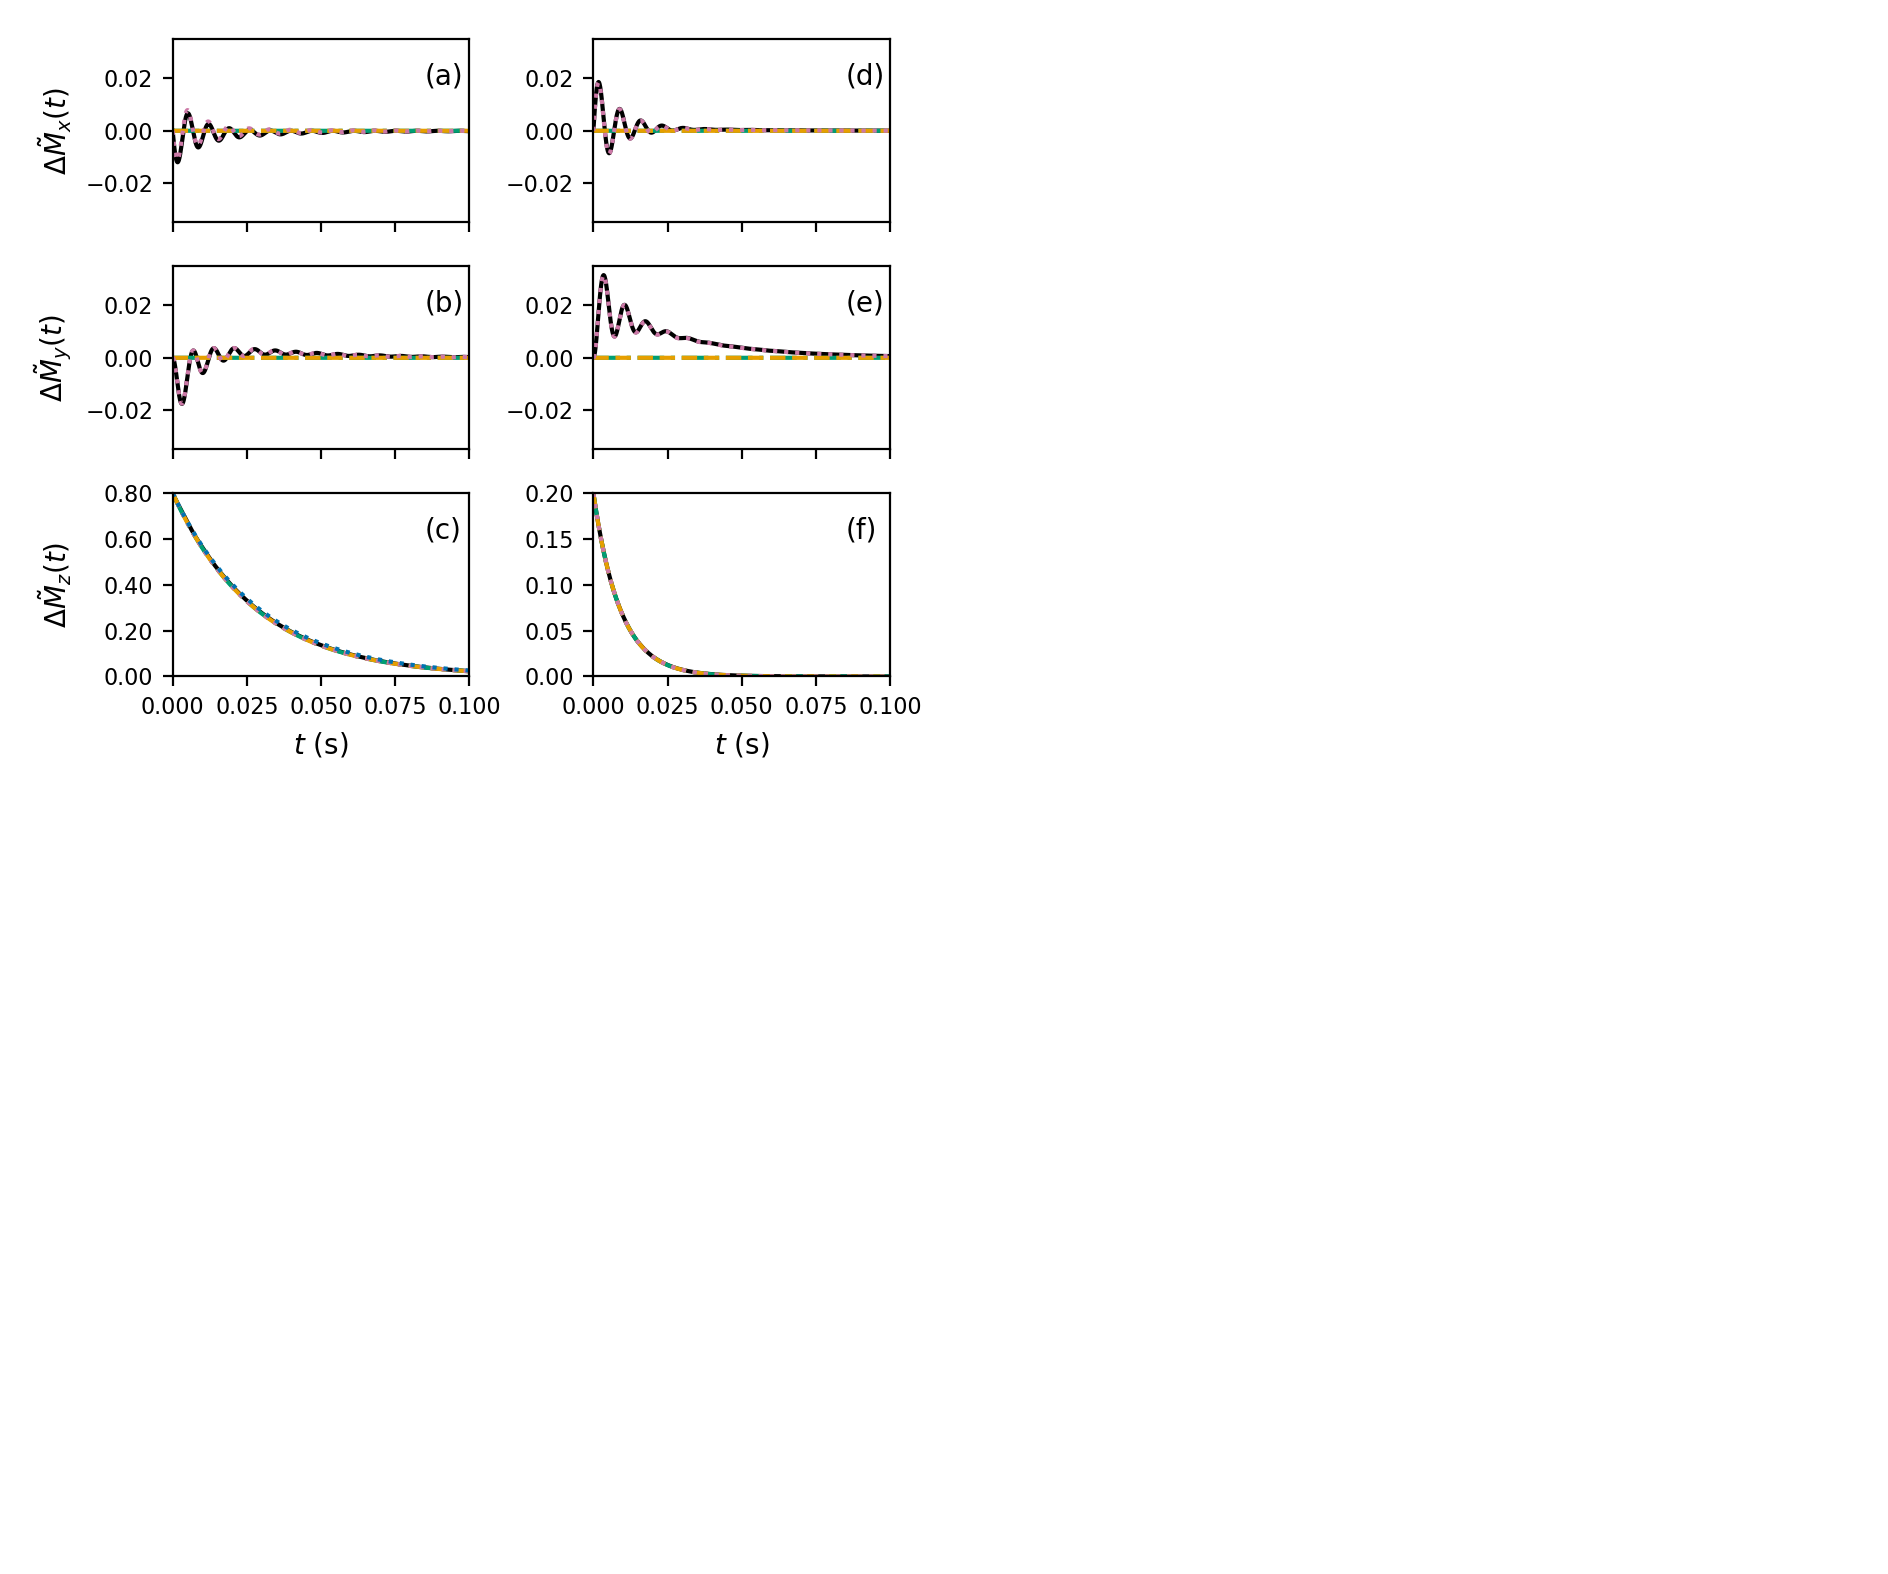

In [143]:
# independent evolution (Figure 2)

fig, ((ax1, ax4), (ax2,ax5) ,(ax3,ax6)) = plt.subplots(3, 2, 
                        figsize=(12/2.54,10/2.54))
fig.subplots_adjust(hspace=0.15,wspace=0.1,top=1.0,bottom=0.0)

ymax = 0.035
ymin = -0.035

ax1.plot(tbloch,np.real(mt[:,0]),c='black')
ax1.plot(t,np.real(mtr1rho0[0,:]),c=green,ls='-.')
ax1.plot(t,np.real(mtr1rhoEig0[0,:]),c=orange,ls='dashed')
ax1.plot(t,np.real(mtr1rhoEig1[0,:]),c=reddishpurple,ls='dotted')
ax1.set_xlim(0,tmax)
ax1.set_ylim(ymin,ymax)
tmp=ax1.set_aspect(0.618*tmax/(ymax-ymin))
tmp=ax1.set_xticklabels([])
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_ylabel(r'$\Delta \tilde{M}_x(t)$',fontsize=10)
ax1.text(0.85,0.75,"(a)",transform=ax1.transAxes,fontsize=10)

ax2.plot(tbloch,np.real(mt[:,1]),c='black')
ax2.plot(t,np.real(mtr1rho0[1,:]),c=green,ls='-.')
ax2.plot(t,np.real(mtr1rhoEig0[1,:]),c=orange,ls='dashed')
ax2.plot(t,np.real(mtr1rhoEig1[1,:]),c=reddishpurple,ls='dotted')
ax2.set_xlim(0,tmax)
ax2.set_ylim(ymin,ymax)
tmp=ax2.set_aspect(0.618*tmax/(ymax-ymin))
tmp=ax2.set_xticklabels([])
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.set_ylabel(r'$\Delta \tilde{M}_y(t)$',fontsize=10)
ax2.text(0.85,0.75,"(b)",transform=ax2.transAxes,fontsize=10)

ax3.plot(tbloch,np.real(mt[:,2]),c='black')
ax3.plot(t,np.real(mtr1rho0[2,:]),c=green,ls='-.')
ax3.plot(t,np.real(mtr1rhoEig0[2,:]),c=orange,ls='dashed')
ax3.plot(t,np.real(mtr1rhoEig1[2,:]),c=reddishpurple,ls='dotted')
ax3.plot(t,mLaguerre*pA,c=blue, ls='dotted')
ax3.set_xlim(0,tmax)
ax3.set_ylim(0,pA)
tmp=ax3.set_aspect(0.618*tmax/pA)
ax3.tick_params(axis='both', which='major', labelsize=8)
ax3.set_xlabel(r'$t$ (s)',fontsize=10)
ax3.set_ylabel(r'$\Delta \tilde{M}_z(t)$',fontsize=10)
ax3.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax3.text(0.85,0.75,"(c)",transform=ax3.transAxes,fontsize=10)

ax4.plot(tbloch,np.real(mt[:,3]),c='black')
ax4.plot(t,np.real(mtr1rho0[3,:]),c=green,ls='-.')
ax4.plot(t,np.real(mtr1rhoEig0[3,:]),c=orange,ls='dashed')
ax4.plot(t,np.real(mtr1rhoEig1[3,:]),c=reddishpurple,ls='dotted')
ax4.set_xlim(0,tmax)
ax4.set_ylim(ymin,ymax)
tmp=ax4.set_aspect(0.618*tmax/(ymax-ymin))
tmp=ax4.set_xticklabels([])
#tmp=ax4.set_yticklabels([])
ax4.tick_params(axis='both', which='major', labelsize=8)
ax4.text(0.85,0.75,"(d)",transform=ax4.transAxes,fontsize=10)

ax5.plot(tbloch,np.real(mt[:,4]),c='black')
ax5.plot(t,np.real(mtr1rho0[4,:]),c=green,ls='-.')
ax5.plot(t,np.real(mtr1rhoEig0[4,:]),c=orange,ls='dashed')
ax5.plot(t,np.real(mtr1rhoEig1[4,:]),c=reddishpurple,ls='dotted')
ax5.set_xlim(0,tmax)
ax5.set_ylim(ymin,ymax)
tmp=ax5.set_aspect(0.618*tmax/(ymax-ymin))
tmp=ax5.set_xticklabels([])
#tmp=ax5.set_yticklabels([])
ax5.tick_params(axis='both', which='major', labelsize=8)
ax5.text(0.85,0.75,"(e)",transform=ax5.transAxes,fontsize=10)

ax6.plot(tbloch,np.real(mt[:,5]),c='black')
ax6.plot(t,np.real(mtr1rho0[5,:]),c=green,ls='-.')
ax6.plot(t,np.real(mtr1rhoEig0[5,:]),c=orange,ls='dashed')
ax6.plot(t,np.real(mtr1rhoEig1[5,:]),c=reddishpurple,ls='dotted')
ax6.set_xlim(0,tmax)
ax6.set_ylim(0.0,pB)
tmp=ax6.set_aspect(0.618*tmax/pB)
#tmp=ax6.set_yticklabels([])
ax6.tick_params(axis='both', which='major', labelsize=8)
ax6.set_xlabel(r'$t$ (s)',fontsize=10)
ax6.text(0.85,0.75,"(f)",transform=ax6.transAxes,fontsize=10)

fig.align_ylabels()

plt.tight_layout()

plt.savefig("Figure2_IndependentEvolution.eps",pad_inches=0)

plt.show()


In [144]:
# Figure 3
# Compare coupled HAM for high and low populations

# initial condition
omA = 0
omB = 2*np.pi*200
rf = 2*np.pi*200
dw = np.abs(omB-omA)

w1 = 0.25*dw

R1A = 1
R2A= 20

R1B = 1
R2B = 20

pA = 0.9
pB = 1-pA
kex = 0.25*dw
km1 = kex*pA
k1 = kex*pB
m0 = np.array([[0],[0],[pA],[0],[0],[pB]])

print(dw,w1,kex)

# time points
tmax = 0.4
npts = 2000
t = np.linspace(0,tmax,npts)

tbloch = np.linspace(0,tmax,npts)
mtr1rho1 = np.zeros([6,npts],complex)
mtr1rho2 = np.zeros([6,npts],complex)

# tilted rotating frame transformations
wA = np.sqrt((omA-rf)**2 + w1**2)
sinthet = w1/wA
costhet = (omA-rf)/wA
RyA = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])
    
wB = np.sqrt((omB-rf)**2 + w1**2)
sinthet = w1/wB
costhet = (omB-rf)/wB
RyB = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])

zero33 = np.zeros([3,3])
RyAll = np.block([
        [RyA,zero33],
        [zero33,RyB]
    ])
RyAllinv = np.linalg.inv(RyAll)
    
u = Utrans()
U = np.block([
        [u,zero33],
        [zero33,u]
    ])

s0 = np.sqrt(np.array([pA,pA,pA,pB,pB,pB]))
S = np.diag(s0)

# Initial value of magnetization in laboratory frame
Experiment = 'R1rho'     # 'CEST' or default to 'R1rho'
PhaseCycle = True

m0LF = RyAll @ m0                                 # initial magnetization in tilted frame for R1rho
if Experiment == 'CEST': 
    m0LF = m0                # initial z-magnetization in lab frame

# Solve ode for Bloch Equation

# Bloch equations constant term in laboratory frame
R1MeqLF = np.array([0,0,pA*R1A,0,0,pB*R1B])

mt =  odeint(bloch2state,m0LF.flatten(),tbloch,rtol = 1.49012e-9, atol=1.49012e-9,
             args=(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,R1MeqLF))
                
if PhaseCycle:
    mtm = odeint(bloch2state,-m0LF.flatten(),tbloch,rtol = 1.49012e-9, atol=1.49012e-9,
                 args=(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,R1MeqLF))
    mt = (mt - mtm)/2

if Experiment != 'CEST':
    for i in range(0,len(tbloch)):
        mt[i,:] = RyAllinv @ mt[i,:]
        
# HAM
c0=-1.0
hamorder = 4
    
mtr1rhoN = HAMR1r2stateN(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,hamorder,c0,PhaseCycle)
mtr1rho0 = HAMR1r2stateN(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,0,c0,PhaseCycle)
mtr1rho1 = HAMR1r2stateN(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,1,c0,PhaseCycle)
mtr1rho2 = HAMR1r2stateN(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,2,c0,PhaseCycle)

mtr1rhoEigN = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,hamorder,c0,PhaseCycle)
mtr1rhoEig0 = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,0,c0,PhaseCycle)
mtr1rhoEig1 = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,1,c0,PhaseCycle)
mtr1rhoEig2 = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,2,c0,PhaseCycle)

for i,val in enumerate(t):
    # transform to tilted frame
    mtr1rho0[:,i] = U @ mtr1rho0[:,i]
    mtr1rho1[:,i] = U @ mtr1rho1[:,i]
    mtr1rho2[:,i] = U @ mtr1rho2[:,i]
    mtr1rhoN[:,i] = U @ mtr1rhoN[:,i]
    mtr1rhoEig0[:,i] = U @ mtr1rhoEig0[:,i]
    mtr1rhoEig1[:,i] = U @ mtr1rhoEig1[:,i]
    mtr1rhoEig2[:,i] = U @ mtr1rhoEig2[:,i]
    mtr1rhoEigN[:,i] = U @ mtr1rhoEigN[:,i]
    
    # transform to lab frame
    if Experiment == 'CEST':
        mtr1rho0[:,i] = RyAll @ mtr1rho0[:,i]
        mtr1rho1[:,i] = RyAll @ mtr1rho1[:,i]
        mtr1rho2[:,i] = RyAll @ mtr1rho2[:,i]
        mtr1rhoN[:,i] = RyAll @ mtr1rhoN[:,i]
        mtr1rhoEig0[:,i] = RyAll @ mtr1rhoEig0[:,i]
        mtr1rhoEig1[:,i] = RyAll @ mtr1rhoEig1[:,i]
        mtr1rhoEig2[:,i] = RyAll @ mtr1rhoEig2[:,i]
        mtr1rhoEigN[:,i] = RyAll @ mtr1rhoEigN[:,i]
        
    mtr1rho0[:,i] = S @ mtr1rho0[:,i]
    mtr1rho1[:,i] = S @ mtr1rho1[:,i]
    mtr1rho2[:,i] = S @ mtr1rho2[:,i]
    mtr1rhoN[:,i] = S @ mtr1rhoN[:,i]
    mtr1rhoEig0[:,i] = S @ mtr1rhoEig0[:,i]
    mtr1rhoEig1[:,i] = S @ mtr1rhoEig1[:,i]
    mtr1rhoEig2[:,i] = S @ mtr1rhoEig2[:,i]
    mtr1rhoEigN[:,i] = S @ mtr1rhoEigN[:,i]
    
RTrott90 = TrottMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1)
RLaguerre90 = LaguerreMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1)

mtr1rhoEigN90 = mtr1rhoEigN
mt90 = mt
t90 = t

1256.6370614359173 314.1592653589793 314.1592653589793


<IPython.core.display.Javascript object>


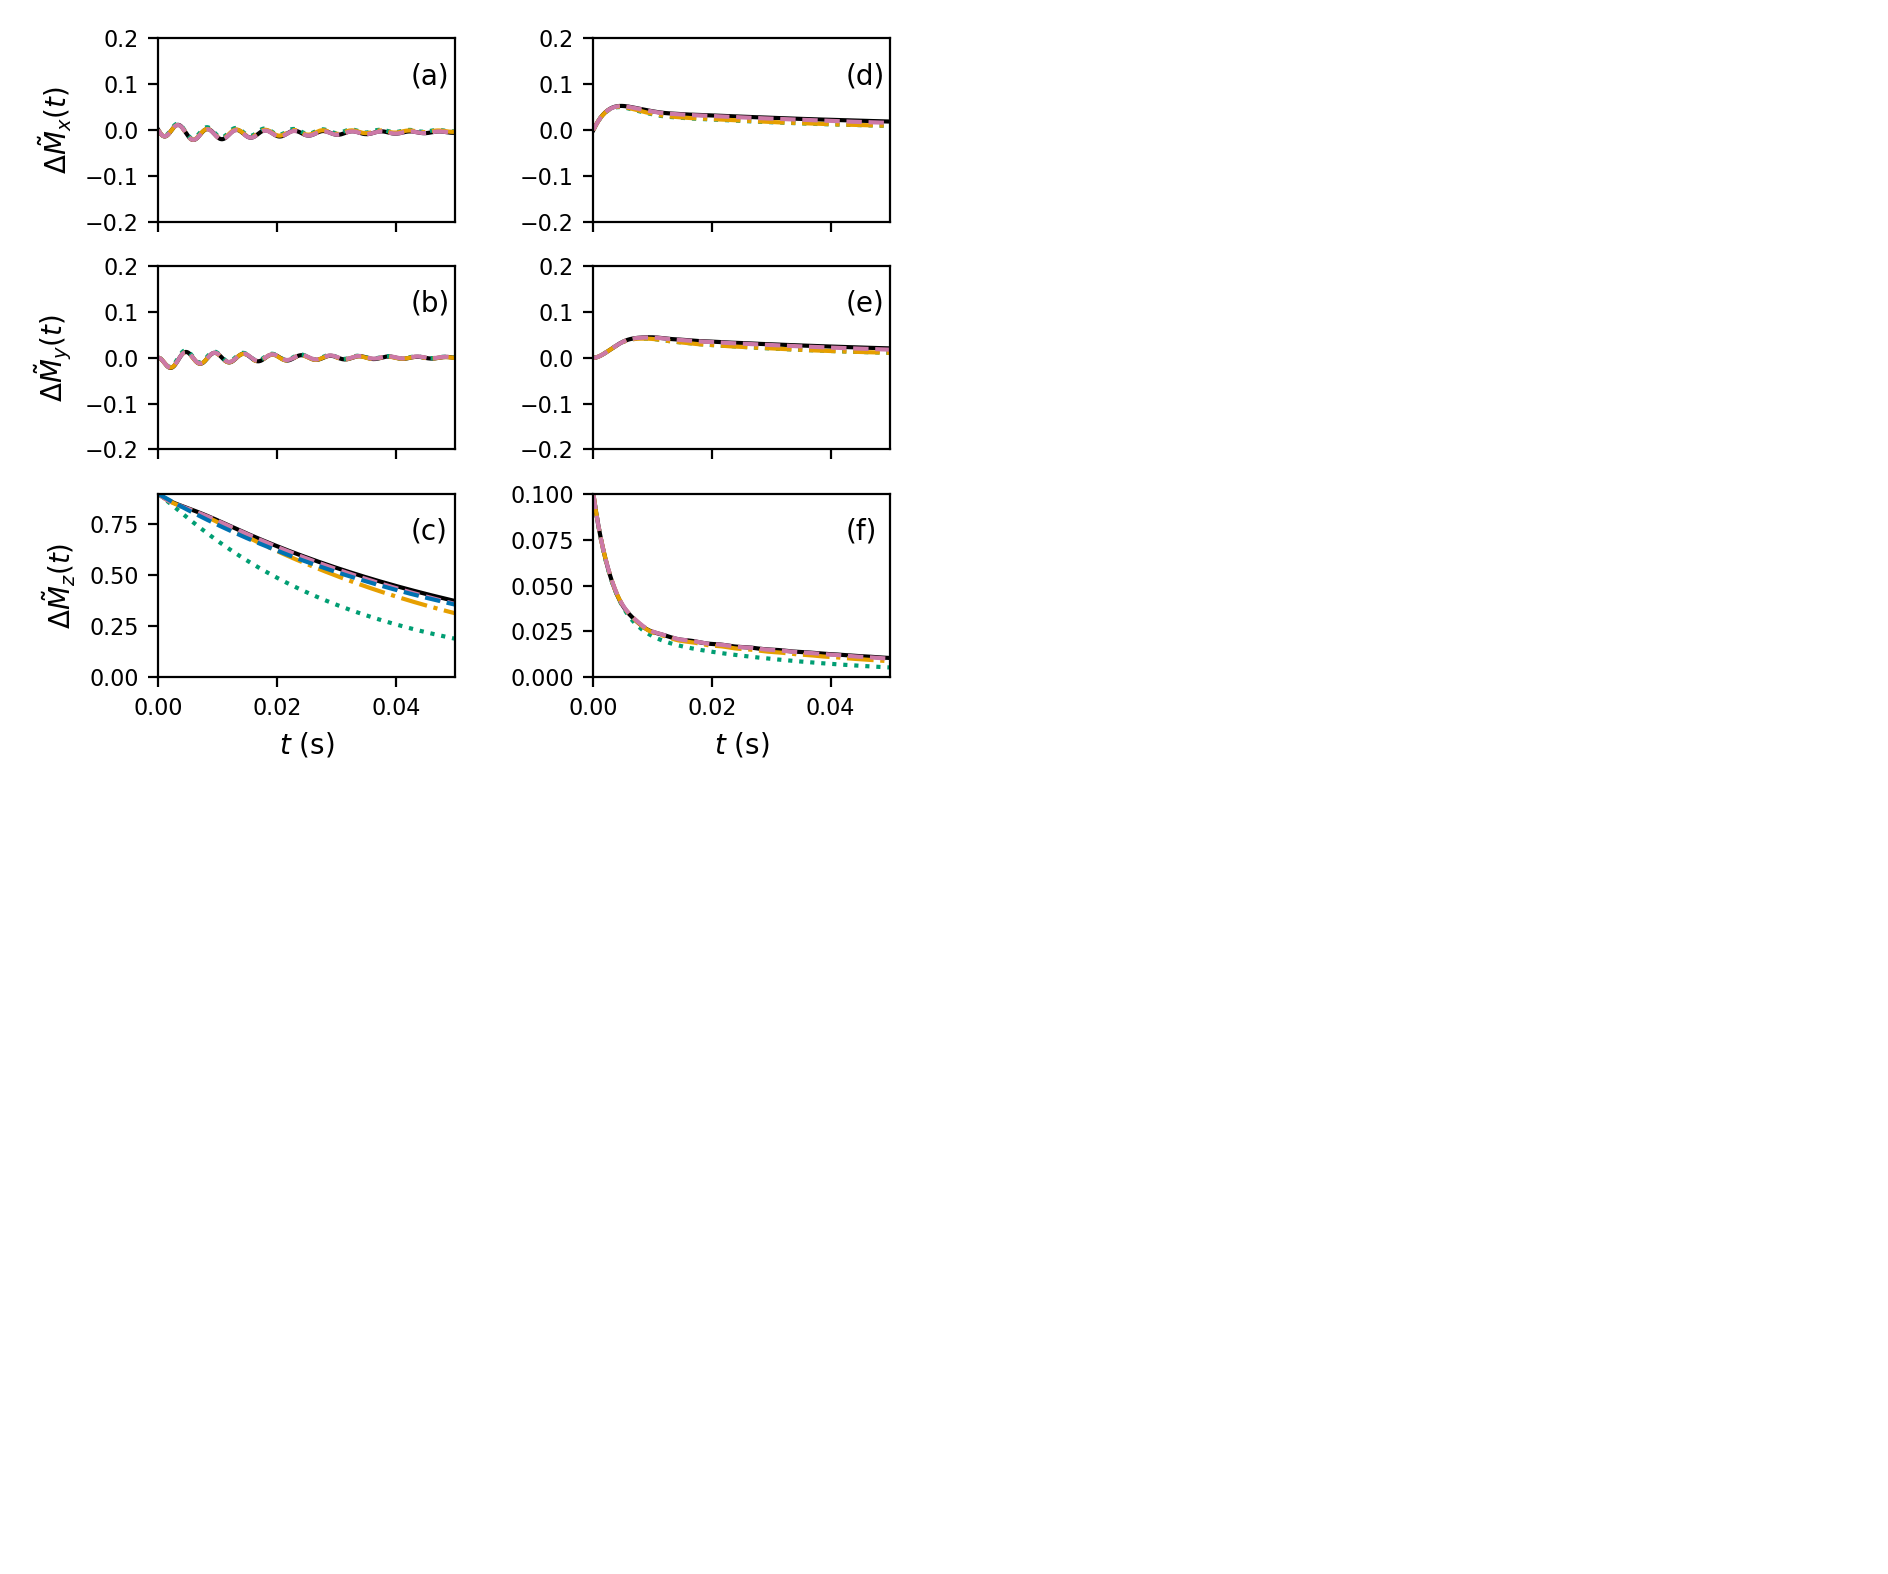

In [145]:
# Compare coupled HAM for high and low populations

fig, ((ax1, ax4), (ax2,ax5) ,(ax3,ax6)) = plt.subplots(3, 2, 
                        figsize=(12/2.54,10/2.54))
fig.subplots_adjust(hspace=0.15,wspace=0.1,top=1.0,bottom=0.0)

ymax = 0.2
ymin = -0.2
xmax = 0.05

ax1.plot(tbloch,np.real(mt[:,0]),c='black')
#ax1.plot(t,np.real(mtr1rhoEig0[0,:]),c=blue,ls='dotted')
ax1.plot(t,np.real(mtr1rhoEig1[0,:]),c=green,ls='dotted')
ax1.plot(t,np.real(mtr1rhoEig2[0,:]),c=orange,ls='-.')
ax1.plot(t,np.real(mtr1rhoEigN[0,:]),c=reddishpurple,ls='dashed')
ax1.set_xlim(0,xmax)
ax1.set_ylim(ymin,ymax)
tmp=ax1.set_aspect(0.618*xmax/(ymax-ymin))
tmp=ax1.set_xticklabels([])
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_ylabel(r'$\Delta \tilde{M}_x(t)$',fontsize=10)
ax1.text(0.85,0.75,"(a)",transform=ax1.transAxes,fontsize=10)

ax2.plot(tbloch,np.real(mt[:,1]),c='black')
#ax2.plot(t,np.real(mtr1rhoEig0[1,:]),c=blue,ls='dotted')
ax2.plot(t,np.real(mtr1rhoEig1[1,:]),c=green,ls='dotted')
ax2.plot(t,np.real(mtr1rhoEig2[1,:]),c=orange,ls='-.')
ax2.plot(t,np.real(mtr1rhoEigN[1,:]),c=reddishpurple,ls='dashed')
ax2.set_xlim(0,xmax)
ax2.set_ylim(ymin,ymax)
tmp=ax2.set_aspect(0.618*xmax/(ymax-ymin))
tmp=ax2.set_xticklabels([])
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.set_ylabel(r'$\Delta \tilde{M}_y(t)$',fontsize=10)
ax2.text(0.85,0.75,"(b)",transform=ax2.transAxes,fontsize=10)

ax3.plot(tbloch,np.real(mt[:,2]),c='black')
#ax3.plot(t,np.real(mtr1rhoEig0[2,:]),c=blue,ls='dotted')
ax3.plot(t,np.real(mtr1rhoEig1[2,:]),c=green,ls='dotted')
ax3.plot(t,np.real(mtr1rhoEig2[2,:]),c=orange,ls='-.')
ax3.plot(t,np.real(mtr1rhoEigN[2,:]),c=reddishpurple,ls='dashed')
ax3.plot(t,pA*np.exp(-RTrott90*t),c=blue,ls='dashed')
ax3.set_xlim(0,xmax)
ax3.set_ylim(0,pA)
tmp=ax3.set_aspect(0.618*xmax/pA)
ax3.tick_params(axis='both', which='major', labelsize=8)
ax3.set_xlabel(r'$t$ (s)',fontsize=10)
ax3.set_ylabel(r'$\Delta \tilde{M}_z(t)$',fontsize=10)
ax3.text(0.85,0.75,"(c)",transform=ax3.transAxes,fontsize=10)

ax4.plot(tbloch,np.real(mt[:,3]),c='black')
#ax4.plot(t,np.real(mtr1rhoEig0[3,:]),c=blue,ls='dotted')
ax4.plot(t,np.real(mtr1rhoEig1[3,:]),c=green,ls='dotted')
ax4.plot(t,np.real(mtr1rhoEig2[3,:]),c=orange,ls='-.')
ax4.plot(t,np.real(mtr1rhoEigN[3,:]),c=reddishpurple,ls='dashed')
ax4.set_xlim(0,xmax)
ax4.set_ylim(ymin,ymax)
tmp=ax4.set_aspect(0.618*xmax/(ymax-ymin))
tmp=ax4.set_xticklabels([])
#tmp=ax4.set_yticklabels([])
ax4.tick_params(axis='both', which='major', labelsize=8)
ax4.text(0.85,0.75,"(d)",transform=ax4.transAxes,fontsize=10)

ax5.plot(tbloch,np.real(mt[:,4]),c='black')
#ax5.plot(t,np.real(mtr1rhoEig0[4,:]),c=blue,ls='dotted')
ax5.plot(t,np.real(mtr1rhoEig1[4,:]),c=green,ls='dotted')
ax5.plot(t,np.real(mtr1rhoEig2[4,:]),c=orange,ls='-.')
ax5.plot(t,np.real(mtr1rhoEigN[4,:]),c=reddishpurple,ls='dashed')
ax5.set_xlim(0,xmax)
ax5.set_ylim(ymin,ymax)
tmp=ax5.set_aspect(0.618*xmax/(ymax-ymin))
tmp=ax5.set_xticklabels([])
#tmp=ax5.set_yticklabels([])
ax5.tick_params(axis='both', which='major', labelsize=8)
ax5.text(0.85,0.75,"(e)",transform=ax5.transAxes,fontsize=10)

ax6.plot(tbloch,np.real(mt[:,5]),c='black')
#ax6.plot(t,np.real(mtr1rhoEig0[5,:]),c=blue,ls='dotted')
ax6.plot(t,np.real(mtr1rhoEig1[5,:]),c=green,ls='dotted')
ax6.plot(t,np.real(mtr1rhoEig2[5,:]),c=orange,ls='-.')
ax6.plot(t,np.real(mtr1rhoEigN[5,:]),c=reddishpurple,ls='dashed')
ax6.set_xlim(0,xmax)
ax6.set_ylim(0.0,pB)
tmp=ax6.set_aspect(0.618*xmax/pB)
#tmp=ax6.set_yticklabels([])
ax6.tick_params(axis='both', which='major', labelsize=8)
ax6.set_xlabel(r'$t$ (s)',fontsize=10)
ax6.text(0.85,0.75,"(f)",transform=ax6.transAxes,fontsize=10)

plt.tight_layout()

#plt.savefig("Figure_coupledHAM_intermediateEXhigh.eps",pad_inches=0)

plt.show()

In [146]:
# Compare coupled HAM for high and low populations

# initial condition
omA = 0
omB = 2*np.pi*200
rf = 2*np.pi*200
dw = np.abs(omB-omA)

w1 = 0.25*dw

R1A = 1
R2A= 20

R1B = 1
R2B = 20

pA = 0.6
pB = 1-pA
kex = 0.25*dw
km1 = kex*pA
k1 = kex*pB
m0 = np.array([[0],[0],[pA],[0],[0],[pB]])

print(dw,w1,kex)

# time points
tmax = 0.4
npts = 2000
t = np.linspace(0,tmax,npts)

tbloch = np.linspace(0,tmax,npts)
mtr1rho1 = np.zeros([6,npts],complex)
mtr1rho2 = np.zeros([6,npts],complex)

# tilted rotating frame transformations
wA = np.sqrt((omA-rf)**2 + w1**2)
sinthet = w1/wA
costhet = (omA-rf)/wA
RyA = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])
    
wB = np.sqrt((omB-rf)**2 + w1**2)
sinthet = w1/wB
costhet = (omB-rf)/wB
RyB = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])

zero33 = np.zeros([3,3])
RyAll = np.block([
        [RyA,zero33],
        [zero33,RyB]
    ])
RyAllinv = np.linalg.inv(RyAll)
    
u = Utrans()
U = np.block([
        [u,zero33],
        [zero33,u]
    ])

s0 = np.sqrt(np.array([pA,pA,pA,pB,pB,pB]))
S = np.diag(s0)

# Initial value of magnetization in laboratory frame
Experiment = 'R1rho'     # 'CEST' or default to 'R1rho'
PhaseCycle = True

m0LF = RyAll @ m0                                 # initial magnetization in tilted frame for R1rho
if Experiment == 'CEST': 
    m0LF = m0                # initial z-magnetization in lab frame

# Solve ode for Bloch Equation

# Bloch equations constant term in laboratory frame
R1MeqLF = np.array([0,0,pA*R1A,0,0,pB*R1B])

mt =  odeint(bloch2state,m0LF.flatten(),tbloch,rtol = 1.49012e-9, atol=1.49012e-9,
             args=(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,R1MeqLF))
                
if PhaseCycle:
    mtm = odeint(bloch2state,-m0LF.flatten(),tbloch,rtol = 1.49012e-9, atol=1.49012e-9,
                 args=(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,R1MeqLF))
    mt = (mt - mtm)/2

if Experiment != 'CEST':
    for i in range(0,len(tbloch)):
        mt[i,:] = RyAllinv @ mt[i,:]
        
# HAM
c0=-1.0
hamorder = 4
    
mtr1rhoN = HAMR1r2stateN(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,hamorder,c0,PhaseCycle)
mtr1rho0 = HAMR1r2stateN(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,0,c0,PhaseCycle)
mtr1rho1 = HAMR1r2stateN(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,1,c0,PhaseCycle)
mtr1rho2 = HAMR1r2stateN(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,2,c0,PhaseCycle)

mtr1rhoEigN = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,hamorder,c0,PhaseCycle)
mtr1rhoEig0 = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,0,c0,PhaseCycle)
mtr1rhoEig1 = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,1,c0,PhaseCycle)
mtr1rhoEig2 = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,2,c0,PhaseCycle)

for i,val in enumerate(t):
    # transform to tilted frame
    mtr1rho0[:,i] = U @ mtr1rho0[:,i]
    mtr1rho1[:,i] = U @ mtr1rho1[:,i]
    mtr1rho2[:,i] = U @ mtr1rho2[:,i]
    mtr1rhoN[:,i] = U @ mtr1rhoN[:,i]
    mtr1rhoEig0[:,i] = U @ mtr1rhoEig0[:,i]
    mtr1rhoEig1[:,i] = U @ mtr1rhoEig1[:,i]
    mtr1rhoEig2[:,i] = U @ mtr1rhoEig2[:,i]
    mtr1rhoEigN[:,i] = U @ mtr1rhoEigN[:,i]
    
    # transform to lab frame
    if Experiment == 'CEST':
        mtr1rho0[:,i] = RyAll @ mtr1rho0[:,i]
        mtr1rho1[:,i] = RyAll @ mtr1rho1[:,i]
        mtr1rho2[:,i] = RyAll @ mtr1rho2[:,i]
        mtr1rhoN[:,i] = RyAll @ mtr1rhoN[:,i]
        mtr1rhoEig0[:,i] = RyAll @ mtr1rhoEig0[:,i]
        mtr1rhoEig1[:,i] = RyAll @ mtr1rhoEig1[:,i]
        mtr1rhoEig2[:,i] = RyAll @ mtr1rhoEig2[:,i]
        mtr1rhoEigN[:,i] = RyAll @ mtr1rhoEigN[:,i]
        
    mtr1rho0[:,i] = S @ mtr1rho0[:,i]
    mtr1rho1[:,i] = S @ mtr1rho1[:,i]
    mtr1rho2[:,i] = S @ mtr1rho2[:,i]
    mtr1rhoN[:,i] = S @ mtr1rhoN[:,i]
    mtr1rhoEig0[:,i] = S @ mtr1rhoEig0[:,i]
    mtr1rhoEig1[:,i] = S @ mtr1rhoEig1[:,i]
    mtr1rhoEig2[:,i] = S @ mtr1rhoEig2[:,i]
    mtr1rhoEigN[:,i] = S @ mtr1rhoEigN[:,i]
    
RTrott60 = TrottMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1)
RLaguerre60 = LaguerreMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1)

mtr1rhoEigN60 = mtr1rhoEigN
mt60 = mt
t60 = t

1256.6370614359173 314.1592653589793 314.1592653589793


<IPython.core.display.Javascript object>


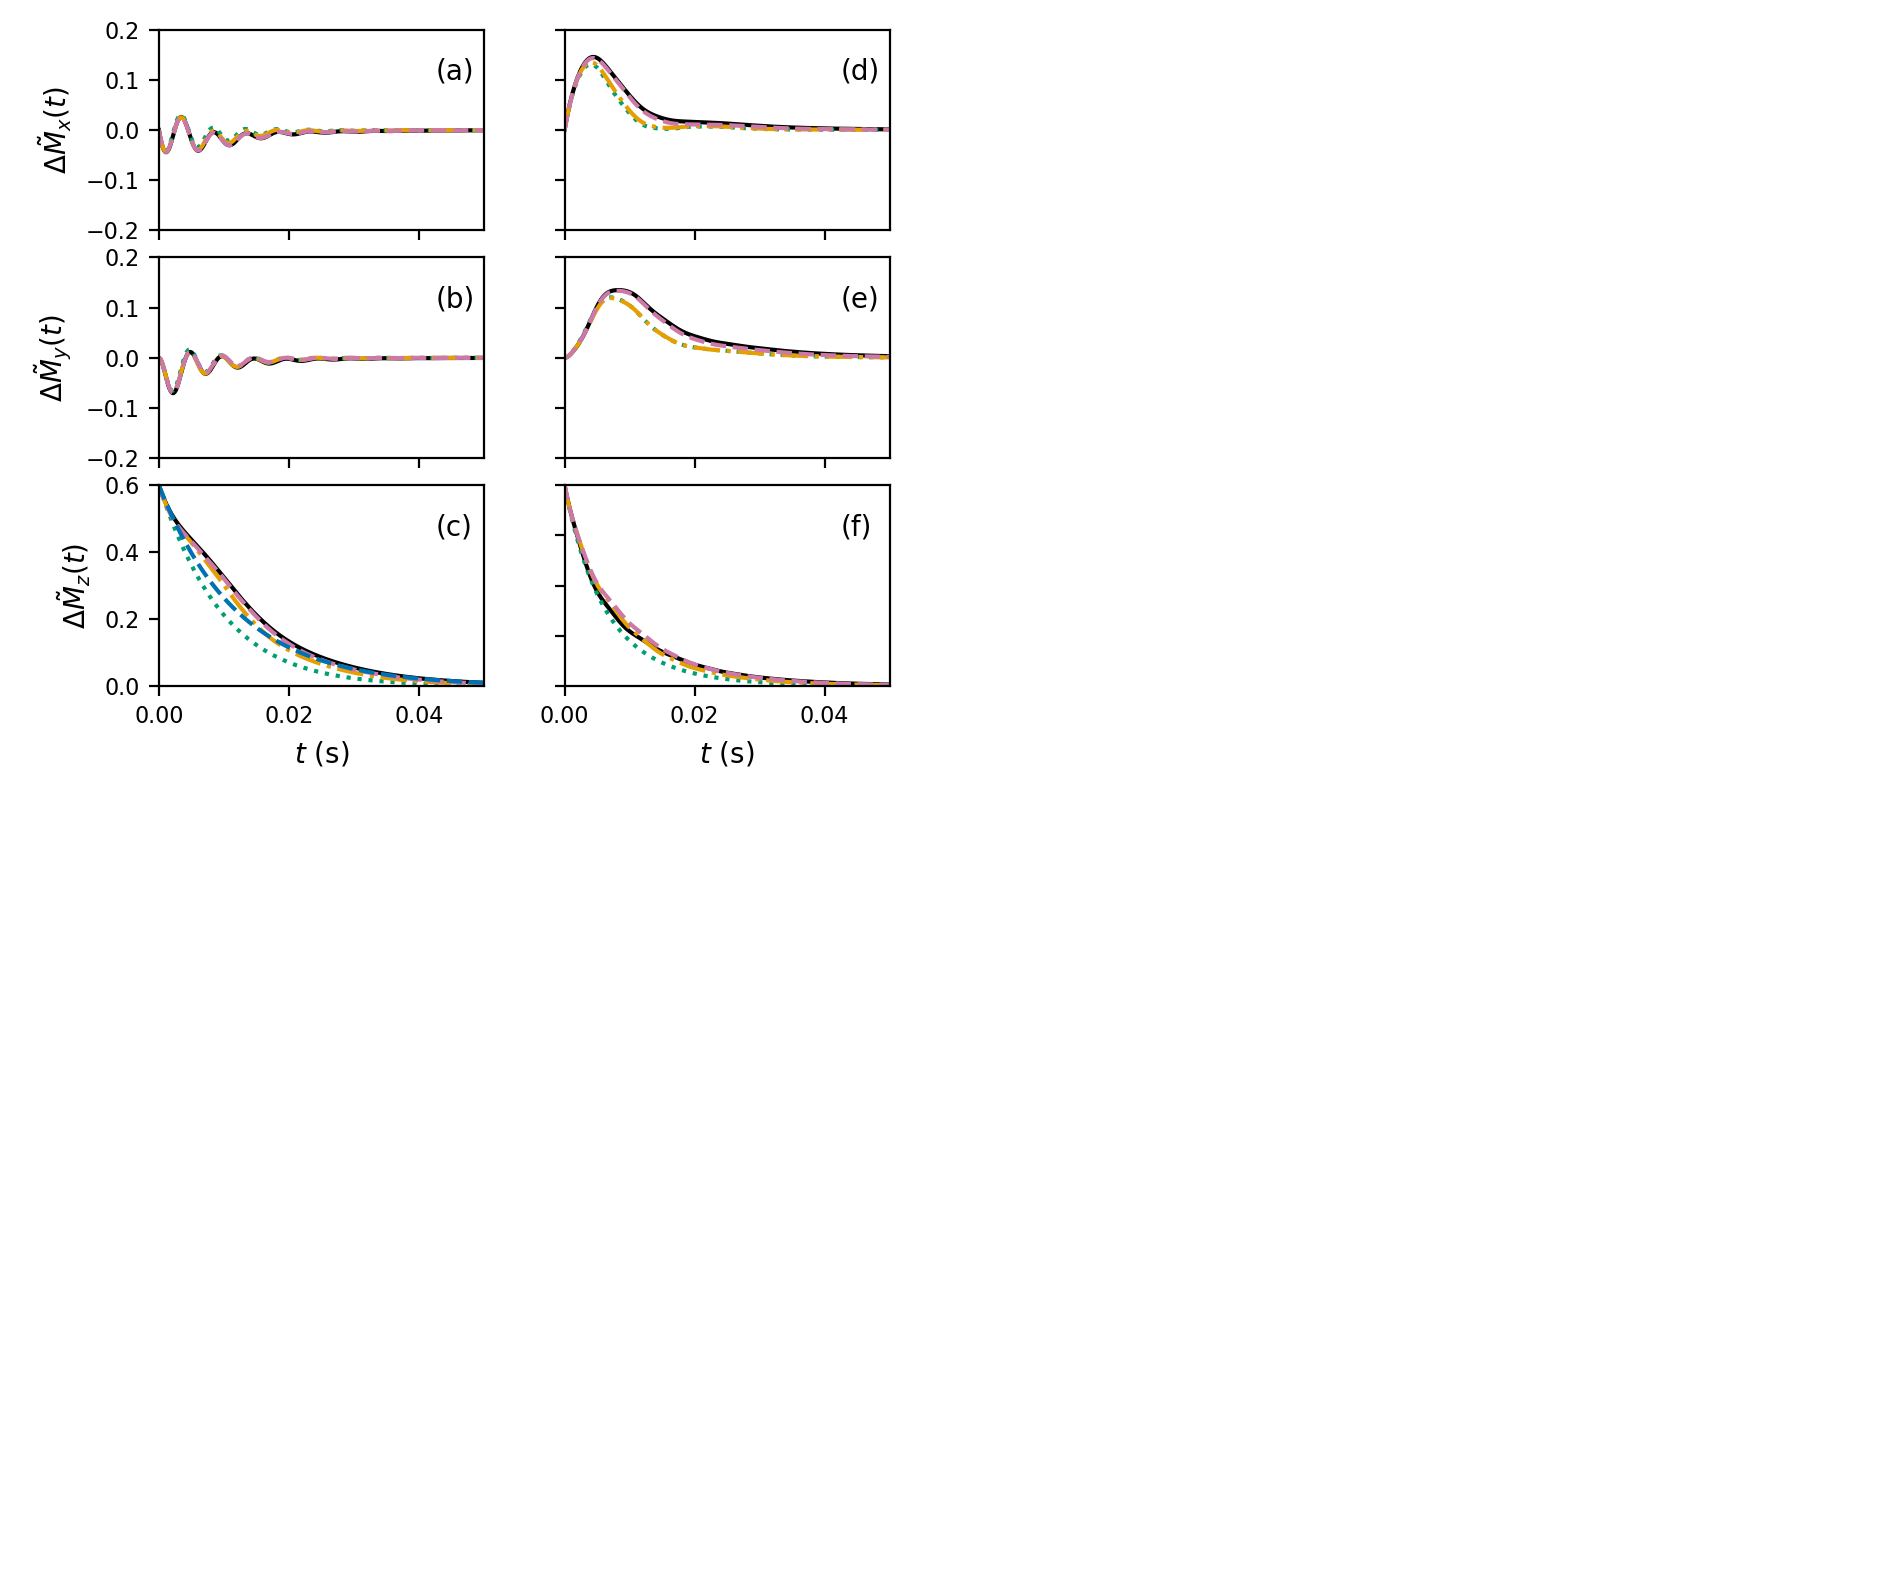

In [147]:
# Compare coupled HAM for intermediate exchange

fig, ((ax1, ax4), (ax2,ax5) ,(ax3,ax6)) = plt.subplots(3, 2, 
                        figsize=(12/2.54,10/2.54))
fig.subplots_adjust(hspace=0.15,wspace=0.1,top=1.0,bottom=0.0)

ymax = 0.2
ymin = -0.2
xmax = 0.05

ax1.plot(tbloch,np.real(mt[:,0]),c='black')
#ax1.plot(t,np.real(mtr1rhoEig0[0,:]),c=blue,ls='dotted')
ax1.plot(t,np.real(mtr1rhoEig1[0,:]),c=green,ls='dotted')
ax1.plot(t,np.real(mtr1rhoEig2[0,:]),c=orange,ls='-.')
ax1.plot(t,np.real(mtr1rhoEigN[0,:]),c=reddishpurple,ls='dashed')
ax1.set_xlim(0,xmax)
ax1.set_ylim(ymin,ymax)
tmp=ax1.set_aspect(0.618*xmax/(ymax-ymin))
tmp=ax1.set_xticklabels([])
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_ylabel(r'$\Delta \tilde{M}_x(t)$',fontsize=10)
ax1.text(0.85,0.75,"(a)",transform=ax1.transAxes,fontsize=10)

ax2.plot(tbloch,np.real(mt[:,1]),c='black')
#ax2.plot(t,np.real(mtr1rhoEig0[1,:]),c=blue,ls='dotted')
ax2.plot(t,np.real(mtr1rhoEig1[1,:]),c=green,ls='dotted')
ax2.plot(t,np.real(mtr1rhoEig2[1,:]),c=orange,ls='-.')
ax2.plot(t,np.real(mtr1rhoEigN[1,:]),c=reddishpurple,ls='dashed')
ax2.set_xlim(0,xmax)
ax2.set_ylim(ymin,ymax)
tmp=ax2.set_aspect(0.618*xmax/(ymax-ymin))
tmp=ax2.set_xticklabels([])
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.set_ylabel(r'$\Delta \tilde{M}_y(t)$',fontsize=10)
ax2.text(0.85,0.75,"(b)",transform=ax2.transAxes,fontsize=10)

ax3.plot(tbloch,np.real(mt[:,2]),c='black')
#ax3.plot(t,np.real(mtr1rhoEig0[2,:]),c=blue,ls='dotted')
ax3.plot(t,np.real(mtr1rhoEig1[2,:]),c=green,ls='dotted')
ax3.plot(t,np.real(mtr1rhoEig2[2,:]),c=orange,ls='-.')
ax3.plot(t,np.real(mtr1rhoEigN[2,:]),c=reddishpurple,ls='dashed')
ax3.plot(t,pA*np.exp(-RLaguerre60*t),c=blue,ls='dashed')
ax3.set_xlim(0,xmax)
ax3.set_ylim(0,pA)
tmp=ax3.set_aspect(0.618*xmax/pA)
ax3.tick_params(axis='both', which='major', labelsize=8)
ax3.set_xlabel(r'$t$ (s)',fontsize=10)
ax3.set_ylabel(r'$\Delta \tilde{M}_z(t)$',fontsize=10)
ax3.text(0.85,0.75,"(c)",transform=ax3.transAxes,fontsize=10)

ax4.plot(tbloch,np.real(mt[:,3]),c='black')
#ax4.plot(t,np.real(mtr1rhoEig0[3,:]),c=blue,ls='dotted')
ax4.plot(t,np.real(mtr1rhoEig1[3,:]),c=green,ls='dotted')
ax4.plot(t,np.real(mtr1rhoEig2[3,:]),c=orange,ls='-.')
ax4.plot(t,np.real(mtr1rhoEigN[3,:]),c=reddishpurple,ls='dashed')
ax4.set_xlim(0,xmax)
ax4.set_ylim(ymin,ymax)
tmp=ax4.set_aspect(0.618*xmax/(ymax-ymin))
tmp=ax4.set_xticklabels([])
tmp=ax4.set_yticklabels([])
ax4.tick_params(axis='both', which='major', labelsize=8)
ax4.text(0.85,0.75,"(d)",transform=ax4.transAxes,fontsize=10)

ax5.plot(tbloch,np.real(mt[:,4]),c='black')
#ax5.plot(t,np.real(mtr1rhoEig0[4,:]),c=blue,ls='dotted')
ax5.plot(t,np.real(mtr1rhoEig1[4,:]),c=green,ls='dotted')
ax5.plot(t,np.real(mtr1rhoEig2[4,:]),c=orange,ls='-.')
ax5.plot(t,np.real(mtr1rhoEigN[4,:]),c=reddishpurple,ls='dashed')
ax5.set_xlim(0,xmax)
ax5.set_ylim(ymin,ymax)
tmp=ax5.set_aspect(0.618*xmax/(ymax-ymin))
tmp=ax5.set_xticklabels([])
tmp=ax5.set_yticklabels([])
ax5.tick_params(axis='both', which='major', labelsize=8)
ax5.text(0.85,0.75,"(e)",transform=ax5.transAxes,fontsize=10)

ax6.plot(tbloch,np.real(mt[:,5]),c='black')
#ax6.plot(t,np.real(mtr1rhoEig0[5,:]),c=blue,ls='dotted')
ax6.plot(t,np.real(mtr1rhoEig1[5,:]),c=green,ls='dotted')
ax6.plot(t,np.real(mtr1rhoEig2[5,:]),c=orange,ls='-.')
ax6.plot(t,np.real(mtr1rhoEigN[5,:]),c=reddishpurple,ls='dashed')
ax6.set_xlim(0,xmax)
ax6.set_ylim(0.0,pB)
tmp=ax6.set_aspect(0.618*xmax/pB)
tmp=ax6.set_yticklabels([])
ax6.tick_params(axis='both', which='major', labelsize=8)
ax6.set_xlabel(r'$t$ (s)',fontsize=10)
ax6.text(0.85,0.75,"(f)",transform=ax6.transAxes,fontsize=10)

plt.tight_layout()

#plt.savefig("Figure3_coupledHAM_intermediateEXhigh.eps",pad_inches=0)

plt.show()

19.32667239095649 18.517941206847187 20.012345318288588
76.61434488082413 60.043802838765515 82.41177823019243


<IPython.core.display.Javascript object>


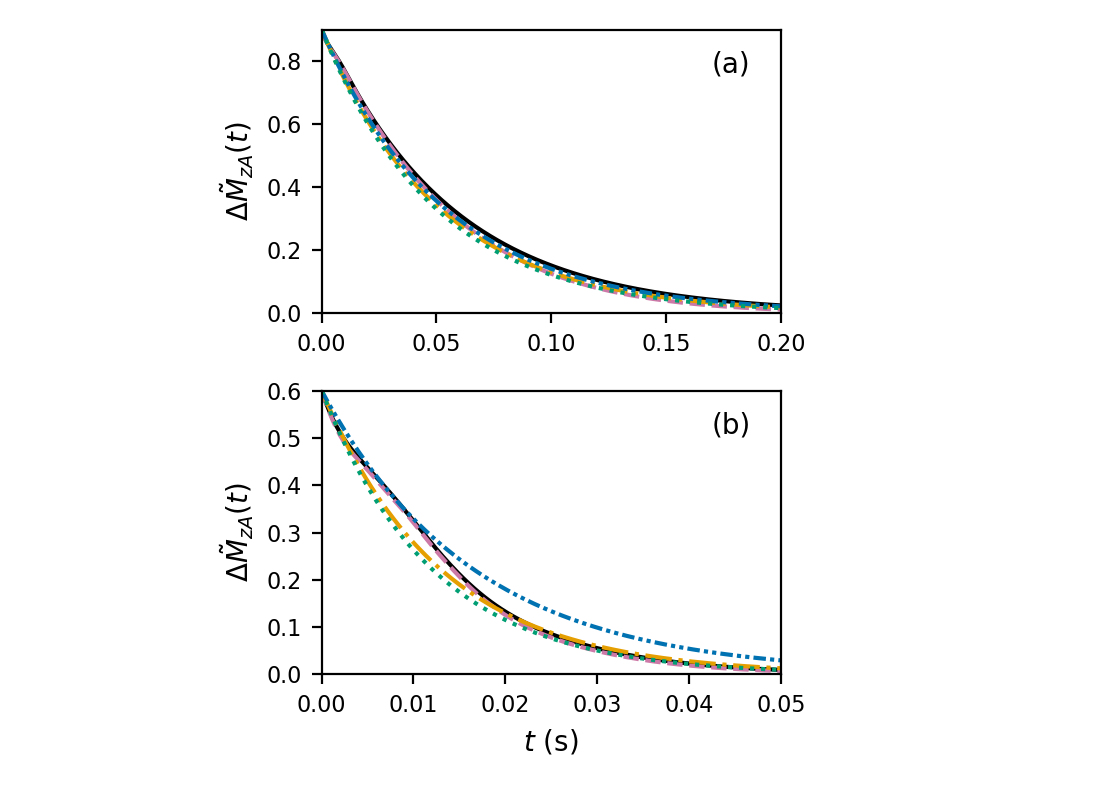

In [148]:
# Plot z-magnetizations (Figure 3)

dt = np.mean(t[1:]-t[0:-1])

temp = np.real(mtr1rhoEigN90[2,:])
Rexint = (np.sum(2*temp) - temp[0] - temp[-1])/temp[0]
Rexint = Rexint*dt/2
Rexint90 = 1/Rexint
print(Rexint90,RTrott90,RLaguerre90)

temp = np.real(mtr1rhoEigN60[2,:])
Rexint = (np.sum(2*temp) - temp[0] - temp[-1])/temp[0]
Rexint = Rexint*dt/2
Rexint60 = 1/Rexint
print(Rexint60,RTrott60,RLaguerre60)


fig, ((ax1, ax2)) = plt.subplots(2, 1, 
                        figsize=(14/2.54,10/2.54))
fig.subplots_adjust(hspace=0.15,wspace=0.1,top=1.0,bottom=0.0)

ymax = 0.1
ymin = -0.1

paa = 0.9
xmax = 0.2

ax1.plot(tbloch,np.real(mt90[:,2]),c='black')
ax1.plot(t,np.real(mtr1rhoEigN90[2,:]),c=reddishpurple,ls='dashed')
ax1.plot(t,paa*np.exp(-Rexint90*t),c=orange,ls='-.')
ax1.plot(t,paa*np.exp(-RTrott90*t),c=blue,ls=linestyles_dict['densely dashdotdotted'])
ax1.plot(t,paa*np.exp(-RLaguerre90*t),c=green,ls='dotted')
ax1.set_xlim(0,xmax)
ax1.set_ylim(0,paa)
tmp=ax1.set_aspect(0.618*xmax/paa)
#tmp=ax1.set_xticklabels([])
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_ylabel(r'$\Delta \tilde{M}_{zA}(t)$',fontsize=10)
ax1.text(0.85,0.85,"(a)",transform=ax1.transAxes,fontsize=10)

paa = 0.6
xmax = 0.05
ax2.plot(tbloch,np.real(mt60[:,2]),c='black')
ax2.plot(t,np.real(mtr1rhoEigN60[2,:]),c=reddishpurple,ls='dashed')
ax2.plot(t,paa*np.exp(-Rexint60*t),c=orange,ls='-.')
ax2.plot(t,paa*np.exp(-RTrott60*t),c=blue,ls=linestyles_dict['densely dashdotdotted'])
ax2.plot(t,paa*np.exp(-RLaguerre60*t),c=green,ls='dotted')
ax2.set_xlim(0,xmax)
ax2.set_ylim(0,paa)
tmp=ax2.set_aspect(0.618*xmax/paa)
#tmp=ax2.set_xticklabels([])
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.set_ylabel(r'$\Delta \tilde{M}_{zA}(t)$',fontsize=10)
ax2.set_xlabel(r'$t$ (s)',fontsize=10)
ax2.text(0.85,0.85,"(b)",transform=ax2.transAxes,fontsize=10)

plt.tight_layout()

plt.savefig("Figure3_coupledHAM_highlowpopulations.eps",pad_inches=0)

plt.show()

In [161]:
# Mz evolution, Laplace approximation (Figure 4) 

# initial condition
omA = 0
omB = 2*np.pi*200
rf = 0*np.pi*200
dw = np.abs(omB-omA)

w1 = 0.5*dw

R1A = 1
R2A= 20

R1B = 1
R2B = 20

pA = 0.8
pB = 1-pA
kex = dw
km1 = kex*pA
k1 = kex*pB
m0 = np.array([[0],[0],[pA],[0],[0],[pB]])

print("pA \t",pA)
print("Dw \t",dw)
print("w1 \t",w1)
print("wrf\t",rf)
print("kex\t",kex)

# time points
tmax = 0.1
npts = 2000
t = np.linspace(0,tmax,npts)
tbloch = np.linspace(0,tmax,npts)

# tilted rotating frame transformations
wA = np.sqrt((omA-rf)**2 + w1**2)
sinthet = w1/wA
costhet = (omA-rf)/wA
RyA = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])
    
wB = np.sqrt((omB-rf)**2 + w1**2)
sinthet = w1/wB
costhet = (omB-rf)/wB
RyB = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])

zero33 = np.zeros([3,3])
RyAll = np.block([
        [RyA,zero33],
        [zero33,RyB]
    ])
RyAllinv = np.linalg.inv(RyAll)
    
u = Utrans()
U = np.block([
        [u,zero33],
        [zero33,u]
    ])

s0 = np.sqrt(np.array([pA,pA,pA,pB,pB,pB]))
S = np.diag(s0)

# Initial value of magnetization in laboratory frame
Experiment = 'R1rho'     # 'CEST' or default to 'R1rho'
PhaseCycle = True

m0LF = RyAll @ m0                                 # initial magnetization in tilted frame for R1rho
if Experiment == 'CEST': 
    m0LF = m0                # initial z-magnetization in lab frame

# Solve ode for Bloch Equation

# Bloch equations constant term in laboratory frame
R1MeqLF = np.array([0,0,pA*R1A,0,0,pB*R1B])

mt =  odeint(bloch2state,m0LF.flatten(),tbloch,rtol = 1.49012e-9, atol=1.49012e-9,
             args=(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,R1MeqLF))
                
if PhaseCycle:
    mtm = odeint(bloch2state,-m0LF.flatten(),tbloch,rtol = 1.49012e-9, atol=1.49012e-9,
                 args=(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,R1MeqLF))
    mt = (mt - mtm)/2

if Experiment != 'CEST':
    for i in range(0,len(tbloch)):
        mt[i,:] = RyAllinv @ mt[i,:]

MzLap0,MzLap,LapEig0,LapEig = MzLaplace(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t)
MzHAM = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,3,-1,PhaseCycle)

s00 = np.sqrt(np.array([pA,pB]))
SLap = np.diag(s00)
s00 = np.sqrt(np.array([pA,pB,pA,pB,pA,pB]))
SPower = np.diag(s00)

for i,val in enumerate(t):
    MzLap0[:,i] = SLap @ MzLap0[:,i]
    MzLap[:,i] = SLap @ MzLap[:,i]
    
    MzHAM[:,i] = U @ MzHAM[:,i]
    MzHAM[:,i] = S @ MzHAM[:,i]

CartL = BMCcartesian(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1)
eigCartL = np.linalg.eig(CartL)[0]

eigCartLz = np.zeros(2)
j = 0
for i,val in enumerate(eigCartL):
    if np.imag(val) == 0:
        eigCartLz[j] = np.abs(val)
        j = j+1
eigCartLz = np.sort(eigCartLz)
print("\n")
print("Eigenvalues\t",eigCartLz[0],"\t",eigCartLz[1])

print("Laplace 0  \t",LapEig0[0],"\t",LapEig0[1])
print("Laplace    \t",LapEig[0],"\t",LapEig[1])
TrottRate1 = TrottMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1)
LaguerreRate1 = LaguerreMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1)
print("Trott      \t",TrottRate1)
print("Miloushev  \t",LaguerreRate1)


mt1 = mt
MzLap1 = MzLap
MzLap01 = MzLap0

pA 	 0.8
Dw 	 1256.6370614359173
w1 	 628.3185307179587
wrf	 0.0
kex	 1256.6370614359173


Eigenvalues	 118.64891309524008 	 1216.3480140866616
Laplace 0  	 107.22564614262365 	 875.4465153282733
Laplace    	 118.0610315943511 	 1666.5177442135348
Trott      	 100.38818665134718
Miloushev  	 116.94127533058693


In [162]:
# Mz evolution, Laplace approximation (Figure 4) 

# initial condition
omA = 0
omB = 2*np.pi*200
rf = np.pi*200
dw = np.abs(omB-omA)

w1 = 0.5*dw

R1A = 1
R2A= 20

R1B = 1
R2B = 20

pA = 0.8
pB = 1-pA
kex = dw
km1 = kex*pA
k1 = kex*pB
m0 = np.array([[0],[0],[pA],[0],[0],[pB]])

print("pA \t",pA)
print("Dw \t",dw)
print("w1 \t",w1)
print("wrf\t",rf)
print("kex\t",kex)

# time points
tmax = 0.1
npts = 2000
t = np.linspace(0,tmax,npts)
tbloch = np.linspace(0,tmax,npts)

# tilted rotating frame transformations
wA = np.sqrt((omA-rf)**2 + w1**2)
sinthet = w1/wA
costhet = (omA-rf)/wA
RyA = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])
    
wB = np.sqrt((omB-rf)**2 + w1**2)
sinthet = w1/wB
costhet = (omB-rf)/wB
RyB = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])

zero33 = np.zeros([3,3])
RyAll = np.block([
        [RyA,zero33],
        [zero33,RyB]
    ])
RyAllinv = np.linalg.inv(RyAll)
    
u = Utrans()
U = np.block([
        [u,zero33],
        [zero33,u]
    ])

s0 = np.sqrt(np.array([pA,pA,pA,pB,pB,pB]))
S = np.diag(s0)

# Initial value of magnetization in laboratory frame
Experiment = 'R1rho'     # 'CEST' or default to 'R1rho'
PhaseCycle = True

m0LF = RyAll @ m0                                 # initial magnetization in tilted frame for R1rho
if Experiment == 'CEST': 
    m0LF = m0                # initial z-magnetization in lab frame

# Solve ode for Bloch Equation

# Bloch equations constant term in laboratory frame
R1MeqLF = np.array([0,0,pA*R1A,0,0,pB*R1B])

mt =  odeint(bloch2state,m0LF.flatten(),tbloch,rtol = 1.49012e-9, atol=1.49012e-9,
             args=(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,R1MeqLF))
                
if PhaseCycle:
    mtm = odeint(bloch2state,-m0LF.flatten(),tbloch,rtol = 1.49012e-9, atol=1.49012e-9,
                 args=(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,R1MeqLF))
    mt = (mt - mtm)/2

if Experiment != 'CEST':
    for i in range(0,len(tbloch)):
        mt[i,:] = RyAllinv @ mt[i,:]

MzLap0,MzLap,LapEig0,LapEig = MzLaplace(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t)
MzHAM = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,2,-1,PhaseCycle)

s00 = np.sqrt(np.array([pA,pB]))
SLap = np.diag(s00)
s00 = np.sqrt(np.array([pA,pB,pA,pB,pA,pB]))

for i,val in enumerate(t):
    MzLap0[:,i] = SLap @ MzLap0[:,i]
    MzLap[:,i] = SLap @ MzLap[:,i]
    
    MzHAM[:,i] = U @ MzHAM[:,i]
    MzHAM[:,i] = S @ MzHAM[:,i]

CartL = BMCcartesian(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1)
eigCartL = np.linalg.eig(CartL)[0]
eigCartLz = np.zeros(2)
j = 0
for i,val in enumerate(eigCartL):
    if np.imag(val) == 0:
        eigCartLz[j] = np.abs(val)
        j = j+1
eigCartLz = np.sort(eigCartLz)
print("\n")
print("Eigenvalues\t",eigCartLz[0],"\t",eigCartLz[1])

print("Laplace 0  \t",LapEig0[0],"\t",LapEig0[1])
print("Laplace    \t",LapEig[0],"\t",LapEig[1])
TrottRate2 = TrottMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1)
LaguerreRate2 = LaguerreMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1)
print("Trott      \t",TrottRate2)
print("Miloushev  \t",LaguerreRate2)

mt2 = mt
MzLap02 = MzLap0
MzLap2 = MzLap

pA 	 0.8
Dw 	 1256.6370614359173
w1 	 628.3185307179587
wrf	 628.3185307179587
kex	 1256.6370614359173


Eigenvalues	 118.9366376005842 	 1164.0343897028072
Laplace 0  	 104.42905996351556 	 874.4066427884652
Laplace    	 118.63183170731759 	 1443.8667644160346
Trott      	 95.69573297870622
Miloushev  	 114.74124657254


In [163]:
# Mz evolution, Laplace approximation (Figure 5) 

# initial condition
omA = 0
omB = 2*np.pi*200
rf = 2*np.pi*200
dw = np.abs(omB-omA)

w1 = 0.5*dw

R1A = 1
R2A= 20

R1B = 1
R2B = 20

pA = 0.8
pB = 1-pA
kex = dw
km1 = kex*pA
k1 = kex*pB
m0 = np.array([[0],[0],[pA],[0],[0],[pB]])

print("pA \t",pA)
print("Dw \t",dw)
print("w1 \t",w1)
print("wrf\t",rf)
print("kex\t",kex)

# time points
tmax = 0.1
npts = 2000
t = np.linspace(0,tmax,npts)
tbloch = np.linspace(0,tmax,npts)

# tilted rotating frame transformations
wA = np.sqrt((omA-rf)**2 + w1**2)
sinthet = w1/wA
costhet = (omA-rf)/wA
RyA = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])
    
wB = np.sqrt((omB-rf)**2 + w1**2)
sinthet = w1/wB
costhet = (omB-rf)/wB
RyB = np.array([[costhet,0,sinthet],[0,1,0],[-sinthet,0,costhet]])

zero33 = np.zeros([3,3])
RyAll = np.block([
        [RyA,zero33],
        [zero33,RyB]
    ])
RyAllinv = np.linalg.inv(RyAll)
    
u = Utrans()
U = np.block([
        [u,zero33],
        [zero33,u]
    ])

s0 = np.sqrt(np.array([pA,pA,pA,pB,pB,pB]))
S = np.diag(s0)

# Initial value of magnetization in laboratory frame
Experiment = 'R1rho'     # 'CEST' or default to 'R1rho'
PhaseCycle = True

m0LF = RyAll @ m0                                 # initial magnetization in tilted frame for R1rho
if Experiment == 'CEST': 
    m0LF = m0                # initial z-magnetization in lab frame

# Solve ode for Bloch Equation

# Bloch equations constant term in laboratory frame
R1MeqLF = np.array([0,0,pA*R1A,0,0,pB*R1B])

mt =  odeint(bloch2state,m0LF.flatten(),tbloch,rtol = 1.49012e-9, atol=1.49012e-9,
             args=(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,R1MeqLF))
                
if PhaseCycle:
    mtm = odeint(bloch2state,-m0LF.flatten(),tbloch,rtol = 1.49012e-9, atol=1.49012e-9,
                 args=(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,R1MeqLF))
    mt = (mt - mtm)/2

if Experiment != 'CEST':
    for i in range(0,len(tbloch)):
        mt[i,:] = RyAllinv @ mt[i,:]

MzLap0,MzLap,LapEig0,LapEig = MzLaplace(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t)
MzHAM = HAMR1r2stateCtransform(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1,t,m0LF,3,-1,PhaseCycle)

s00 = np.sqrt(np.array([pA,pB]))
SLap = np.diag(s00)
s00 = np.sqrt(np.array([pA,pB,pA,pB,pA,pB]))

for i,val in enumerate(t):
    MzLap0[:,i] = SLap @ MzLap0[:,i]
    MzLap[:,i] = SLap @ MzLap[:,i]
    
    MzHAM[:,i] = U @ MzHAM[:,i]
    MzHAM[:,i] = S @ MzHAM[:,i]

CartL = BMCcartesian(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1)
eigCartL = np.linalg.eig(CartL)[0]

eigCartLz = np.zeros(2)
j = 0
for i,val in enumerate(eigCartL):
    if np.imag(val) == 0:
        eigCartLz[j] = np.abs(val)
        j = j+1
eigCartLz = np.sort(eigCartLz)
print("\n")
print("Eigenvalues\t",eigCartLz[0],"\t",eigCartLz[1])

print("Laplace 0  \t",LapEig0[0],"\t",LapEig0[1])
print("Laplace    \t",LapEig[0],"\t",LapEig[1])
TrottRate3 = TrottMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1)
LaguerreRate3 = LaguerreMod(omA-rf,R1A,R2A,omB-rf,R1B,R2B,w1,k1,km1)
print("Trott      \t",TrottRate3)
print("Miloushev  \t",LaguerreRate3)

mt3 = mt
MzLap03 = MzLap0
MzLap3 = MzLap


pA 	 0.8
Dw 	 1256.6370614359173
w1 	 628.3185307179587
wrf	 1256.6370614359173
kex	 1256.6370614359173


Eigenvalues	 52.160647790142264 	 1175.1444251463442
Laplace 0  	 48.69933850107566 	 1068.1735821379743
Laplace    	 52.155542229118964 	 1236.8061362969836
Trott      	 49.64081701242135
Miloushev  	 53.843466879823126


<IPython.core.display.Javascript object>


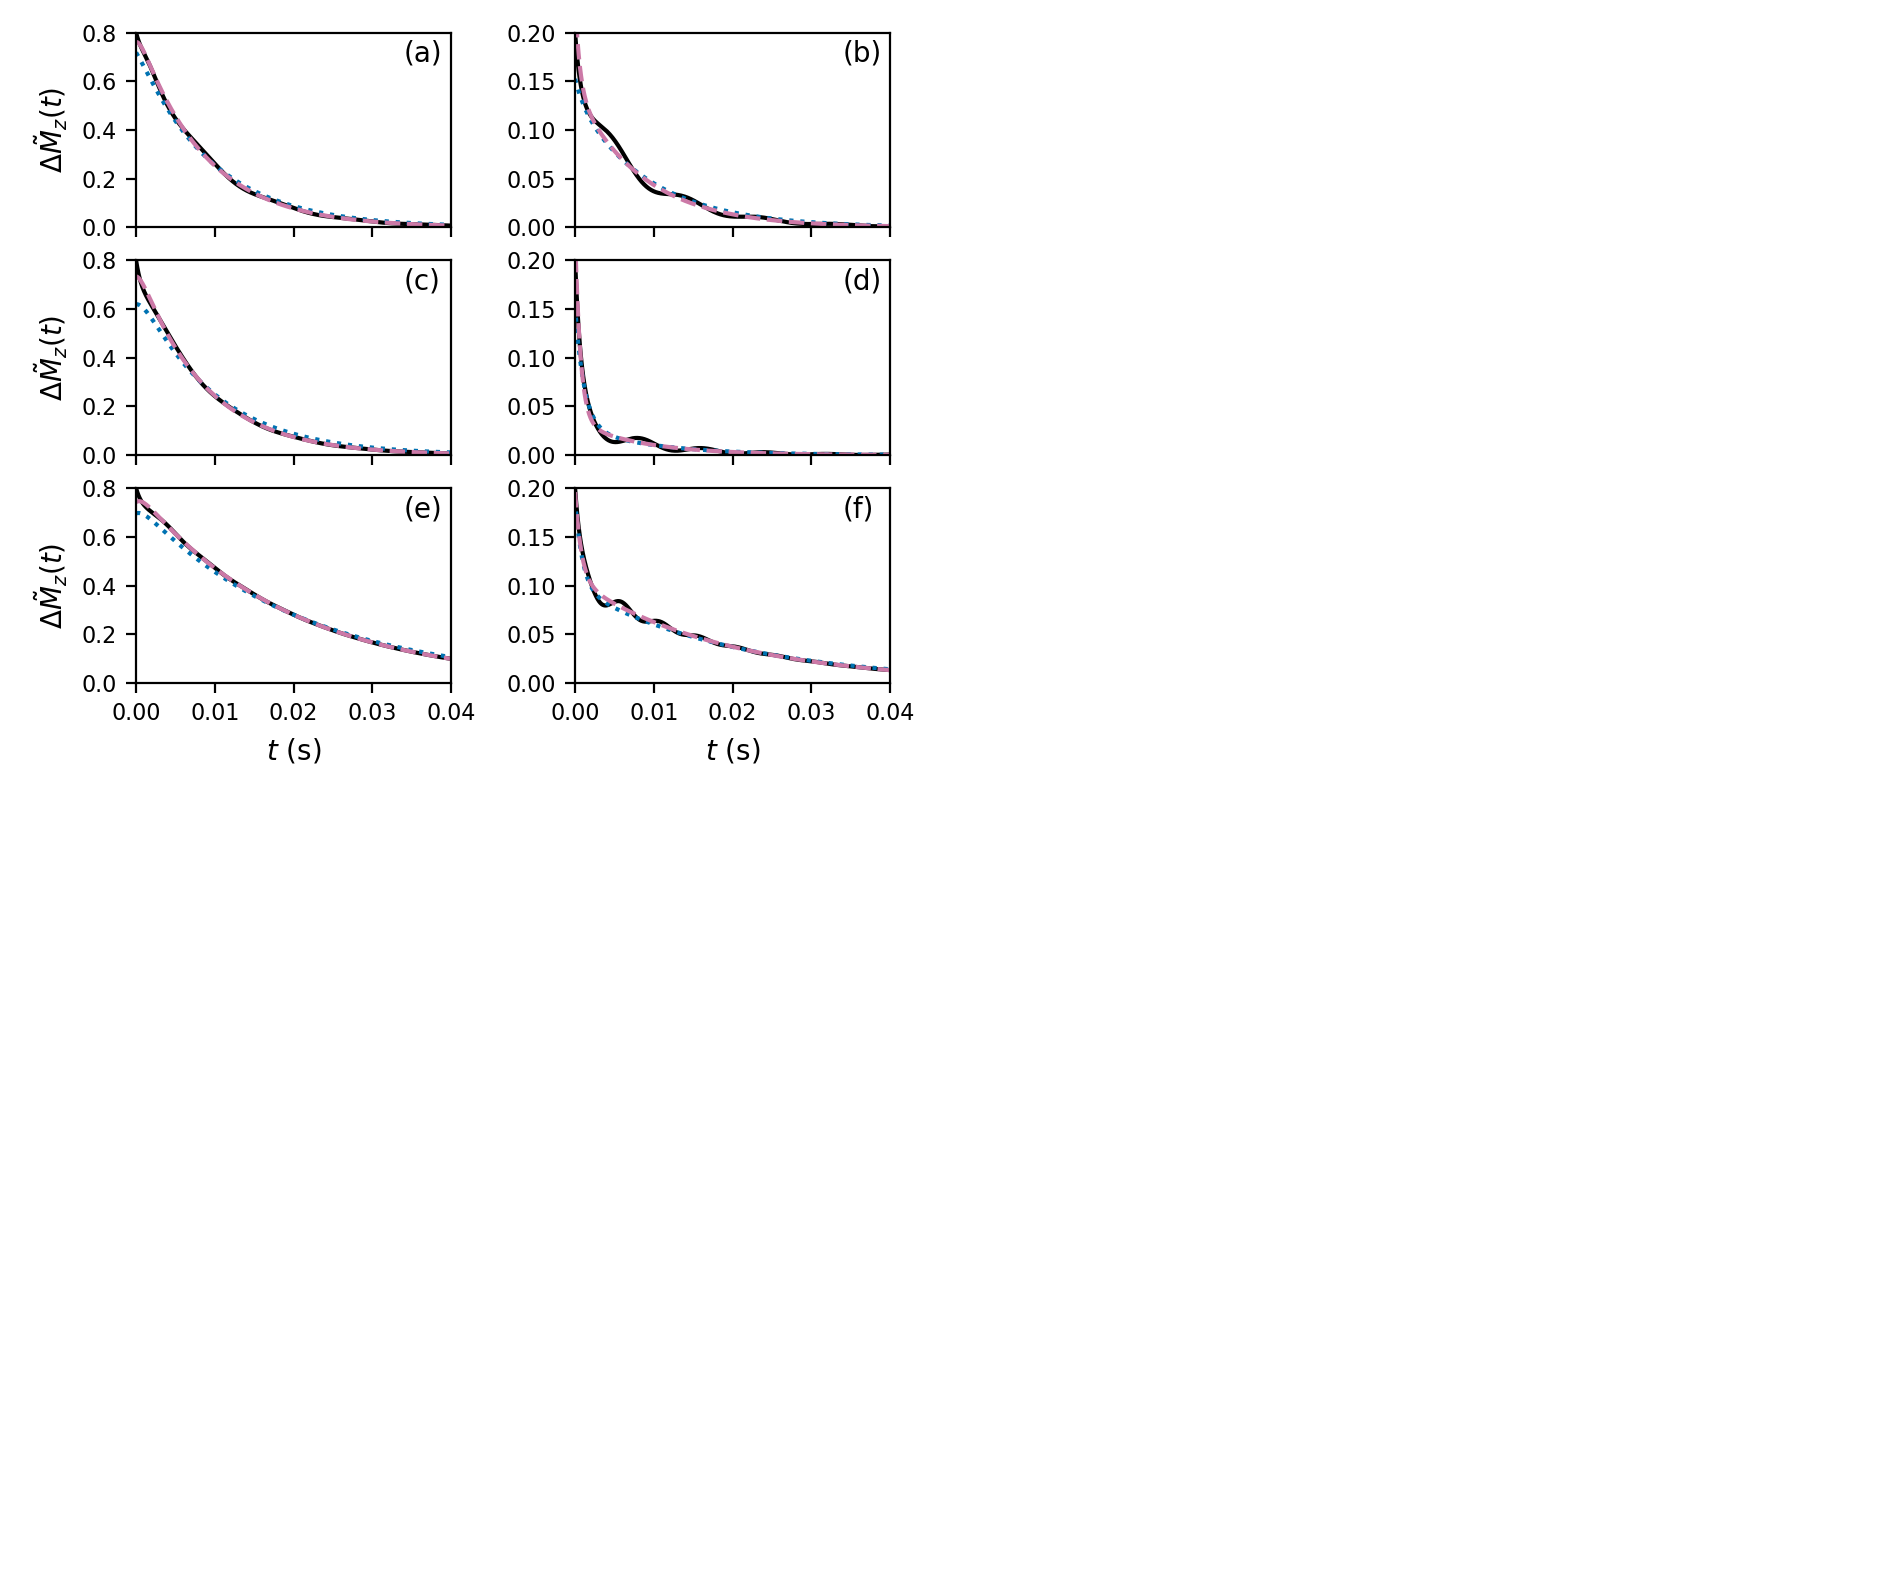

In [168]:
# Figure 4

fig, ((ax1, ax2), (ax3,ax4) ,(ax5,ax6)) = plt.subplots(3, 2, 
                        figsize=(12/2.54,10/2.54))
fig.subplots_adjust(hspace=0.15,wspace=0.1,top=1.0,bottom=0.0)

dt = np.mean(t[1:]-t[0:-1])
xmax = 0.04

ax1.plot(tbloch,np.real(mt1[:,2]),c='black')
#ax1.plot(t,np.real(MzPower1[0,:]),c=orange,ls='dotted')
ax1.plot(t,np.real(MzLap01[0,:]),c=blue,ls='dotted')
ax1.plot(t,np.real(MzLap1[0,:]),c=reddishpurple,ls='dashed')
ax1.set_xlim(0,xmax)
ax1.set_ylim(0,pA)
tmp=ax1.set_aspect(0.618*xmax/pA)
tmp=ax1.set_xticklabels([])
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_ylabel(r'$\Delta \tilde{M}_{z}(t)$',fontsize=10)
ax1.text(0.85,0.85,"(a)",transform=ax1.transAxes,fontsize=10)

ax2.plot(tbloch,np.real(mt1[:,5]),c='black')
#ax2.plot(t,np.real(MzPower1[1,:]),c=orange,ls='dotted')
ax2.plot(t,np.real(MzLap01[1,:]),c=blue,ls='dotted')
ax2.plot(t,np.real(MzLap1[1,:]),c=reddishpurple,ls='dashed')
ax2.set_xlim(0,xmax)
ax2.set_ylim(0,pB)
tmp=ax2.set_aspect(0.618*xmax/pB)
tmp=ax2.set_xticklabels([])
ax2.tick_params(axis='both', which='major', labelsize=8)
#ax2.set_ylabel(r'$M_{zB}(t)$',fontsize=10)
#ax2.set_xlabel(r'$t$ (s)',fontsize=10)
ax2.text(0.85,0.85,"(b)",transform=ax2.transAxes,fontsize=10)

ax3.plot(tbloch,np.real(mt2[:,2]),c='black')
#ax3.plot(t,np.real(MzPower2[0,:]),c=orange,ls='dotted')
ax3.plot(t,np.real(MzLap02[0,:]),c=blue,ls='dotted')
ax3.plot(t,np.real(MzLap2[0,:]),c=reddishpurple,ls='dashed')
ax3.set_xlim(0,xmax)
ax3.set_ylim(0,pA)
tmp=ax3.set_aspect(0.618*xmax/pA)
tmp=ax3.set_xticklabels([])
ax3.tick_params(axis='both', which='major', labelsize=8)
ax3.set_ylabel(r'$\Delta \tilde{M}_{z}(t)$',fontsize=10)
ax3.text(0.85,0.85,"(c)",transform=ax3.transAxes,fontsize=10)

ax4.plot(tbloch,np.real(mt2[:,5]),c='black')
#ax4.plot(t,np.real(MzPower2[1,:]),c=orange,ls='dotted')
ax4.plot(t,np.real(MzLap02[1,:]),c=blue,ls='dotted')
ax4.plot(t,np.real(MzLap2[1,:]),c=reddishpurple,ls='dashed')
ax4.set_xlim(0,xmax)
ax4.set_ylim(0,pB)
tmp=ax4.set_aspect(0.618*xmax/(pB))
tmp=ax4.set_xticklabels([])
ax4.tick_params(axis='both', which='major', labelsize=8)
#ax4.set_ylabel(r'$M_{zB}(t)$',fontsize=10)
ax4.text(0.85,0.85,"(d)",transform=ax4.transAxes,fontsize=10)

ax5.plot(tbloch,np.real(mt3[:,2]),c='black')
#ax5.plot(t,np.real(MzPower3[0,:]),c=orange,ls='dotted')
ax5.plot(t,np.real(MzLap03[0,:]),c=blue,ls='dotted')
ax5.plot(t,np.real(MzLap3[0,:]),c=reddishpurple,ls='dashed')
ax5.set_xlim(0,xmax)
ax5.set_ylim(0,pA)
tmp=ax5.set_aspect(0.618*xmax/pA)
#tmp=ax5.set_xticklabels([])
ax5.tick_params(axis='both', which='major', labelsize=8)
ax5.set_ylabel(r'$\Delta \tilde{M}_{z}(t)$',fontsize=10)
ax5.set_xlabel(r'$t$ (s)',fontsize=10)
ax5.text(0.85,0.85,"(e)",transform=ax5.transAxes,fontsize=10)

ax6.plot(tbloch,np.real(mt3[:,5]),c='black')
#ax6.plot(t,np.real(MzPower3[1,:]),c=orange,ls='dotted')
ax6.plot(t,np.real(MzLap03[1,:]),c=blue,ls='dotted')
ax6.plot(t,np.real(MzLap3[1,:]),c=reddishpurple,ls='dashed')
ax6.set_xlim(0,xmax)
ax6.set_ylim(0,pB)
tmp=ax6.set_aspect(0.618*xmax/pB)
#tmp=ax6.set_xticklabels([])
ax6.tick_params(axis='both', which='major', labelsize=8)
#ax6.set_ylabel(r'$M_{zB}(t)$',fontsize=10)
ax6.set_xlabel(r'$t$ (s)',fontsize=10)
ax6.text(0.85,0.85,"(f)",transform=ax6.transAxes,fontsize=10)

fig.align_ylabels()

plt.tight_layout()

plt.savefig("Figure4_MzLaplace.eps",pad_inches=0)

plt.show()

Rates 12.56637061435917 113.09733552923257 125.66370614359174
Frequencies 0.0 200.0 19.999999999999996 

Offset from omA
Optimal Slow w1, wrf 99.81942558540186 99.81942558540186
R1r0,R1rSlow,R1rIdeal 10.496207949658222 22.903445539902606 23.062578564017393
Optimal Int w1, wrf 98.85961559526726 98.85961559526726
R1r0,R1rInt,R1rIdeal 10.476055041486415 39.38260835738819 41.89198157738434
Slow angles 135.0 44.89653859400733 90.10346140599268
Int angles  135.0 44.34663618769203 90.65336381230797 



Offset from ombar
Optimal Slow w1, wrf 102.43232440954908 102.43232440954908
R1r0,R1rSlow,R1rIdeal 9.302919297547335 21.14948100740892 21.869289911906506
Optimal Int w1, wrf 100.19196546452821 100.19196546452821
R1r0,R1rInt,R1rIdeal 9.222503553023403 37.07017125751542 40.63843008892133
Slow angles 140.082649381911 52.86489012027816 87.21775926163285
Int angles 140.1854290662651 51.4608819698176 88.7245470964475 



Slow offset, R1r 206.2089512556945 41.87645796116317
Int offset, R1r  200.768079

<IPython.core.display.Javascript object>


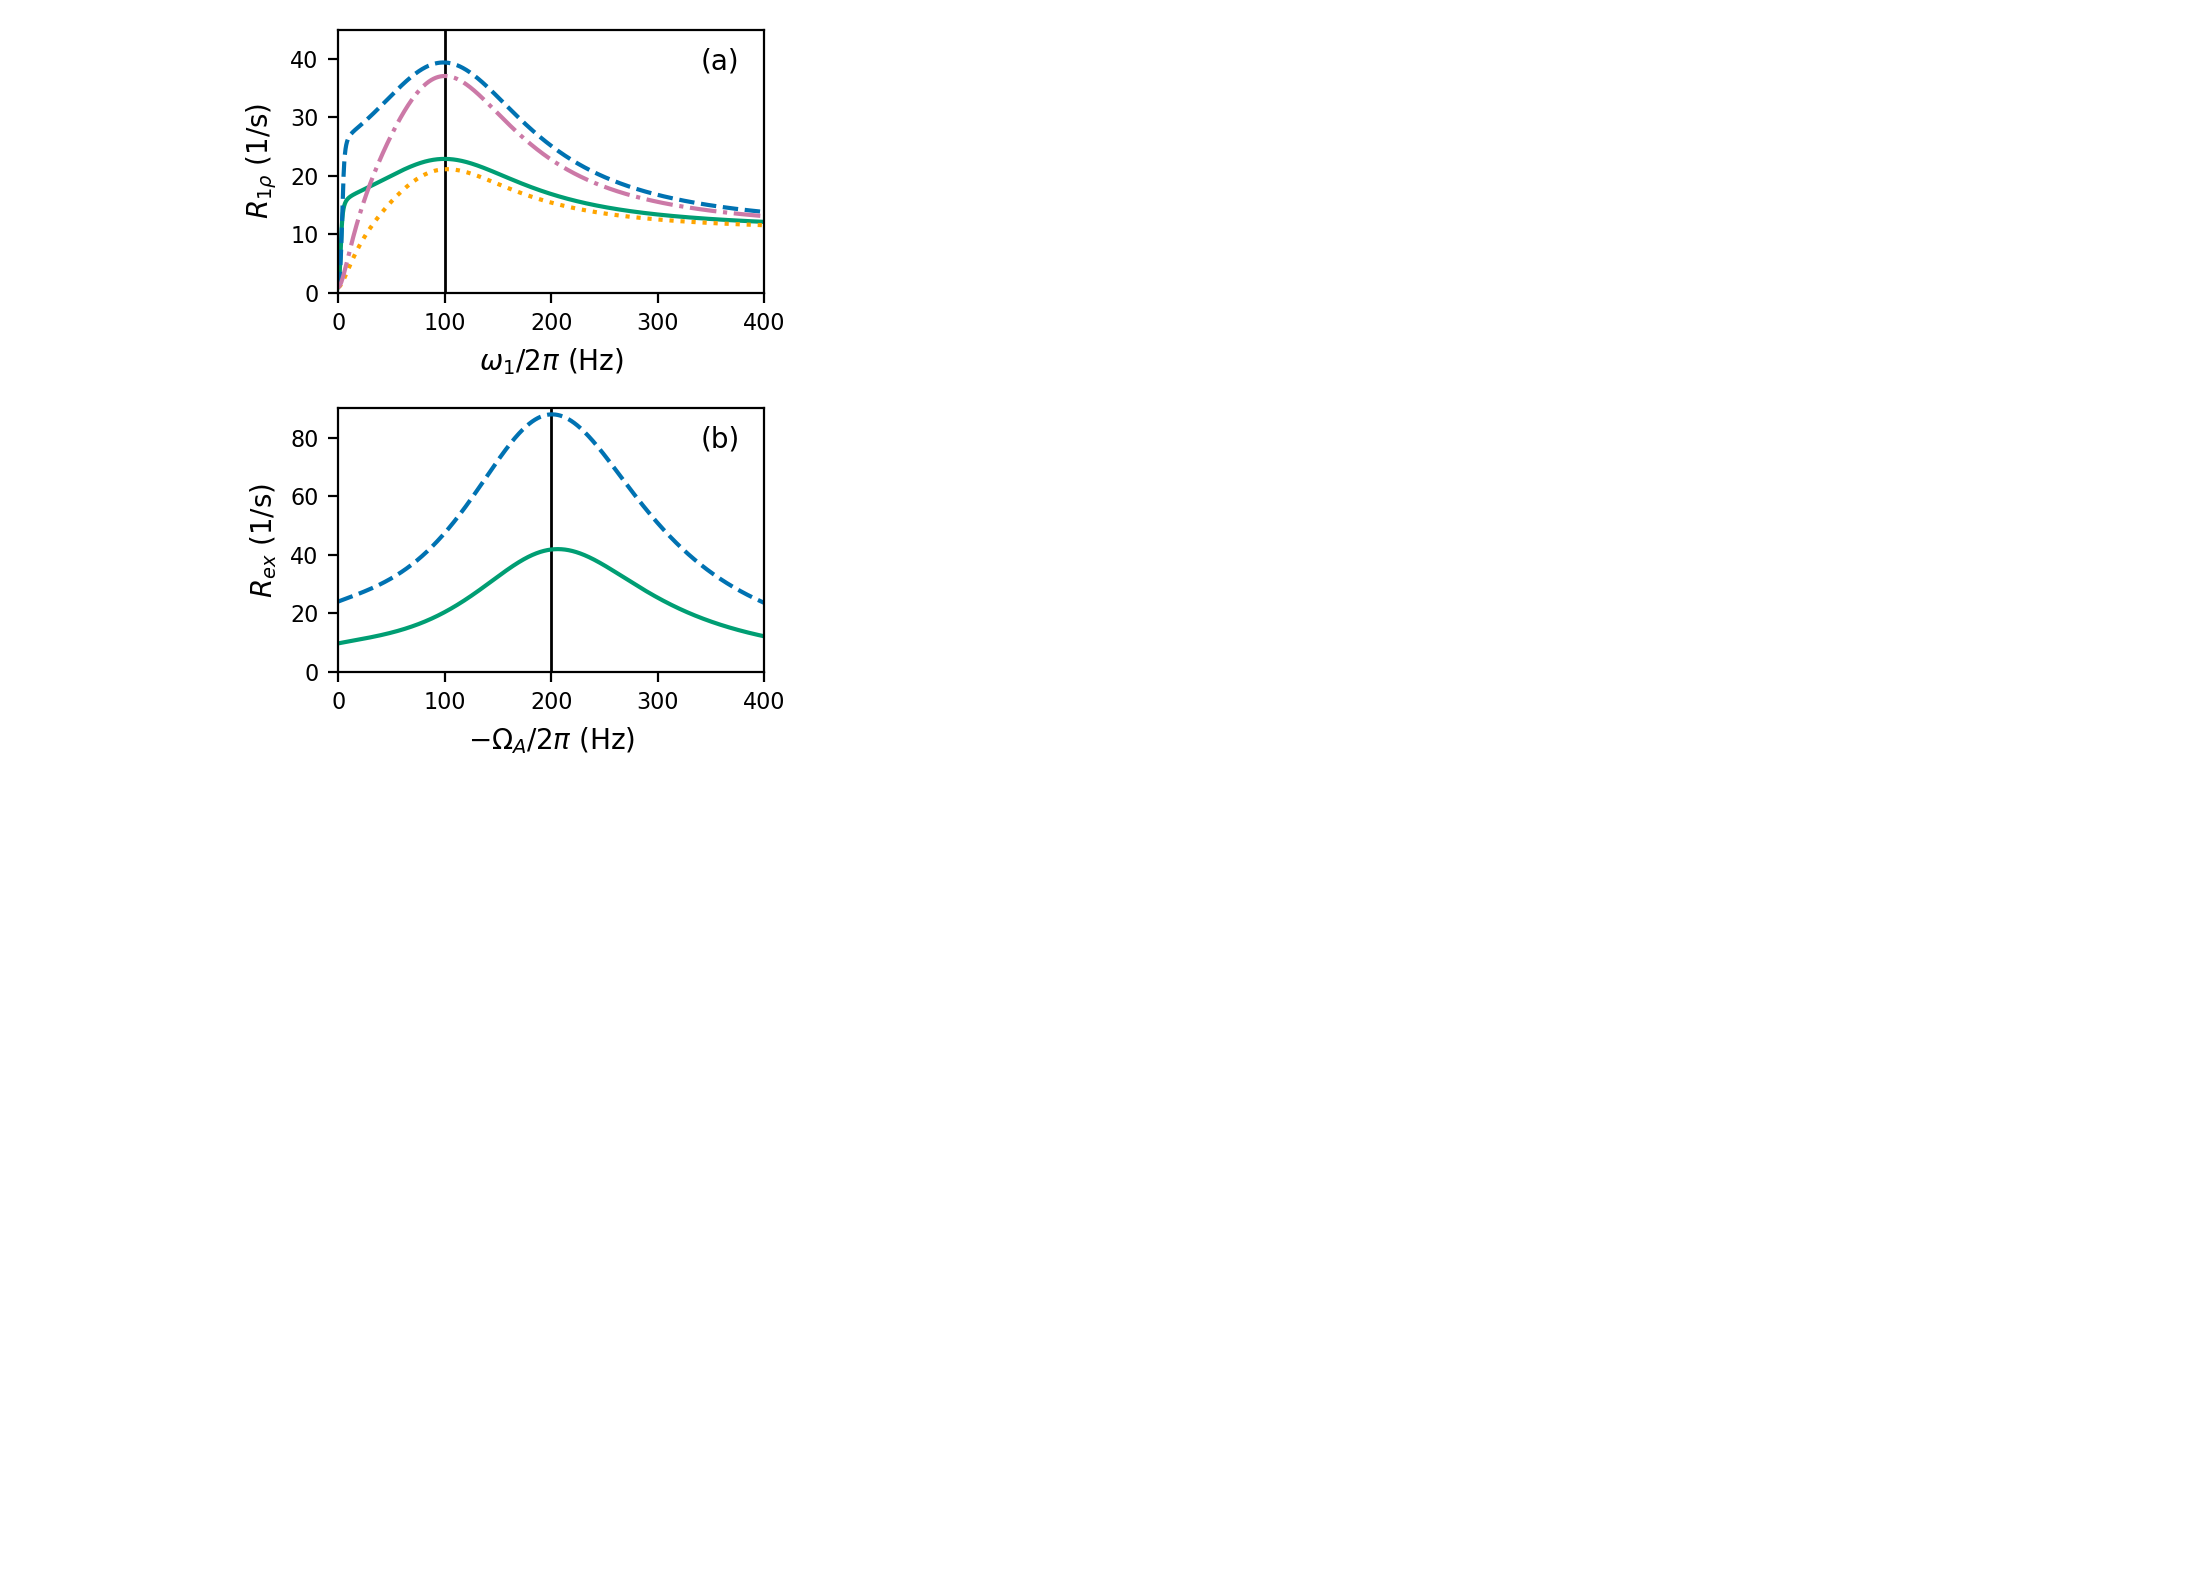

In [155]:
# Figure 5
# initial condition
omA = 0
omB = 2*np.pi*200
rf0 = np.pi*200
dw = np.abs(omB-omA)

w10 = 0.5*dw

R1A = 1
R2A= 20

R1B = 1
R2B = 20

pA = 0.90
pB = 1-pA
kex = 0.1*dw
km1 = kex*pA
k1 = kex*pB
print('Rates', k1, km1, kex)

ombar0 = pA*omA + pB*omB
print('Frequencies',omA/(2*np.pi),omB/(2*np.pi),ombar0/(2*np.pi),'\n')

# offset measured from omA
print('Offset from omA')
rf = np.linspace(1,2*dw,5000)
ombarA = pB*dw - rf
w1A = rf
we = np.sqrt(ombarA**2 + w1A**2)
sinthet = w1A/we
costhet = ombarA/we

R1rA = R1r0 = R1rhoNoExMod(-rf,R1A,R2A,dw-rf,R1B,R2B,w1A,pA)
R1rSlowALG = (LaguerreMod(-rf,R1A,R2A,dw-rf,R1B,R2B,w1A,k1,km1))
R1rIntALG = (LaguerreMod(-rf,R1A,R2A,dw-rf,R1B,R2B,w1A,k1*2.5,km1*2.5))

R1rSlowA = np.zeros(len(rf))
R1rIntA = np.zeros(len(rf))

for i,wrf in enumerate(rf):
    temp = BMCcartesian(-wrf,R1A,R2A,dw-wrf,R1B,R2B,w1A[i],k1,km1)
    R1rSlowA[i] = np.min(np.abs(eig(temp)[0]))
    temp = BMCcartesian(-wrf,R1A,R2A,dw-wrf,R1B,R2B,w1A[i],k1*2.5,km1*2.5)
    R1rIntA[i] = np.min(np.abs(eig(temp)[0]))

tmp = np.argsort(R1rSlowA)
w1opt = w1A[tmp[-1]]
rfopt = rf[tmp[-1]]
omAopt = -rfopt
weAopt = np.sqrt(omAopt**2 + w1opt**2)
omBopt = dw-rfopt
weBopt = np.sqrt(omBopt**2 + w1opt**2)
dcosSlowA = (omAopt*omBopt+w1opt**2)/(weAopt*weBopt)
cosASlowA = omAopt/weAopt
cosBSlowA = omBopt/weBopt
print('Optimal Slow w1, wrf',w1opt/(2*np.pi),rfopt/(2*np.pi))
print('R1r0,R1rSlow,R1rIdeal',R1r0[tmp[-1]],R1rSlowA[tmp[-1]],R1r0[tmp[-1]]+k1)

tmp = np.argsort(R1rIntA)
w1opt = w1A[tmp[-1]]
rfopt = rf[tmp[-1]]
omAopt = -rfopt
weAopt = np.sqrt(omAopt**2 + w1opt**2)
omBopt = dw-rfopt
weBopt = np.sqrt(omBopt**2 + w1opt**2)
dcosIntA = (omAopt*omBopt+w1opt**2)/(weAopt*weBopt)
cosAIntA = omAopt/weAopt
cosBIntA = omBopt/weBopt

print('Optimal Int w1, wrf',w1opt/(2*np.pi),rfopt/(2*np.pi))
print('R1r0,R1rInt,R1rIdeal',R1r0[tmp[-1]],R1rIntA[tmp[-1]],R1r0[tmp[-1]]+k1*2.5)

print('Slow angles',np.arccos(cosASlowA)*180/np.pi,np.arccos(cosBSlowA)*180/np.pi,np.arccos(dcosSlowA)*180/np.pi)
print('Int angles ',np.arccos(cosAIntA)*180/np.pi,np.arccos(cosBIntA)*180/np.pi,np.arccos(dcosIntA)*180/np.pi,"\n")
print('\n')

# offset relative to average peak position
print('Offset from ombar')
rf = np.linspace(0.1,2*dw,5000)
ombar = -rf
w1bar = rf
we = np.sqrt(ombar**2 + w1bar**2)
sinthet = w1bar/we
costhet = ombar/we

R1r = R1rhoNoExMod(-pB*dw-rf,R1A,R2A,pA*dw-rf,R1B,R2B,w1bar,pA)
R1rSlowLG = (LaguerreMod(-pB*dw-rf,R1A,R2A,pA*dw-rf,R1B,R2B,w1bar,k1,km1))
R1rIntLG = (LaguerreMod(-pB*dw-rf,R1A,R2A,pA*dw-rf,R1B,R2B,w1bar,k1*2.5,km1*2.5))

R1rSlow = np.zeros(len(rf))
R1rInt = np.zeros(len(rf))

for i,wrf in enumerate(rf):
    temp = BMCcartesian(-pB*dw-wrf,R1A,R2A,pA*dw-wrf,R1B,R2B,w1bar[i],k1,km1)
    R1rSlow[i] = np.min(np.abs(eig(temp)[0]))
    temp = BMCcartesian(-pB*dw-wrf,R1A,R2A,pA*dw-wrf,R1B,R2B,w1bar[i],k1*2.5,km1*2.5)
    R1rInt[i] = np.min(np.abs(eig(temp)[0]))


tmp = np.argsort(R1rSlow)
w1opt = w1bar[tmp[-1]]
rfopt = rf[tmp[-1]]
omAopt = -pB*dw-rfopt
weAopt = np.sqrt(omAopt**2 + w1opt**2)
omBopt = pA*dw-rfopt
weBopt = np.sqrt(omBopt**2 + w1opt**2)
dcosSlow = (omAopt*omBopt+w1opt**2)/(weAopt*weBopt)
cosASlow = omAopt/weAopt
cosBSlow = omBopt/weBopt
print('Optimal Slow w1, wrf',w1opt/(2*np.pi),rfopt/(2*np.pi))
print('R1r0,R1rSlow,R1rIdeal',R1r[tmp[-1]],R1rSlow[tmp[-1]],R1r[tmp[-1]]+k1)

tmp = np.argsort(R1rInt)
w1opt = w1bar[tmp[-1]]
rfopt = rf[tmp[-1]]
omAopt = omA-ombar0-rfopt
weAopt = np.sqrt(omAopt**2 + w1opt**2)
omBopt = omB-ombar0-rfopt
weBopt = np.sqrt(omBopt**2 + w1opt**2)
dcosInt = (omAopt*omBopt+w1opt**2)/(weAopt*weBopt)
cosAInt = omAopt/weAopt
cosBInt = omBopt/weBopt
print('Optimal Int w1, wrf',w1opt/(2*np.pi),rfopt/(2*np.pi),)
print('R1r0,R1rInt,R1rIdeal',R1r[tmp[-1]],R1rInt[tmp[-1]],R1r[tmp[-1]]+k1*2.5)

print('Slow angles',np.arccos(cosASlow)*180/np.pi,np.arccos(cosBSlow)*180/np.pi,np.arccos(dcosSlow)*180/np.pi)
print('Int angles',np.arccos(cosAInt)*180/np.pi,np.arccos(cosBInt)*180/np.pi,np.arccos(dcosInt)*180/np.pi,"\n")
print('\n')

# Conventional approach
#rf measured from site A
w10 = dw/2
rf0 = np.linspace(0.1,2*dw,5000)
ombar = pB*dw - rf0
we = np.sqrt(ombar**2 + w10**2)
sinthet = w10/we
costhet = ombar/we

R1r0LG = R1rhoNoExMod(-rf0,R1A,R2A,dw-rf0,R1B,R2B,w10,pA)
R1r0UNCORR = R1rhoNoEx(-rf0,R1A,R2A,dw-rf0,R1B,R2B,w10,pA)


R1rSlowOff0LG = (LaguerreMod(-rf0,R1A,R2A,dw-rf0,R1B,R2B,w10,k1,km1))
R1rIntOff0LG = (LaguerreMod(-rf0,R1A,R2A,dw-rf0,R1B,R2B,w10,k1*2.5,km1*2.5))

R1rSlowOff0 = np.zeros(len(rf0))
R1rIntOff0 = np.zeros(len(rf0))
R1r0 = np.zeros(len(rf0))

for i,wrf0 in enumerate(rf0):
    temp = BMCcartesian(-wrf0,R1A,R2A,dw-wrf0,R1B,R2B,w10,k1,km1)
    R1rSlowOff0[i] = np.min(np.abs(eig(temp)[0]))
    temp = BMCcartesian(-wrf0,R1A,R2A,dw-wrf0,R1B,R2B,w10,k1*2.5,km1*2.5)
    R1rIntOff0[i] = np.min(np.abs(eig(temp)[0]))
    temp = BMCcartesian(-wrf0,R1A,R2A,dw-wrf0,R1B,R2B,w10,0,0)
    tempeig = eig(temp)[0]
    #print(wrf0,tempeig)
    tempeigR = tempeig[np.abs(np.imag(tempeig)) < 1e-6]
    R1r0[i] = np.min(np.abs(tempeigR))
    if wrf0 < dw/2:
        R1r0[i] = np.max(np.abs(tempeigR))
    
RexSlowOff0 = (R1rSlowOff0-R1r0)/sinthet**2
RexIntOff0 = (R1rIntOff0-R1r0)/sinthet**2

RexSlowOff0LG = (R1rSlowOff0LG-R1r0LG)/sinthet**2
RexIntOff0LG = (R1rIntOff0LG-R1r0LG)/sinthet**2

tmp = np.argsort(RexSlowOff0)
print('Slow offset, R1r',rf0[tmp[-1]]/(2*np.pi),RexSlowOff0[tmp[-1]])
tmp = np.argsort(RexIntOff0)
print('Int offset, R1r ',rf0[tmp[-1]]/(2*np.pi),RexIntOff0[tmp[-1]])
fig, ((ax1, ax2)) = plt.subplots(2, 1, 
                        figsize=(14/2.54,10/2.54))
fig.subplots_adjust(hspace=0.15,wspace=0.1,top=1.0,bottom=0.0)

ax1.axvline(100,c='black',lw=1)
ax1.plot((w1A)/(2*np.pi),R1rSlowA,color=green)
#ax1.plot((w1A)/(2*np.pi),R1rSlowALG,color='red')
ax1.plot((w1bar)/(2*np.pi),R1rSlow,color='orange',ls='dotted')
ax1.plot((w1A)/(2*np.pi),R1rIntA,c=blue,ls='dashed')
#ax1.plot((w1A)/(2*np.pi),R1rIntALG,c='cyan',ls='dashed')
ax1.plot((w1bar)/(2*np.pi),R1rInt,c=reddishpurple,ls='-.')

tmp=ax1.set_xlim(0,400)
tmp=ax1.set_ylim(0,45)
tmp=ax1.set_aspect(0.618*400/45)

ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_ylabel(r'$R_{1\rho}$ (1/s)',fontsize=10)
ax1.set_xlabel(r'$\omega_{1}/2\pi$ (Hz)',fontsize=10)
ax1.text(0.85,0.85,"(a)",transform=ax1.transAxes,fontsize=10)

ax2.axvline(200,c='black',lw=1)
ax2.plot((rf0)/(2*np.pi),RexSlowOff0,c=green)
#ax2.plot((rfa)/(2*np.pi),RexSlowOff0LG,c='red')
ax2.plot((rf0)/(2*np.pi),RexIntOff0,c=blue,ls='dashed')
#ax2.plot((rfa)/(2*np.pi),RexIntOff0LG,c='cyan',ls='dashed')

tmp=ax2.set_xlim(0,400)
tmp=ax2.set_ylim(0,90)
tmp=ax2.set_aspect(0.618*400/90)

ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.set_ylabel(r'$R_{ex}$ (1/s)',fontsize=10)
ax2.set_xlabel(r'$-\Omega_A/2\pi$ (Hz)',fontsize=10)
ax2.text(0.85,0.85,"(b)",transform=ax2.transAxes,fontsize=10)

plt.tight_layout()

plt.savefig("Figure5_OmegaMatch.eps",pad_inches=0)

plt.show()

In [49]:
# three site decoupling

omegaA = 0 
omegaB = 100*2*np.pi
omegaC = 300*2*np.pi
pB = 0.056
pC = 0.105
pA = 1 - pB - pC  # gives pA = 0.85, pB = 0.05, pC = 0.10

print(omegaA*pA + omegaB*pB + omegaC*pC)

R2A = 20
R2B = 20
R2C = 20
R1A = 1
R1B = 1
R1C = 1

kex2 = 150
kex3 = 100
k12 = kex2*pB
k21 = kex2 - k12
k13 = kex3*pC
k31 = kex3 - k13

k23 = 150
k32 = k23*(k12/k21)*(k31/k13)

print(k12,k21)
print(k13,k31)
print(k23,k32)
print(k12*k23*k31,k13*k32*k21)

DelCB = (omegaC-omegaB)
w1 = 804.75 
#w1 = DelCB/2
print(w1)
rf = 1.0*w1 + omegaB
#rf = omegaC
#rf = 0

kmat = np.array([[-k12-k13,k21,k31],[k12,-k21-k23,k32],[k13,k23,-k31-k32]])
print(kmat)
vec0 = eig(kmat)[1][:,0]
vec0 = vec0/np.sum(vec0)
print(vec0,np.sum(vec0))

LA = np.array([[-R2A-k12-k13,-(omegaA-rf),0],[omegaA-rf,-R2A-k12-k13,-w1],[0,w1,-R1A-k12-k13]])
LB = np.array([[-R2B-k21-k23,-(omegaB-rf),0],[omegaB-rf,-R2B-k21-k23,-w1],[0,w1,-R1B-k21-k23]])
LC = np.array([[-R2C-k31-k32,-(omegaC-rf),0],[omegaC-rf,-R2C-k31-k32,-w1],[0,w1,-R1C-k31-k32]])

wA = np.sqrt((omegaA-rf)**2+w1**2)
wB = np.sqrt((omegaB-rf)**2+w1**2)
wC = np.sqrt((omegaC-rf)**2+w1**2)

sinA = w1/wA
cosA = (omegaA-rf)/wA
thetA = np.arctan2(sinA,cosA)

sinB = w1/wB
cosB = (omegaB-rf)/wB
thetB = np.arctan2(sinB,cosB)

sinC = w1/wC
cosC = (omegaC-rf)/wC
thetC = np.arctan2(sinC,cosC)

print('Tilt: ',thetA*180/(np.pi),thetB*180/(np.pi),thetC*180/(np.pi))

BigR = np.block([[Ry(thetA),np.zeros([3,3]),np.zeros([3,3])],
                [np.zeros([3,3]),Ry(thetB),np.zeros([3,3])],
                [np.zeros([3,3]),np.zeros([3,3]),Ry(thetC)]])

BigU = np.block([[Utrans(),np.zeros([3,3]),np.zeros([3,3])],
                [np.zeros([3,3]),Utrans(),np.zeros([3,3])],
                [np.zeros([3,3]),np.zeros([3,3]),Utrans()]])

KK12 = np.sqrt(k12*k21)*np.eye(3)
KK13 = np.sqrt(k13*k31)*np.eye(3)
KK23 = np.sqrt(k23*k32)*np.eye(3)

BMCtri = np.block([[LA,KK12,KK13],[KK12,LB,KK23],[KK13,KK23,LC]])
Rtri = -1/np.trace(np.linalg.inv(BMCtri))
print(np.min(np.abs(eig(BMCtri)[0])),Rtri)


BMCtritilt = np.linalg.inv(BigU)@np.linalg.inv(BigR)@BMCtri@BigR@BigU

BMClin = np.block([[LA,KK12,KK13],[KK12,LB,np.zeros([3,3])],[KK13,np.zeros([3,3]),LC]])
Rlin = -1/np.trace(np.linalg.inv(BMClin))

BMClintilt = np.linalg.inv(BigU)@np.linalg.inv(BigR)@BMClin@BigR@BigU

print(np.min(np.abs(eig(BMClin)[0])),Rlin)

print(np.min(np.abs(eig(BMClin)[0])/np.min(np.abs(eig(BMCtri)[0]))))

print((k12+k21+k13+k31+k23+k32)/w1,"\n")

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

print('G11',(BMCtritilt[0:3,0:3]),"\n")
print('G12',(BMCtritilt[0:3,3:6]),"\n")
print('G13',(BMCtritilt[0:3,6:]),"\n")
print('G22',(BMCtritilt[3:6,3:6]),"\n")
print('G23',(BMCtritilt[3:6,6:]),"\n")
print('G33',(BMCtritilt[6:,6:]),"\n")

print("\n")
print('G11',(BMClintilt[0:3,0:3]),"\n")
print('G12',(BMClintilt[0:3,3:6]),"\n")
print('G13',(BMClintilt[0:3,6:]),"\n")
print('G22',(BMClintilt[3:6,3:6]),"\n")
print('G23',(BMClintilt[3:6,6:]),"\n")
print('G33',(BMClintilt[6:,6:]),"\n")

233.10617489636263
8.4 141.6
10.5 89.5
150 75.84745762711864
112770.0 112770.0
804.75
[[ -18.9         141.6          89.5       ]
 [   8.4        -291.6          75.84745763]
 [  10.5         150.         -165.34745763]]
[0.84987728 0.05041645 0.09970627] 1.0
Tilt:  150.6832963096385 135.0 60.68471028566309
20.192811445311264 16.85274523821996
20.352797937867408 17.006146058710993
1.0079229429239924
0.5912984872657578 

G11 [[-36.6224-1643.5656j   2.2776   -0.j       5.7358   +0.j    ]
 [  2.2776   +0.j     -36.6224+1643.5656j   5.7358   -0.j    ]
 [  5.7358   -0.j       5.7358   +0.j     -24.4551   +0.j    ]] 

G12 [[33.8463+0.j -0.642 +0.j -6.5923+0.j]
 [-0.642 +0.j 33.8463+0.j -6.5923+0.j]
 [ 6.5923+0.j  6.5923+0.j 33.2043+0.j]] 

G13 [[ 15.328 +0.j -15.3273+0.j -21.6766+0.j]
 [-15.3273+0.j  15.328 +0.j -21.6766+0.j]
 [ 21.6766+0.j  21.6766+0.j   0.0008+0.j]] 

G22 [[-306.85  -1138.0884j    4.75     +0.j        6.7175   +0.j    ]
 [   4.75     -0.j     -306.85  +1138.0884j    6.717

233.10617489636263
8.4 141.6
10.5 89.5
150 75.84745762711864
112770.0 112770.0
[[ -18.9         141.6          89.5       ]
 [   8.4        -291.6          75.84745763]
 [  10.5         150.         -165.34745763]]
[0.84987728 0.05041645 0.09970627] 1.0
[0.84987728 0.05041645 0.09970627] 1.0
w1 max: 807.4201057393353


<IPython.core.display.Javascript object>


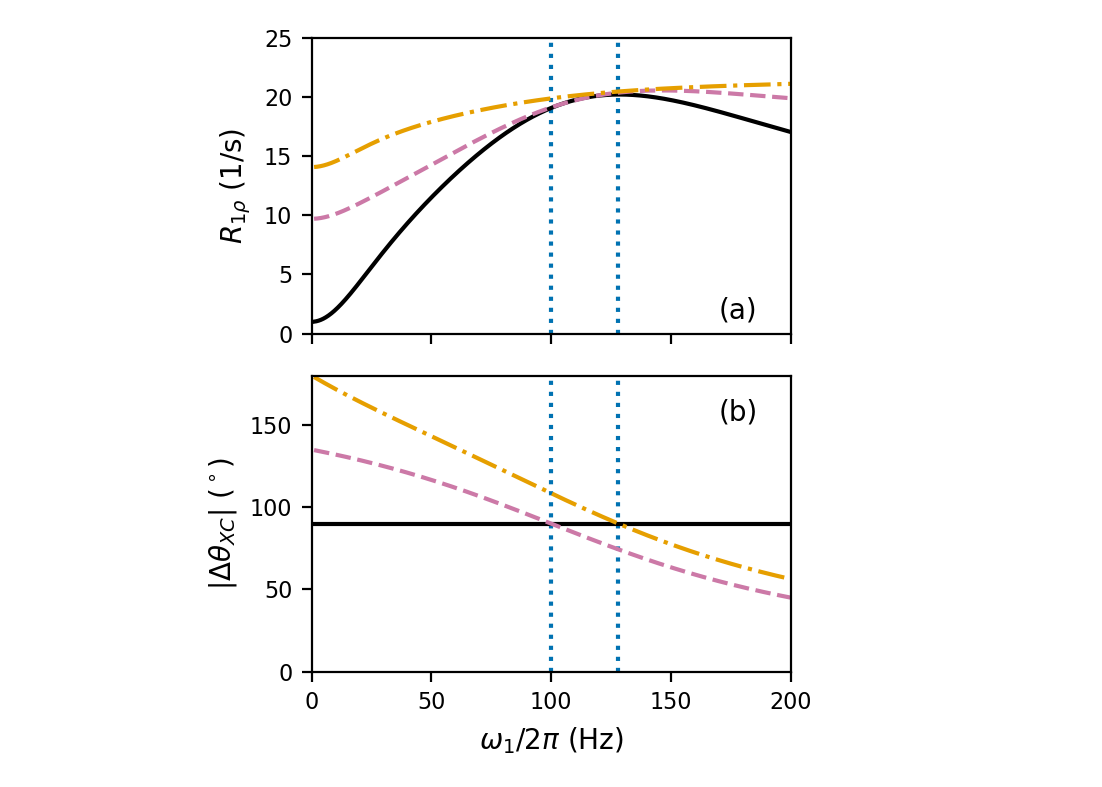

In [156]:
# three site decoupling (Figure 6)

omegaA = 0 
omegaB = 100*2*np.pi
omegaC = 300*2*np.pi
pB = 0.056
pC = 0.105
pA = 1 - pB - pC  # gives pA = 0.85, pB = 0.05, pC = 0.10

print(omegaA*pA + omegaB*pB + omegaC*pC)

R2A = 20
R2B = 20
R2C = 20
R1A = 1
R1B = 1
R1C = 1

kex2 = 150
kex3 = 100
k12 = kex2*pB
k21 = kex2 - k12
k13 = kex3*pC
k31 = kex3 - k13

k23 = 150
k32 = k23*(k12/k21)*(k31/k13)

print(k12,k21)
print(k13,k31)
print(k23,k32)
print(k12*k23*k31,k13*k32*k21)

kmat = np.array([[-k12-k13,k21,k31],[k12,-k21-k23,k32],[k13,k23,-k31-k32]])
print(kmat)
vec0 = eig(kmat)[1][:,0]
vec0 = vec0/np.sum(vec0)
print(vec0,np.sum(vec0))

calcpops = ThreeSitePopulations(k12,k21,k13,k31,k23,k32)
print(calcpops,np.sum(calcpops))

KK12 = np.sqrt(k12*k21)*np.eye(3)
KK13 = np.sqrt(k13*k31)*np.eye(3)
KK23 = np.sqrt(k23*k32)*np.eye(3)

BigU = np.block([[Utrans(),np.zeros([3,3]),np.zeros([3,3])],
                [np.zeros([3,3]),Utrans(),np.zeros([3,3])],
                [np.zeros([3,3]),np.zeros([3,3]),Utrans()]])

DelCB = (omegaC-omegaB)

nmax=5000
w1arrayHz = np.linspace(1,200,nmax)
w1array = w1arrayHz*2*np.pi
BMCtriRateCB = np.zeros(nmax)
BMClinRateCA = np.zeros(nmax)
BMClinRateCB = np.zeros(nmax)

BMCtriThetCB = np.zeros(nmax)
BMCtriThetCA = np.zeros(nmax)

for i,w1 in enumerate(w1array):
    rf = 1.0*w1 + omegaB

    LA = np.array([[-R2A-k12-k13,-(omegaA-rf),0],[omegaA-rf,-R2A-k12-k13,-w1],[0,w1,-R1A-k12-k13]])
    LB = np.array([[-R2B-k21-k23,-(omegaB-rf),0],[omegaB-rf,-R2B-k21-k23,-w1],[0,w1,-R1B-k21-k23]])
    LC = np.array([[-R2C-k31-k32,-(omegaC-rf),0],[omegaC-rf,-R2C-k31-k32,-w1],[0,w1,-R1C-k31-k32]])

    wA = np.sqrt((omegaA-rf)**2+w1**2)
    wB = np.sqrt((omegaB-rf)**2+w1**2)
    wC = np.sqrt((omegaC-rf)**2+w1**2)

    sinA = w1/wA
    cosA = (omegaA-rf)/wA
    thetA = np.arctan2(sinA,cosA)

    sinB = w1/wB
    cosB = (omegaB-rf)/wB
    thetB = np.arctan2(sinB,cosB)

    sinC = w1/wC
    cosC = (omegaC-rf)/wC
    thetC = np.arctan2(sinC,cosC)
    
    BMCtriThetCB[i] = thetB - thetC
    BMCtriThetCA[i] = thetA - thetC

    BigR = np.block([[Ry(thetA),np.zeros([3,3]),np.zeros([3,3])],
                [np.zeros([3,3]),Ry(thetB),np.zeros([3,3])],
                [np.zeros([3,3]),np.zeros([3,3]),Ry(thetC)]])

    BMCtri = np.block([[LA,KK12,KK13],[KK12,LB,KK23],[KK13,KK23,LC]])
    BMCtriRateCB[i] = np.min(np.abs(eig(BMCtri)[0]))


    BMClin = np.block([[LA,KK12,KK13],[KK12,LB,np.zeros([3,3])],[KK13,np.zeros([3,3]),LC]])

    BMClinRateCB[i]=np.min(np.abs(eig(BMClin)[0]))
    
    BMClin = np.block([[LA,KK12,np.zeros([3,3])],[KK12,LB,KK23],[np.zeros([3,3]),KK23,LC]])

    BMClinRateCA[i]=np.min(np.abs(eig(BMClin)[0]))

temp = np.argsort(BMCtriRateCB)
w1max = w1array[temp[-1]]
print('w1 max:',w1max)

fig, ((ax1, ax2)) = plt.subplots(2, 1, 
                        figsize=(14/2.54,10/2.54))
fig.subplots_adjust(hspace=0.15,wspace=0.1,top=1.0,bottom=0.0)

ax1.axvline(DelCB/(4*np.pi),color=blue,ls='dotted')
ax1.axvline(804.75/(2*np.pi),color=blue,ls='dotted')

ax1.plot(w1arrayHz,BMCtriRateCB,color='black')
ax1.plot(w1arrayHz,BMClinRateCB,color=reddishpurple,ls='--')
ax1.plot(w1arrayHz,BMClinRateCA,color=orange,ls='-.')

tmp=ax1.set_xlim(0,200)
tmp=ax1.set_ylim(0,25)
tmp=ax1.set_aspect(0.618*200/25)

ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_ylabel(r'$R_{1\rho}$ (1/s)',fontsize=10)
ax1.text(0.85,0.05,"(a)",transform=ax1.transAxes,fontsize=10)
tmp=ax1.set_xticklabels([])

ax2.axvline(DelCB/(4*np.pi),color=blue,ls='dotted')
ax2.axvline(804.75/(2*np.pi),color=blue,ls='dotted')
ax2.axhline(90,color='black')
ax2.plot(w1arrayHz,BMCtriThetCB*180/np.pi,color=reddishpurple,ls='--')
ax2.plot(w1arrayHz,BMCtriThetCA*180/np.pi,color=orange,ls='-.')

tmp=ax2.set_xlim(0,200)
tmp=ax2.set_ylim(0,180)
tmp=ax2.set_aspect(0.618*200/180)

ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.set_ylabel(r'$|\Delta \theta_{XC}|$ ($^\circ$)',fontsize=10)
ax2.set_xlabel(r'$\omega_{1}/2\pi$ (Hz)',fontsize=10)
ax2.text(0.85,0.85,"(b)",transform=ax2.transAxes,fontsize=10)

plt.tight_layout()

plt.savefig("Figure6_Triangle.eps",pad_inches=0)

plt.show()

k12,k21 8.4 141.6
k13,k31 10.5 89.5
k23,k32 150 75.84745762711864
112770.0 112770.0
Populations [0.84987728 0.05041645 0.09970627]


<IPython.core.display.Javascript object>


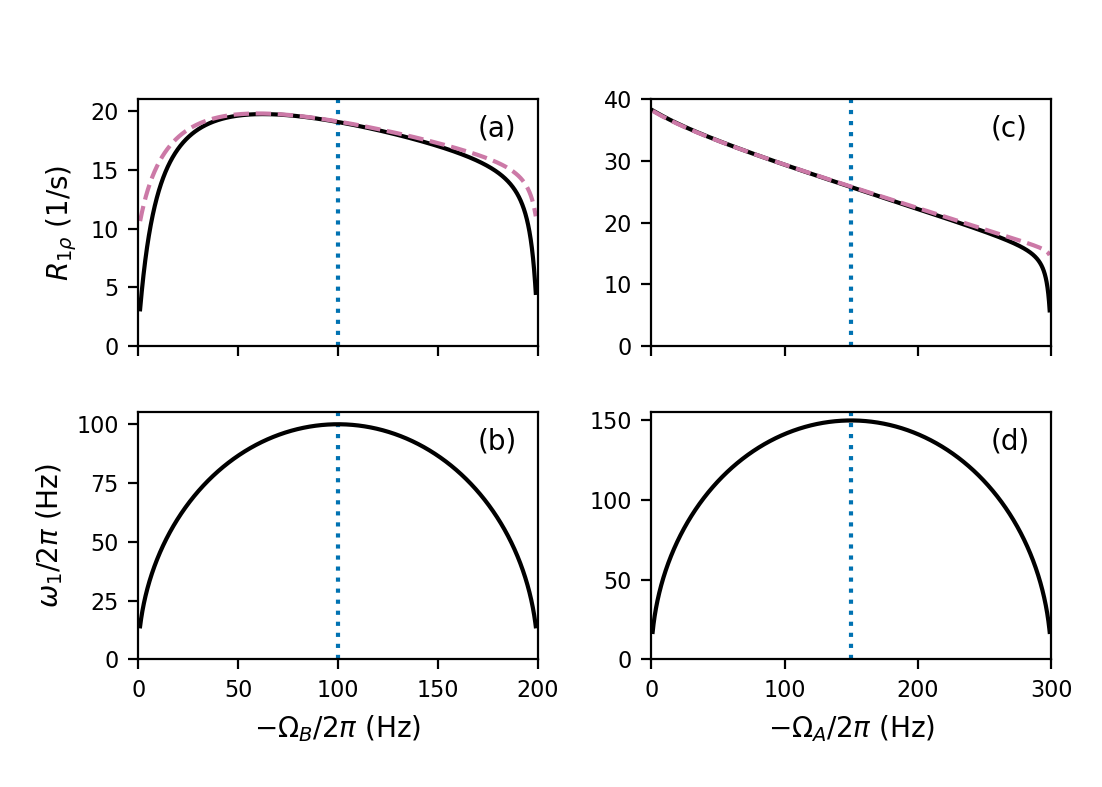

In [159]:
# three site decoupling (Figure 7)

omegaA = 0 
omegaB = 100*2*np.pi
omegaC = 300*2*np.pi
pB = 0.056
pC = 0.105
pA = 1 - pB - pC  # gives pA = 0.85, pB = 0.05, pC = 0.10

R2A = 20
R2B = 20
R2C = 20
R1A = 1
R1B = 1
R1C = 1

kex2 = 150
kex3 = 100
k12 = kex2*pB
k21 = kex2 - k12
k13 = kex3*pC
k31 = kex3 - k13

k23 = 150
k32 = k23*(k12/k21)*(k31/k13)

print('k12,k21',k12,k21)
print('k13,k31',k13,k31)
print('k23,k32',k23,k32)
print(k12*k23*k31,k13*k32*k21)

kmat = np.array([[-k12-k13,k21,k31],[k12,-k21-k23,k32],[k13,k23,-k31-k32]])
vec0 = eig(kmat)[1][:,0]
vec0 = vec0/np.sum(vec0)
print('Populations',vec0)

KK12 = np.sqrt(k12*k21)*np.eye(3)
KK13 = np.sqrt(k13*k31)*np.eye(3)
KK23 = np.sqrt(k23*k32)*np.eye(3)

BigU = np.block([[Utrans(),np.zeros([3,3]),np.zeros([3,3])],
                [np.zeros([3,3]),Utrans(),np.zeros([3,3])],
                [np.zeros([3,3]),np.zeros([3,3]),Utrans()]])

# linearize BC

DelCB = (omegaC-omegaB)

nmax=5000
wrfarrayCBHz = np.linspace(1,199,nmax)
wrfarray = wrfarrayCBHz*2*np.pi
w1array = np.sqrt(wrfarray*(omegaC-omegaB-wrfarray))
w1arrayCBHz = w1array/(2*np.pi)

BMCtriRateCB = np.zeros(nmax)
BMClinRateCB = np.zeros(nmax)
BMCtriThetCB = np.zeros(nmax)

for i,rf in enumerate(wrfarray):
    w1 = w1array[i]
    LA = np.array([[-R2A-k12-k13,-(omegaA-omegaB-rf),0],[omegaA-omegaB-rf,-R2A-k12-k13,-w1],[0,w1,-R1A-k12-k13]])
    LB = np.array([[-R2B-k21-k23,rf,0],[-rf,-R2B-k21-k23,-w1],[0,w1,-R1B-k21-k23]])
    LC = np.array([[-R2C-k31-k32,-(omegaC-omegaB-rf),0],[omegaC-omegaB-rf,-R2C-k31-k32,-w1],[0,w1,-R1C-k31-k32]])

    wA = np.sqrt((omegaA-omegaB-rf)**2+w1**2)
    wB = np.sqrt((-rf)**2+w1**2)
    wC = np.sqrt((omegaC-omegaB-rf)**2+w1**2)

    sinA = w1/wA
    cosA = (omegaA-omegaB-rf)/wA
    thetA = np.arctan2(sinA,cosA)

    sinB = w1/wB
    cosB = (-rf)/wB
    thetB = np.arctan2(sinB,cosB)

    sinC = w1/wC
    cosC = (omegaC-omegaB-rf)/wC
    thetC = np.arctan2(sinC,cosC)
    
    BMCtriThetCB[i] = thetB - thetC

    BigR = np.block([[Ry(thetA),np.zeros([3,3]),np.zeros([3,3])],
                [np.zeros([3,3]),Ry(thetB),np.zeros([3,3])],
                [np.zeros([3,3]),np.zeros([3,3]),Ry(thetC)]])

    BMCtri = np.block([[LA,KK12,KK13],[KK12,LB,KK23],[KK13,KK23,LC]])
    BMCtriRateCB[i] = np.min(np.abs(eig(BMCtri)[0]))

    BMClin = np.block([[LA,KK12,KK13],[KK12,LB,np.zeros([3,3])],[KK13,np.zeros([3,3]),LC]])

    BMClinRateCB[i]=np.min(np.abs(eig(BMClin)[0]))
    
# linearize AC

DelCA = omegaC-omegaA

wrfarrayCAHz = np.linspace(1,299,nmax)
wrfarray = wrfarrayCAHz*2*np.pi
w1array = np.sqrt(wrfarray*(omegaC-omegaA-wrfarray))
w1arrayCAHz = w1array/(2*np.pi)

BMCtriRateCA = np.zeros(nmax)
BMClinRateCA = np.zeros(nmax)
BMCtriThetCA = np.zeros(nmax)

for i,rf in enumerate(wrfarray):
    w1 = w1array[i]
    LA = np.array([[-R2A-k12-k13,rf,0],[-rf,-R2A-k12-k13,-w1],[0,w1,-R1A-k12-k13]])
    LB = np.array([[-R2B-k21-k23,-(omegaB-omegaA-rf),0],[omegaB-omegaA-rf,-R2B-k21-k23,-w1],[0,w1,-R1B-k21-k23]])
    LC = np.array([[-R2C-k31-k32,-(omegaC-omegaA-rf),0],[omegaC-omegaA-rf,-R2C-k31-k32,-w1],[0,w1,-R1C-k31-k32]])

    wA = np.sqrt((-rf)**2+w1**2)
    wB = np.sqrt((omegaB-omegaA-rf)**2+w1**2)
    wC = np.sqrt((omegaC-omegaA-rf)**2+w1**2)

    sinA = w1/wA
    cosA = (-rf)/wA
    thetA = np.arctan2(sinA,cosA)

    sinB = w1/wB
    cosB = (omegaB-omegaA-rf)/wB
    thetB = np.arctan2(sinB,cosB)

    sinC = w1/wC
    cosC = (omegaC-omegaA-rf)/wC
    thetC = np.arctan2(sinC,cosC)
    
    BMCtriThetCA[i] = thetA - thetC

    BigR = np.block([[Ry(thetA),np.zeros([3,3]),np.zeros([3,3])],
                [np.zeros([3,3]),Ry(thetB),np.zeros([3,3])],
                [np.zeros([3,3]),np.zeros([3,3]),Ry(thetC)]])

    BMCtri = np.block([[LA,KK12,KK13],[KK12,LB,KK23],[KK13,KK23,LC]])
    BMCtriRateCA[i] = np.min(np.abs(eig(BMCtri)[0]))
    
    BMClin = np.block([[LA,KK12,np.zeros([3,3])],[KK12,LB,KK23],[np.zeros([3,3]),KK23,LC]])

    BMClinRateCA[i]=np.min(np.abs(eig(BMClin)[0]))

# plot
fig, ((ax1, ax3),(ax2,ax4)) = plt.subplots(2, 2, 
                        figsize=(14/2.54,10/2.54))
fig.subplots_adjust(hspace=0.15,wspace=0.1,top=1.0,bottom=0.0)

ax1.axvline(DelCB/(4*np.pi),color=blue,ls='dotted')

ax1.plot(wrfarrayCBHz,BMCtriRateCB,color='black')
ax1.plot(wrfarrayCBHz,BMClinRateCB,color=reddishpurple,ls='--')
#ax1.plot(wrfarrayHz,BMClinRateCA,color=orange,ls='-.')

tmp=ax1.set_xlim(0,200)
tmp=ax1.set_ylim(0,21)
tmp=ax1.set_aspect(0.618*200/21)

ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_ylabel(r'$R_{1\rho}$ (1/s)',fontsize=10)
ax1.text(0.85,0.85,"(a)",transform=ax1.transAxes,fontsize=10)
tmp=ax1.set_xticklabels([])

ax2.axvline(DelCB/(4*np.pi),color=blue,ls='dotted')
ax2.plot(wrfarrayCBHz,w1arrayCBHz,color='black')

tmp=ax2.set_xlim(0,200)
tmp=ax2.set_ylim(0,105)
tmp=ax2.set_aspect(0.618*200/105)

ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.set_ylabel(r'$\omega_1/2\pi$ (Hz)',fontsize=10)
ax2.set_xlabel(r'$-\Omega_B/2\pi$ (Hz)',fontsize=10)
ax2.text(0.85,0.85,"(b)",transform=ax2.transAxes,fontsize=10)

ax3.axvline(DelCA/(4*np.pi),color=blue,ls='dotted')

ax3.plot(wrfarrayCAHz,BMCtriRateCA,color='black')
ax3.plot(wrfarrayCAHz,BMClinRateCA,color=reddishpurple,ls='--')

tmp=ax3.set_xlim(0,300)
tmp=ax3.set_ylim(0,40)
tmp=ax3.set_aspect(0.618*300/40)

ax3.tick_params(axis='both', which='major', labelsize=8)
#ax3.set_ylabel(r'$R_{1\rho}$ (1/s)',fontsize=10)
ax3.text(0.85,0.85,"(c)",transform=ax3.transAxes,fontsize=10)
tmp=ax3.set_xticklabels([])

ax4.axvline(DelCA/(4*np.pi),color=blue,ls='dotted')
ax4.plot(wrfarrayCAHz,w1arrayCAHz,color='black')

tmp=ax4.set_xlim(0,300)
tmp=ax4.set_ylim(0,155)
tmp=ax4.set_aspect(0.618*300/155)

ax4.tick_params(axis='both', which='major', labelsize=8)
#ax4.set_ylabel(r'$\omega_1/2\pi$ (Hz)',fontsize=10)
ax4.set_xlabel(r'$-\Omega_A/2\pi$ (Hz)',fontsize=10)
ax4.text(0.85,0.85,"(d)",transform=ax4.transAxes,fontsize=10)

plt.tight_layout()

plt.savefig("Figure7_TriangleLinear.eps",pad_inches=0)

plt.show()

<IPython.core.display.Javascript object>


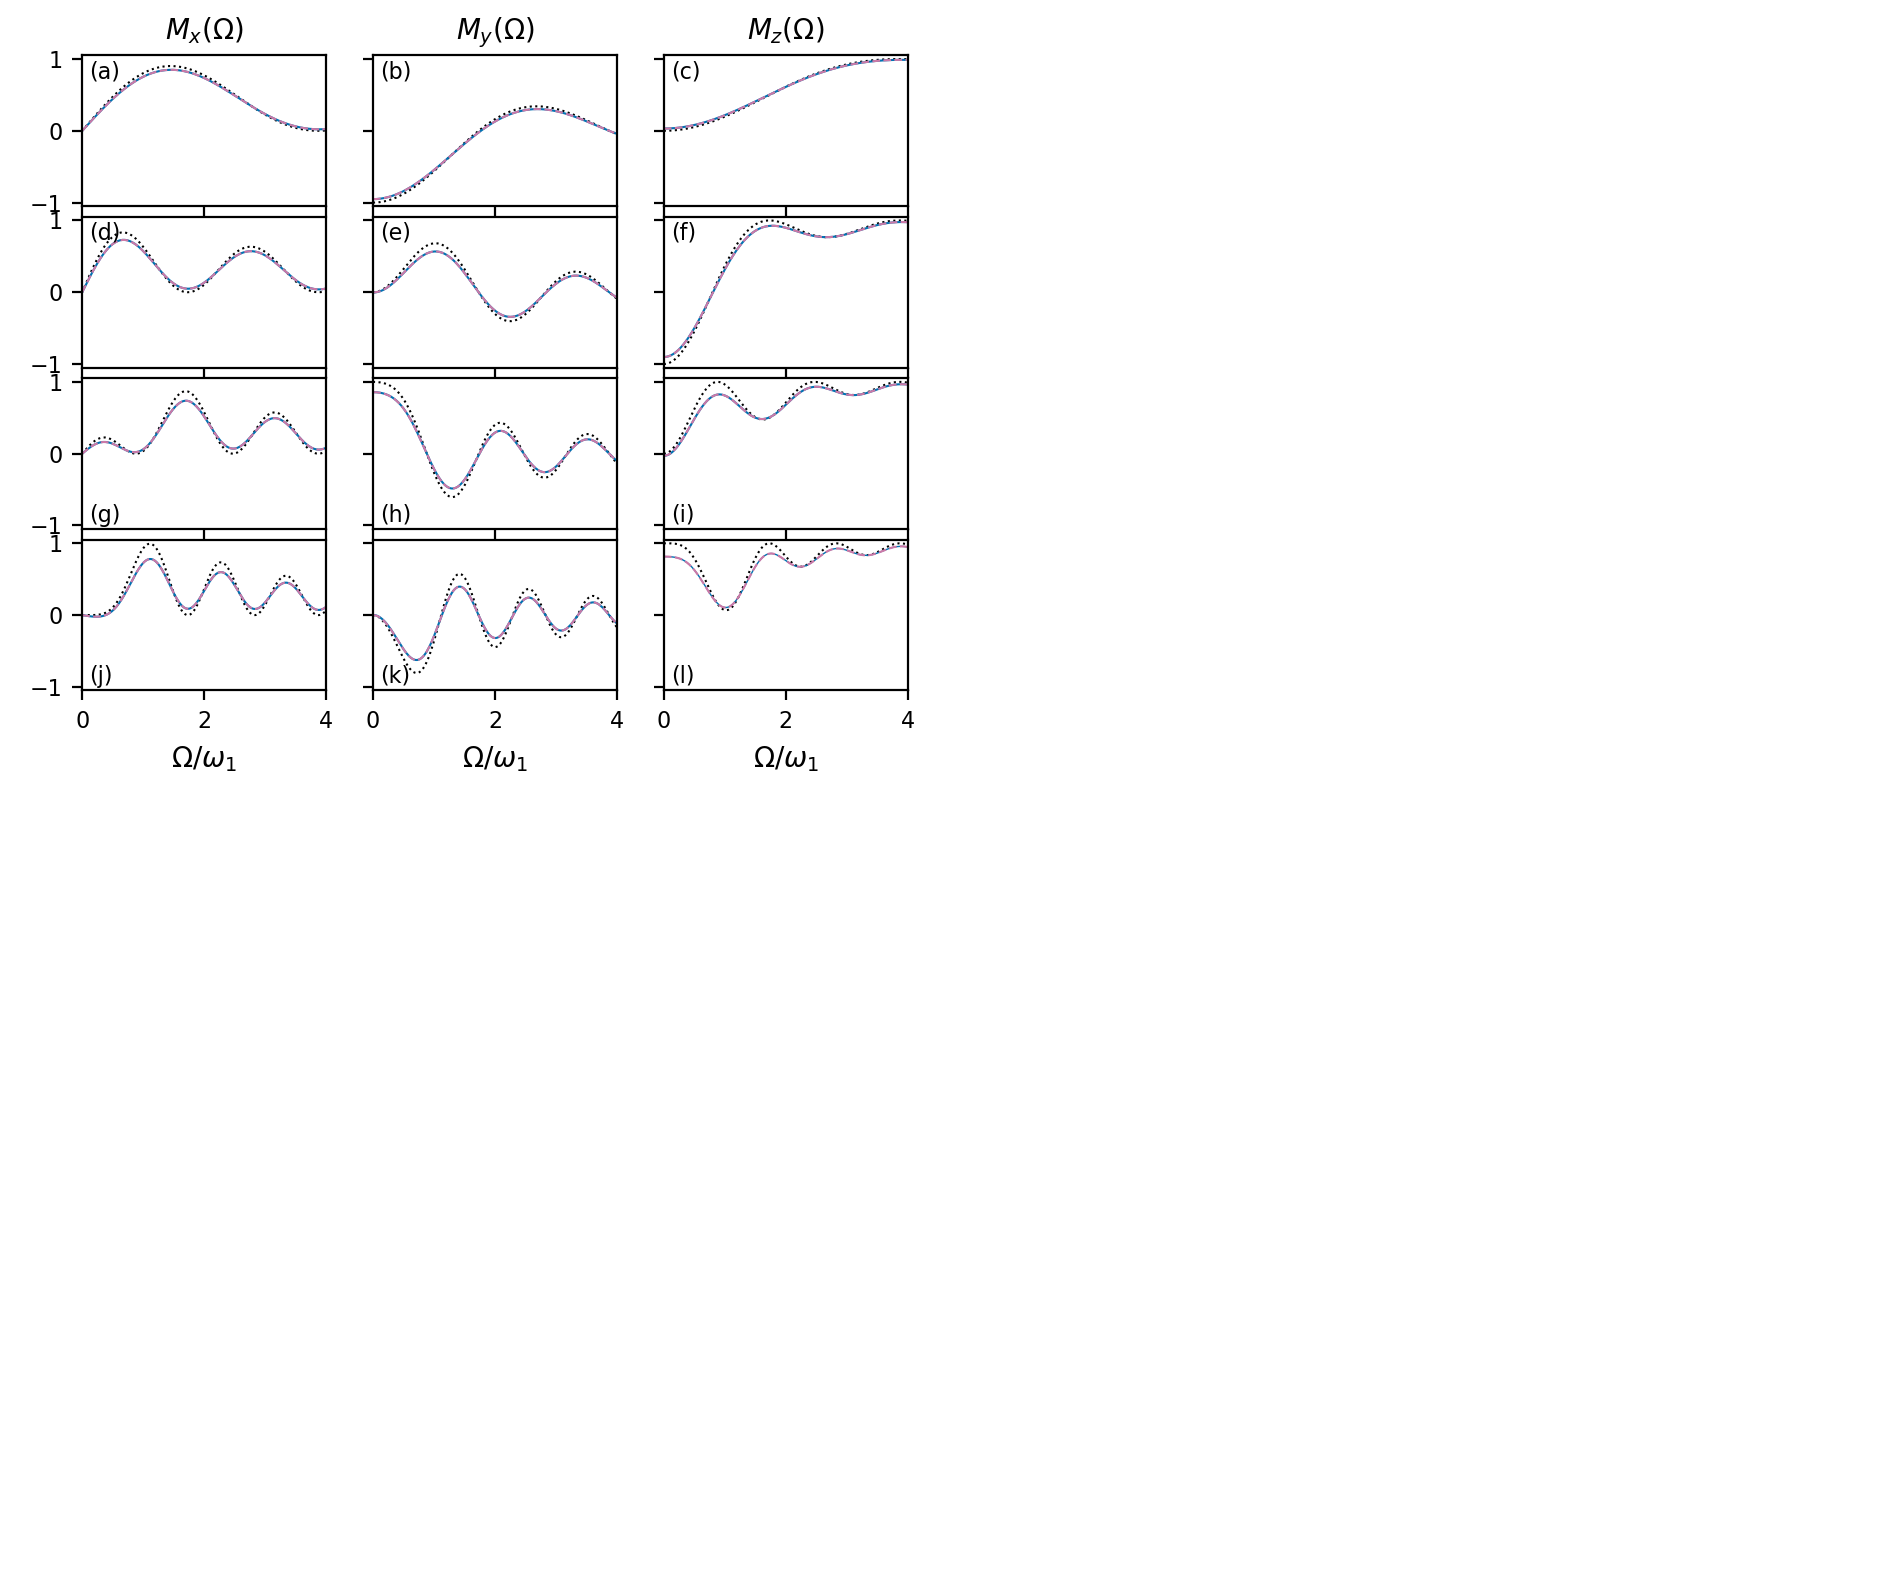

In [158]:
# square pulse, no exchange

fig, ((ax1, ax2,ax3), (ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12)) = plt.subplots(4, 3, 
                        figsize=(12/2.54,10/2.54))
fig.subplots_adjust(hspace=0.15,wspace=0.1,top=1.0,bottom=0.0)

# initial condition
w1 = 2*np.pi*250

ommax=4
om0 = np.linspace(0,ommax,200)
omreal = om0*w1

R1 = 2
R2= 100
m0 = [0,0,1]

mtall = np.zeros([200,3])
mt0all = np.zeros([200,3])
mtHAMall1 = np.zeros([200,3])
mtr1rho = np.zeros([200,3])

c0 = -1

#90 degree pulse
tmax = 0.5*np.pi/w1
t = np.linspace(0,tmax,1000)

for k,om in enumerate(omreal):
    # solve ODE
    mt =  odeint(bloch,m0,t,rtol = 1.49012e-9, atol=1.49012e-9,args=(om,w1,R2,R1))
    mtall[k,:] = mt[-1,:]
    
    #mtHAMinf = HAMsq(t,om,w1,R2,R1)
    #mtall[k,:] = mtHAMinf[:,-1]
    mt0 = M0sq(t,om,w1) 
    mt0all[k,:] = mt0[:,-1]
    mtHAM1 = HAM1sq(t,om,w1,R2,R1,c0)
    mtHAMall1[k,:] = mtHAM1[:,-1]
    mtr1rho[k,:]=HAMR1r(om,R1,R2,w1,tmax,m0,c0)

ax1.plot(om0,mt0all[:,0],c='black',ls='dotted',lw=0.75)
ax1.plot(om0,mtall[:,0],c=blue,lw=0.75)
ax1.plot(om0,mtr1rho[:,0],c=reddishpurple,ls='dashed',lw=0.75)
tmp=ax1.set_xlim(0,ommax)
tmp=ax1.set_ylim(-1.05,1.05)
tmp=ax1.set_aspect(0.618*ommax/2.1)
tmp=ax1.set_xticklabels([])
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_title(r'$M_x(\Omega)$',fontsize=10)
ax1.text(0.03,0.85,"(a)",transform=ax1.transAxes,fontsize=8)

ax2.plot(om0,mt0all[:,1],c='black',ls='dotted',lw=0.75)
ax2.plot(om0,mtall[:,1],c=blue,lw=0.75)
ax2.plot(om0,mtr1rho[:,1],c=reddishpurple,ls='dashed',lw=0.75)
tmp=ax2.set_xlim(0,ommax)
tmp=ax2.set_ylim(-1.05,1.05)
tmp=ax2.set_aspect(0.618*ommax/2.1)
tmp=ax2.set_xticklabels([])
tmp=ax2.set_yticklabels([])
ax2.set_title(r'$M_y(\Omega)$',fontsize=10)
ax2.text(0.03,0.85,"(b)",transform=ax2.transAxes,fontsize=8)

ax3.plot(om0,mt0all[:,2],c='black',ls='dotted',lw=0.75)
ax3.plot(om0,mtall[:,2],c=blue,lw=0.75)
ax3.plot(om0,mtr1rho[:,2],c=reddishpurple,ls='dashed',lw=0.75)
tmp=ax3.set_xlim(0,ommax)
tmp=ax3.set_ylim(-1.05,1.05)
tmp=ax3.set_aspect(0.618*ommax/2.1)
tmp=ax3.set_xticklabels([])
tmp=ax3.set_yticklabels([])
ax3.set_title(r'$M_z(\Omega)$',fontsize=10)
ax3.text(0.03,0.85,"(c)",transform=ax3.transAxes,fontsize=8)

#180 degree pulse
pord = 30
tmax = 1.0*np.pi/w1
t = np.linspace(0,tmax,1000)

for k,om in enumerate(omreal):
    # solve ODE
    mt =  odeint(bloch,m0,t,rtol = 1.49012e-9, atol=1.49012e-9,args=(om,w1,R2,R1))
    mtall[k,:] = mt[-1,:]
    
    #mtHAMinf = HAMsq(t,om,w1,R2,R1)
    #mtall[k,:] = mtHAMinf[:,-1]
    mt0 = M0sq(t,om,w1) 
    mt0all[k,:] = mt0[:,-1]
    mtHAM1 = HAM1sq(t,om,w1,R2,R1,c0)
    mtHAMall1[k,:] = mtHAM1[:,-1]
    mtr1rho[k,:]=HAMR1r(om,R1,R2,w1,tmax,m0,c0)

ax4.plot(om0,mt0all[:,0],c='black',ls='dotted',lw=0.75)
ax4.plot(om0,mtall[:,0],c=blue,lw=0.75)
ax4.plot(om0,mtr1rho[:,0],c=reddishpurple,ls='dashed',lw=0.75)
tmp=ax4.set_xlim(0,ommax)
tmp=ax4.set_ylim(-1.05,1.05)
tmp=ax4.set_aspect(0.618*ommax/2.1)
tmp=ax4.set_xticklabels([])
ax4.tick_params(axis='both', which='major', labelsize=8)
ax4.text(0.03,0.85,"(d)",transform=ax4.transAxes,fontsize=8)

ax5.plot(om0,mt0all[:,1],c='black',ls='dotted',lw=0.75)
ax5.plot(om0,mtall[:,1],c=blue,lw=0.75)
ax5.plot(om0,mtr1rho[:,1],c=reddishpurple,ls='dashed',lw=0.75)
tmp=ax5.set_xlim(0,ommax)
tmp=ax5.set_ylim(-1.05,1.05)
tmp=ax5.set_aspect(0.618*ommax/2.1)
tmp=ax5.set_xticklabels([])
tmp=ax5.set_yticklabels([])
ax5.text(0.03,0.85,"(e)",transform=ax5.transAxes,fontsize=8)

ax6.plot(om0,mt0all[:,2],c='black',ls='dotted',lw=0.75)
ax6.plot(om0,mtall[:,2],c=blue,lw=0.75)
ax6.plot(om0,mtr1rho[:,2],c=reddishpurple,ls='dashed',lw=0.75)
tmp=ax6.set_xlim(0,ommax)
tmp=ax6.set_ylim(-1.05,1.05)
tmp=ax6.set_aspect(0.618*ommax/2.1)
tmp=ax6.set_xticklabels([])
tmp=ax6.set_yticklabels([])
ax6.text(0.03,0.85,"(f)",transform=ax6.transAxes,fontsize=8)

#270 degree pulse
pord=45
tmax = 1.5*np.pi/w1
t = np.linspace(0,tmax,1000)

for k,om in enumerate(omreal):
    # solve ODE
    mt =  odeint(bloch,m0,t,rtol = 1.49012e-9, atol=1.49012e-9,args=(om,w1,R2,R1))
    mtall[k,:] = mt[-1,:]
    
    #mtHAMinf = HAMsq(t,om,w1,R2,R1)
    #mtall[k,:] = mtHAMinf[:,-1]
    mt0 = M0sq(t,om,w1) 
    mt0all[k,:] = mt0[:,-1]
    mtHAM1 = HAM1sq(t,om,w1,R2,R1,c0)
    mtHAMall1[k,:] = mtHAM1[:,-1]
    mtr1rho[k,:]=HAMR1r(om,R1,R2,w1,tmax,m0,c0)

ax7.plot(om0,mt0all[:,0],c='black',ls='dotted',lw=0.75)
ax7.plot(om0,mtall[:,0],c=blue,lw=0.75)
ax7.plot(om0,mtr1rho[:,0],c=reddishpurple,ls='dashed',lw=0.75)
tmp=ax7.set_xlim(0,ommax)
tmp=ax7.set_ylim(-1.05,1.05)
tmp=ax7.set_aspect(0.618*ommax/2.1)
tmp=ax7.set_xticklabels([])
ax7.tick_params(axis='both', which='major', labelsize=8)
ax7.text(0.03,0.05,"(g)",transform=ax7.transAxes,fontsize=8)

ax8.plot(om0,mt0all[:,1],c='black',ls='dotted',lw=0.75)
ax8.plot(om0,mtall[:,1],c=blue,lw=0.75)
ax8.plot(om0,mtr1rho[:,1],c=reddishpurple,ls='dashed',lw=0.75)
tmp=ax8.set_xlim(0,ommax)
tmp=ax8.set_ylim(-1.05,1.05)
tmp=ax8.set_aspect(0.618*ommax/2.1)
tmp=ax8.set_xticklabels([])
tmp=ax8.set_yticklabels([])
ax8.text(0.03,0.05,"(h)",transform=ax8.transAxes,fontsize=8)

ax9.plot(om0,mt0all[:,2],c='black',ls='dotted',lw=0.75)
ax9.plot(om0,mtall[:,2],c=blue,lw=0.75)
ax9.plot(om0,mtr1rho[:,2],c=reddishpurple,ls='dashed',lw=0.75)
tmp=ax9.set_xlim(0,ommax)
tmp=ax9.set_ylim(-1.05,1.05)
tmp=ax9.set_aspect(0.618*ommax/2.1)
tmp=ax9.set_xticklabels([])
tmp=ax9.set_yticklabels([])
ax9.text(0.03,0.05,"(i)",transform=ax9.transAxes,fontsize=8)

#360 degree pulse
pord = 60

tmax = 2*np.pi/w1
t = np.linspace(0,tmax,2000)

for k,om in enumerate(omreal):
    # solve ODE
    mt =  odeint(bloch,m0,t,rtol = 1.49012e-9, atol=1.49012e-9,args=(om,w1,R2,R1))
    mtall[k,:] = mt[-1,:]
    
    #mtHAMinf = HAMsq(t,om,w1,R2,R1)
    #mtall[k,:] = mtHAMinf[:,-1]
    mt0 = M0sq(t,om,w1) 
    mt0all[k,:] = mt0[:,-1]
    mtHAM1 = HAM1sq(t,om,w1,R2,R1,c0)
    mtHAMall1[k,:] = mtHAM1[:,-1]
    mtr1rho[k,:]=HAMR1r(om,R1,R2,w1,tmax,m0,c0)

ax10.plot(om0,mt0all[:,0],c='black',ls='dotted',lw=0.75)
ax10.plot(om0,mtall[:,0],c=blue,lw=0.75)
ax10.plot(om0,mtr1rho[:,0],c=reddishpurple,ls='dashed',lw=0.75)
tmp=ax10.set_xlim(0,ommax)
tmp=ax10.set_ylim(-1.05,1.05)
tmp=ax10.set_aspect(0.618*ommax/2.1)
ax10.tick_params(axis='both', which='major', labelsize=8)
ax10.set_xlabel(r'$\Omega/\omega_1$')
ax10.text(0.03,0.05,"(j)",transform=ax10.transAxes,fontsize=8)

ax11.plot(om0,mt0all[:,1],c='black',ls='dotted',lw=0.75)
ax11.plot(om0,mtall[:,1],c=blue,lw=0.75)
ax11.plot(om0,mtr1rho[:,1],c=reddishpurple,ls='dashed',lw=0.75)
tmp=ax11.set_xlim(0,ommax)
tmp=ax11.set_ylim(-1.05,1.05)
tmp=ax11.set_aspect(0.618*ommax/2.1)
tmp=ax11.set_yticklabels([])
ax11.tick_params(axis='both', which='major', labelsize=8)
ax11.set_xlabel(r'$\Omega/\omega_1$')
ax11.text(0.03,0.05,"(k)",transform=ax11.transAxes,fontsize=8)

ax12.plot(om0,mt0all[:,2],c='black',ls='dotted',lw=0.75)
ax12.plot(om0,mtall[:,2],c=blue,lw=0.5)
ax12.plot(om0,mtr1rho[:,2],c=reddishpurple,ls='dashed',lw=0.75)
tmp=ax12.set_xlim(0,ommax)
tmp=ax12.set_ylim(-1.05,1.05)
tmp=ax12.set_aspect(0.618*ommax/2.1)
ax12.tick_params(axis='both', which='major', labelsize=8)
tmp=ax12.set_yticklabels([])
ax12.set_xlabel(r'$\Omega/\omega_1$')
ax12.text(0.03,0.05,"(l)",transform=ax12.transAxes,fontsize=8)

plt.tight_layout()

plt.savefig("Figure9_Square.eps",pad_inches=0)

plt.show()